## Importing Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import cv2
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization,Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime


## Constants

In [ ]:

NUM_CLASSES = 5

CHANNELS = 3

IMAGE_RESIZE = 150
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 15
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 200
BATCH_SIZE_VALIDATION = 200

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
ROOT_PATH='/content/drive/MyDrive/Tasarım Çalışması Dataset/Tooth Decay Dataset/'

## Access and prepare data for training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
calculus_data_path="Calculus/Calculus/"
caries_data_path="Data caries/Data caries/caries augmented data set/preview/"
gingivitis_data_path="Gingivitis/Gingivitis/"
mouth_ulcer_data_path="Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview/"
tooth_discoloration_data_path='Tooth Discoloration/Tooth Discoloration/Tooth_discoloration_augmented_dataser/preview/'
hypodontia_data_path="hypodontia/hypodontia/"
healthy_data_path="healthy/"

In [ ]:
calculus_data=os.listdir(ROOT_PATH+calculus_data_path)
caries_data=os.listdir(ROOT_PATH+caries_data_path)
gingivits_data=os.listdir(ROOT_PATH+gingivitis_data_path)
hypodontia_data=os.listdir(ROOT_PATH+hypodontia_data_path)
healthy_data=os.listdir(ROOT_PATH+healthy_data_path)

In [ ]:
for i in range(len(calculus_data)):
  calculus_data[i]=ROOT_PATH+calculus_data_path+calculus_data[i]

In [ ]:
for i in range(len(gingivits_data)):
  gingivits_data[i]=ROOT_PATH+gingivitis_data_path+gingivits_data[i]

In [ ]:
for i in range(len(caries_data)):
  caries_data[i]=ROOT_PATH+caries_data_path+caries_data[i]

In [ ]:
for i in range(len(hypodontia_data)):
  hypodontia_data[i]=ROOT_PATH+hypodontia_data_path+hypodontia_data[i]

In [ ]:
for i in range(len(healthy_data)):
  healthy_data[i]=ROOT_PATH+healthy_data_path+healthy_data[i]

In [ ]:
print(f"Length of the calculus data is: {len(calculus_data)}")
print(f"Length of the caries  data is: {len(caries_data)}")
print(f"Length of the gingivit data is: {len(gingivits_data)}")
print(f"Length of the hypodontia data is: {len(hypodontia_data)}")
print(f"Length of the healthy data is: {len(healthy_data)}")

Length of the calculus data is: 1191
Length of the caries  data is: 2254
Length of the gingivit data is: 2349
Length of the hypodontia data is: 1251
Length of the healthy data is: 1670


## Vizualization Of Dataset

In [ ]:
def visualize(data_path):
  fig,axs=plt.subplots(nrows=3,ncols=3,figsize=(10,10))
  for row in range(3):
    for col in range(3):
      random_idx_col=random.randint(0,len(data_path))
      random_image=plt.imread(data_path[random_idx_col])
      axs[row][col].imshow(random_image)



### Gingivitis Data

Gingivitis is a common and mild form of gum disease (periodontal disease) that causes irritation, redness, and swelling (inflammation) of your gingiva, the part of your gum around the base of your teeth.

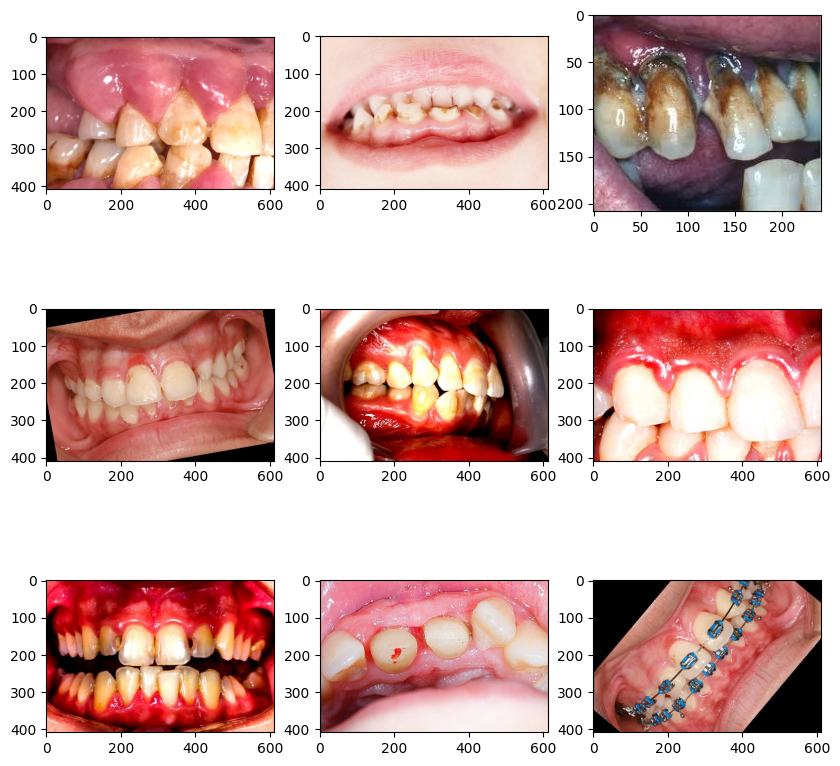

In [ ]:
visualize(gingivits_data)

### Caries Data

Dental caries or tooth decay, which is a common condition where the hard tissues of the tooth, such as enamel and dentin, are damaged by acids produced by bacteria.

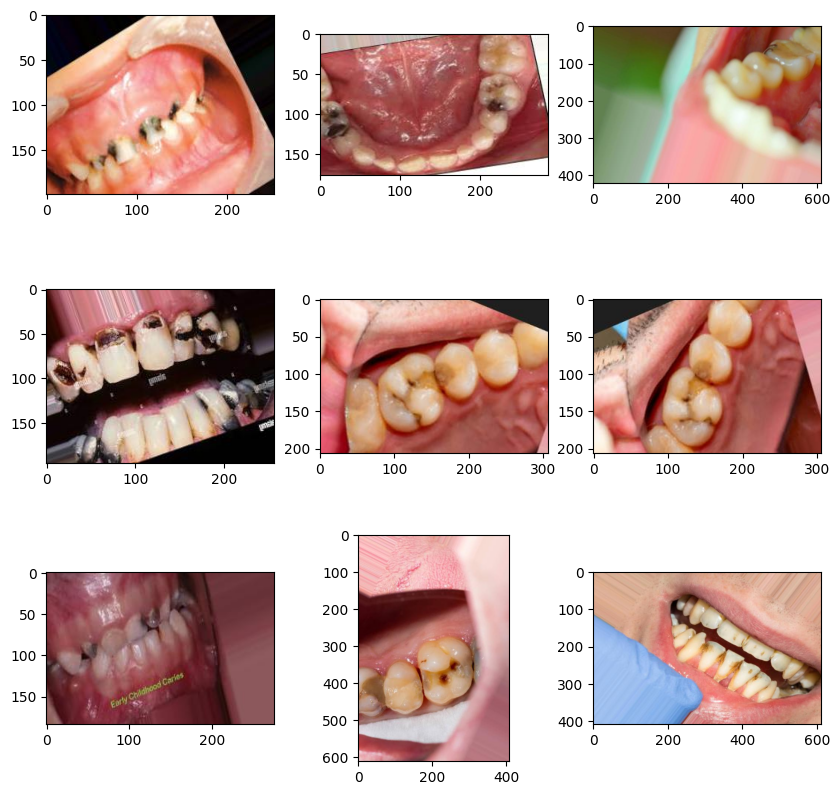

In [ ]:
visualize(caries_data)

### Calculus Data

Tooth calculus, also known as dental calculus or tartar, is a hardened deposit that forms on the teeth. It is a result of the mineralization of dental plaque, which is a soft and sticky film of bacteria that constantly forms on the teeth and gums. Dental calculus can contribute to various oral health issues and is commonly removed through professional dental cleanings.

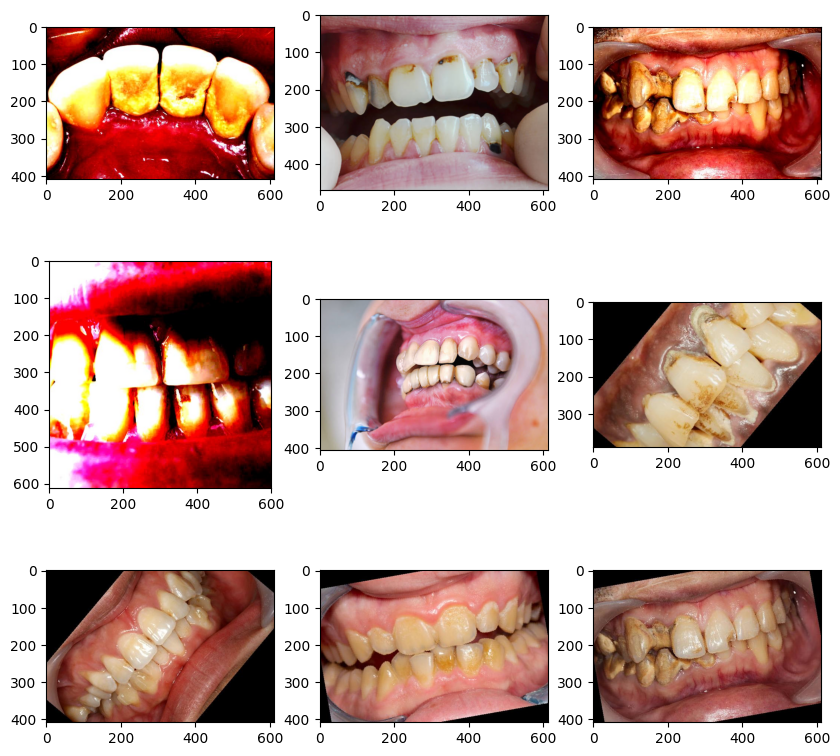

In [ ]:
visualize(calculus_data)

### Hypodontia

Hypodontia is a dental condition characterized by the developmental absence of one or more teeth, excluding the third molars (wisdom teeth). In individuals with hypodontia, certain permanent teeth fail to develop or do not fully emerge in the oral cavity.

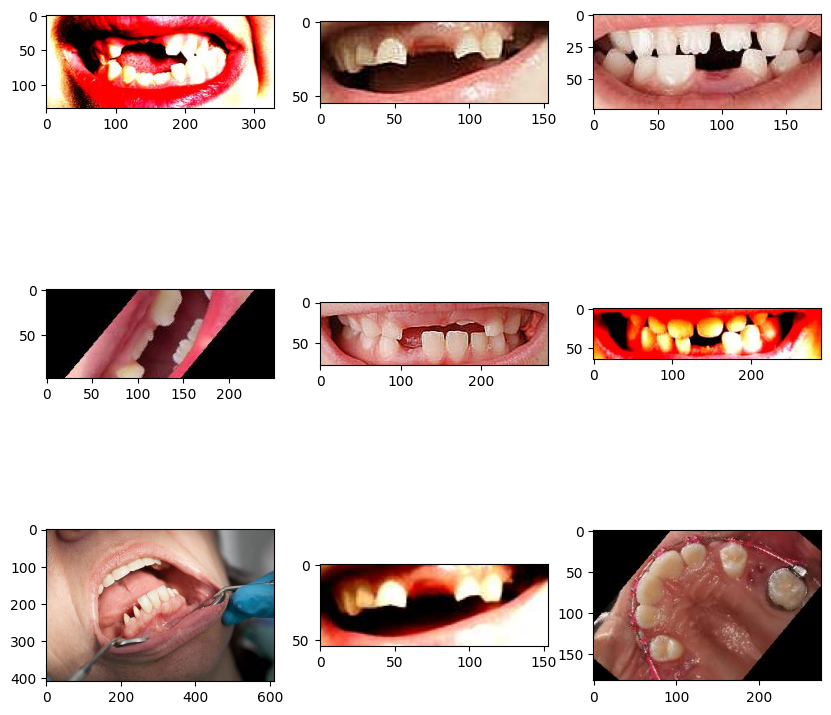

In [ ]:
visualize(hypodontia_data)

## Healthy

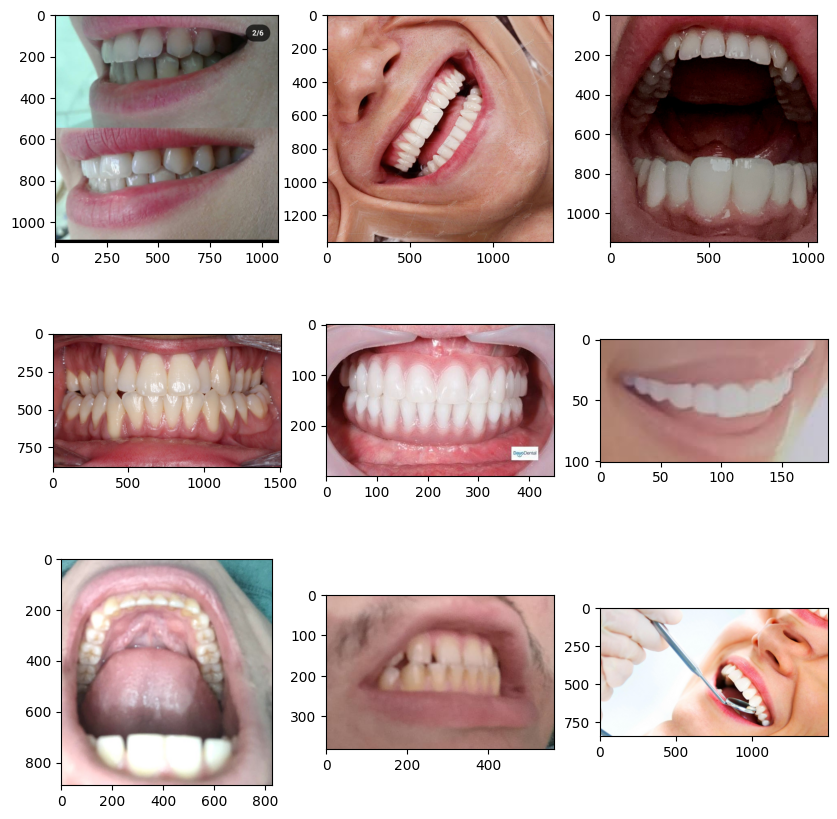

In [ ]:
visualize(healthy_data)

In [ ]:
classes=os.listdir(ROOT_PATH)

In [ ]:
classes

['Gingivitis', 'hypodontia', 'Data caries', 'Calculus', 'healthy']

## Generating Labels

In [ ]:
from sklearn.model_selection import train_test_split

classes=os.listdir(ROOT_PATH)
print(classes)

X = []
y = []



print(classes)

for i, cls in enumerate(classes):

    if cls=='Gingivitis':
      X.extend(gingivits_data)
      y.extend([i]*len(gingivits_data))
    elif cls=='hypodontia':
      X.extend(hypodontia_data)
      y.extend([i]*len(hypodontia_data))
    elif cls=='Data caries':
      X.extend(caries_data)
      y.extend([i]*len(caries_data))
    elif cls=='Calculus':
      X.extend(calculus_data)
      y.extend([i]*len(calculus_data))
    elif cls=='healthy':
      X.extend(healthy_data)
      y.extend([i]*len(healthy_data))




['Gingivitis', 'hypodontia', 'Data caries', 'Calculus', 'healthy']
['Gingivitis', 'hypodontia', 'Data caries', 'Calculus', 'healthy']


In [ ]:
len(y)

8715

## DataFrame

In [ ]:
all_dataset_df=pd.DataFrame({'filename':X,'class':y})
all_dataset_df=all_dataset_df.sample(frac=1).reset_index(drop=True)


In [ ]:
all_dataset_df.head()

filename  class
0  /content/drive/MyDrive/Tasarım Çalışması Dat...      2
1  /content/drive/MyDrive/Tasarım Çalışması Dat...      1
2  /content/drive/MyDrive/Tasarım Çalışması Dat...      2
3  /content/drive/MyDrive/Tasarım Çalışması Dat...      4
4  /content/drive/MyDrive/Tasarım Çalışması Dat...      1

In [ ]:
train_dataset_df, test_dataset_df = train_test_split(all_dataset_df, test_size=0.1,shuffle=True, random_state=42)
train_dataset_df=train_dataset_df.sample(frac=1).reset_index(drop=True)
test_dataset_df=test_dataset_df.sample(frac=1).reset_index(drop=True)


In [ ]:
print(f"Length of all dataset is {len(all_dataset_df)}")

Length of all dataset is 8715


In [ ]:
all_dataset_df.head()

filename  class
0  /content/drive/MyDrive/Tasarım Çalışması Dat...      2
1  /content/drive/MyDrive/Tasarım Çalışması Dat...      1
2  /content/drive/MyDrive/Tasarım Çalışması Dat...      2
3  /content/drive/MyDrive/Tasarım Çalışması Dat...      4
4  /content/drive/MyDrive/Tasarım Çalışması Dat...      1

## Distrubution Of Labels

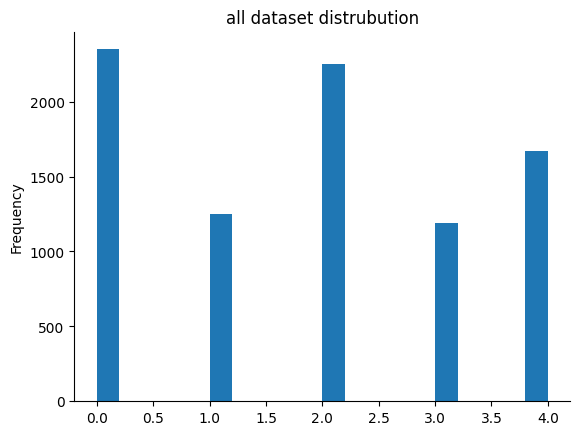

In [ ]:
from matplotlib import pyplot as plt
all_dataset_df['class'].plot(kind='hist', bins=20, title='all dataset distrubution')
plt.gca().spines[['top', 'right',]].set_visible(False)

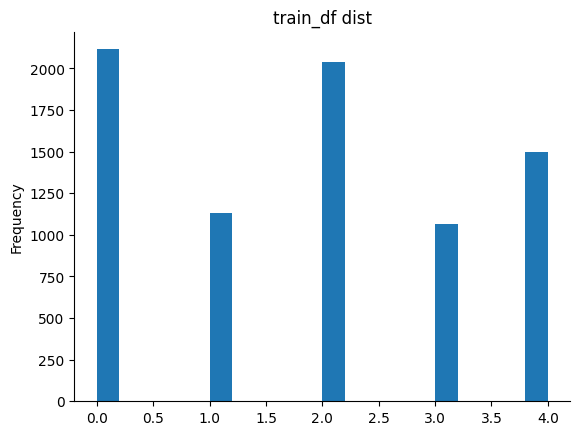

In [ ]:
from matplotlib import pyplot as plt
train_dataset_df['class'].plot(kind='hist', bins=20, title='train_df dist')
plt.gca().spines[['top', 'right',]].set_visible(False)

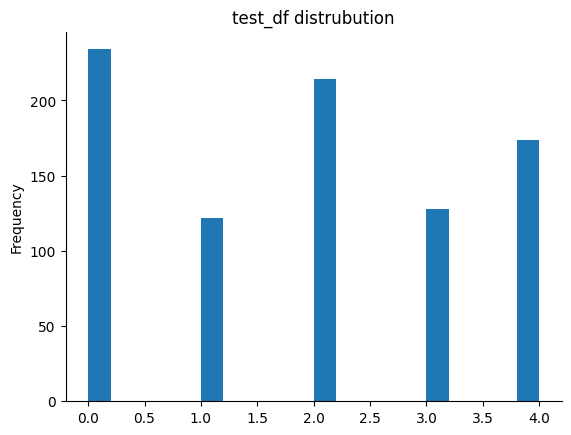

In [ ]:
from matplotlib import pyplot as plt
test_dataset_df['class'].plot(kind='hist', bins=20, title='test_df distrubution')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Dataframe Class Column Type Conversions

In [ ]:
all_dataset_df["class"]=all_dataset_df["class"].astype("str")
train_dataset_df["class"]=train_dataset_df["class"].astype("str")
test_dataset_df["class"]=test_dataset_df["class"].astype("str")

## Create Batch Generator


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale = 1/255.0
)


## Model Building

In [ ]:
def build_model_xception():
  model=Sequential()
  base_model = Xception(weights="imagenet", include_top=False,input_shape=(150,150,3))

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)

  x = Dense(512, activation ='relu')(x)
  x = BatchNormalization()(x)


  x = Dense(256, activation ='relu')(x)
  x = BatchNormalization()(x)


  predictions = Dense(5, activation ='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)

  model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [ ]:
def build_model_resnet():
  model=Sequential()
  base_model = ResNet50V2(weights="imagenet", include_top=False,input_shape=(150,150,3))

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  #x = Dropout(0.5)(x)
  x = Dense(512, activation ='relu')(x)
  x = BatchNormalization()(x)
  #x = Dropout(0.5)(x)

  x = Dense(256, activation ='relu')(x)
  x = BatchNormalization()(x)


  predictions = Dense(5, activation ='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  # checkPointer=ModelCheckpoint(filepath='XceptionCrossValidatedWith5Class.hdf5',verbose=1,save_best_only=True)
  model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [ ]:
def build_model_mobilenetv2():
  model=Sequential()
  base_model = MobileNetV2(weights="imagenet", include_top=False,input_shape=(150,150,3))

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  #x = Dropout(0.5)(x)
  x = Dense(512, activation ='relu')(x)
  x = BatchNormalization()(x)
  #x = Dropout(0.5)(x)

  x = Dense(256, activation ='relu')(x)
  x = BatchNormalization()(x)


  predictions = Dense(5, activation ='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  # checkPointer=ModelCheckpoint(filepath='XceptionCrossValidatedWith5Class.hdf5',verbose=1,save_best_only=True)
  model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


## Stratified KFold Cross Validation

### What's the stratified KFold Cross Validation

In [ ]:
# Test veri setini yükleyip ön işleme yapma fonksiyonu
def load_and_preprocess_image(filename):
    img = plt.imread(filename)
    img = cv2.resize(img, (150, 150))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img / 255.0  # normalize to [0,1] range
    img_array = np.expand_dims(img, axis=0)
    return img_array

In [ ]:
from tqdm import tqdm

def predict_labels(model, dataset_df):
    true_labels = []
    predicted_labels = []

    for _, row in tqdm(dataset_df.iterrows(), total=len(dataset_df)):
        filename = row['filename']
        true_label = row['class']

        # Gerçek etiketi kaydedin
        true_labels.append(int(true_label))

        # Test veri setinden resmi yükleyin ve ön işleme yapın
        img_array = load_and_preprocess_image(filename)

        # Modelinizi kullanarak tahmin yapın (modeli yüklemeyi unutmayın)
        prediction = model.predict(img_array)
        predicted_label = np.argmax(prediction)

        # Tahmini kaydedin
        predicted_labels.append(predicted_label)

    return true_labels, predicted_labels

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

num_folds = 5
# Veri setimizin indisleri
indices = np.arange(len(all_dataset_df))

val_losses_xception = []
val_accuracies_xception = []
train_accuracies_xception = []
train_losses_xception = []
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

# StratifiedKFold ile indisleri bölün
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for train_index, test_index in skf.split(indices, all_dataset_df['class']):
    train_data = all_dataset_df.iloc[train_index]
    test_data = all_dataset_df.iloc[test_index]

    # train_data ve test_data ile generatorları oluşturun
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        xcol='filename',
        ycol='class',
        batch_size=32,
        target_size=(150, 150),
        class_mode='categorical',
        color_mode='rgb'
    )

    valid_generator = datagen.flow_from_dataframe(
        dataframe=test_data,
        xcol='filename',
        ycol='class',
        batch_size=32,
        target_size=(150, 150),
        class_mode='categorical',
        color_mode='rgb'
    )

    # Created Model
    model_xception = build_model_xception()

    history = model_xception.fit(train_generator, epochs=15, validation_data=valid_generator, batch_size=200)
    train_accuracy = history.history['accuracy']  # Tüm epochların değerini al
    train_loss = history.history['loss']
    val_accuracy = history.history['val_accuracy']  # Tüm epochların değerlerini al
    val_loss = history.history['val_loss']
    train_accuracies_xception.append(train_accuracy)
    train_losses_xception.append(train_loss)
    val_accuracies_xception.append(val_accuracy)
    val_losses_xception.append(val_loss)

    y_true,y_pred=predict_labels(model_xception,test_data)

    # Calculate and store accuracy for the current fold
    accuracy = accuracy_score(y_true, y_pred)
    fold_accuracies.append(accuracy)

    # Calculate and store precision for the current fold
    precision = precision_score(y_true, y_pred, average='weighted')
    fold_precisions.append(precision)

    # Calculate and store recall for the current fold
    recall = recall_score(y_true, y_pred, average='weighted')
    fold_recalls.append(recall)

    # Calculate and store F1 score for the current fold
    f1 = f1_score(y_true, y_pred, average='weighted')
    fold_f1_scores.append(f1)

# Calculate the average metrics across all folds
average_accuracy = np.mean(fold_accuracies)
average_precision = np.mean(fold_precisions)
average_recall = np.mean(fold_recalls)
average_f1_score = np.mean(fold_f1_scores)

# Print or use the average metrics as needed
print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 Score:", average_f1_score)


Found 6972 validated image filenames belonging to 5 classes.
Found 1743 validated image filenames belonging to 5 classes.


Epoch 1/15
218/218 [==============================] - 79s 261ms/step - loss: 0.5735 - accuracy: 0.7887 - val_loss: 0.3944 - val_accuracy: 0.8680
Epoch 2/15
218/218 [==============================] - 53s 241ms/step - loss: 0.3056 - accuracy: 0.8775 - val_loss: 0.4230 - val_accuracy: 0.8732
Epoch 3/15
218/218 [==============================] - 53s 242ms/step - loss: 0.2651 - accuracy: 0.8881 - val_loss: 0.6245 - val_accuracy: 0.8067
Epoch 4/15
218/218 [==============================] - 53s 241ms/step - loss: 0.2464 - accuracy: 0.8964 - val_loss: 0.3439 - val_accuracy: 0.8646
Epoch 5/15
218/218 [==============================] - 53s 241ms/step - loss: 0.2100 - accuracy: 0.9058 - val_loss: 0.2699 - val_accuracy: 0.8921
Epoch 6/15
218/218 [==============================] - 53s 241ms/step - loss: 0.2310 - accuracy: 0.9003 - val_loss: 0.7122 - val_accuracy: 0.7975
Epoch 7/15
218/218 [==============================] - 53s 243ms/step - loss: 0.2118 - accuracy: 0.9055 - val_loss: 0.4260 - val_ac

  0%|          | 0/1743 [00:00<?, ?it/s]

1/1 [==============================] - 1s 715ms/step


  0%|          | 1/1743 [00:00<22:09,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 3/1743 [00:00<07:27,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 5/1743 [00:01<04:40,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 7/1743 [00:01<03:29,  8.29it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 9/1743 [00:01<02:56,  9.84it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 11/1743 [00:01<02:36, 11.08it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 13/1743 [00:01<02:23, 12.09it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 15/1743 [00:01<02:12, 13.07it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 17/1743 [00:01<02:10, 13.23it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 19/1743 [00:02<02:05, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 21/1743 [00:02<02:05, 13.75it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 23/1743 [00:02<02:05, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 25/1743 [00:02<02:03, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 27/1743 [00:02<02:02, 13.96it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 29/1743 [00:02<02:01, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 31/1743 [00:02<01:58, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 33/1743 [00:02<01:57, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 35/1743 [00:03<01:59, 14.28it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 37/1743 [00:03<01:57, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 39/1743 [00:03<01:57, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 41/1743 [00:03<01:57, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 43/1743 [00:03<02:02, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 45/1743 [00:03<02:01, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 47/1743 [00:03<01:57, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 49/1743 [00:04<01:54, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 51/1743 [00:04<02:06, 13.36it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 53/1743 [00:04<02:04, 13.61it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 55/1743 [00:04<01:59, 14.17it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 57/1743 [00:04<01:56, 14.46it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 59/1743 [00:04<01:53, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 61/1743 [00:04<01:50, 15.16it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 63/1743 [00:05<01:50, 15.21it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 65/1743 [00:05<01:48, 15.40it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 67/1743 [00:05<01:48, 15.52it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 69/1743 [00:05<01:50, 15.12it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 71/1743 [00:05<01:52, 14.90it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 73/1743 [00:05<01:50, 15.05it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 75/1743 [00:05<01:50, 15.06it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 77/1743 [00:05<01:49, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 79/1743 [00:06<01:49, 15.19it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 81/1743 [00:06<01:49, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 83/1743 [00:06<01:51, 14.90it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 85/1743 [00:06<01:49, 15.10it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 87/1743 [00:06<01:49, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 89/1743 [00:06<01:49, 15.09it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 91/1743 [00:06<01:48, 15.21it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 93/1743 [00:07<01:47, 15.34it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 95/1743 [00:07<01:47, 15.30it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 97/1743 [00:07<01:47, 15.34it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 99/1743 [00:07<01:47, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 101/1743 [00:07<01:46, 15.43it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 103/1743 [00:07<01:46, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 105/1743 [00:07<01:45, 15.45it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 107/1743 [00:07<01:47, 15.20it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 109/1743 [00:08<01:48, 15.08it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 111/1743 [00:08<01:47, 15.24it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 113/1743 [00:08<01:47, 15.13it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 115/1743 [00:08<01:47, 15.16it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 117/1743 [00:08<01:50, 14.68it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 119/1743 [00:08<01:49, 14.84it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 121/1743 [00:08<01:47, 15.07it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 123/1743 [00:09<01:47, 15.13it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 125/1743 [00:09<01:47, 15.05it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 127/1743 [00:09<01:47, 15.08it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 129/1743 [00:09<01:45, 15.27it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 131/1743 [00:09<01:55, 13.94it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 133/1743 [00:09<01:52, 14.34it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 135/1743 [00:09<01:51, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 137/1743 [00:09<01:50, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 139/1743 [00:10<01:49, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 141/1743 [00:10<01:48, 14.79it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 143/1743 [00:10<01:49, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 145/1743 [00:10<01:48, 14.76it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 147/1743 [00:10<01:48, 14.73it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 149/1743 [00:10<01:48, 14.72it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 151/1743 [00:10<01:48, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 153/1743 [00:11<01:51, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 155/1743 [00:11<01:49, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 157/1743 [00:11<01:51, 14.23it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 159/1743 [00:11<01:48, 14.54it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 161/1743 [00:11<01:48, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 163/1743 [00:11<01:47, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 165/1743 [00:11<01:46, 14.79it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 167/1743 [00:12<01:48, 14.54it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 169/1743 [00:12<01:46, 14.76it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 171/1743 [00:12<01:46, 14.79it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 173/1743 [00:12<01:45, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 175/1743 [00:12<01:44, 15.02it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 177/1743 [00:12<01:42, 15.29it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 179/1743 [00:12<01:43, 15.14it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 181/1743 [00:12<01:44, 14.96it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 183/1743 [00:13<01:52, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 185/1743 [00:13<01:49, 14.17it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 187/1743 [00:13<01:47, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 189/1743 [00:13<01:46, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 191/1743 [00:13<01:47, 14.49it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 193/1743 [00:13<01:46, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 195/1743 [00:13<01:46, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 197/1743 [00:14<01:47, 14.39it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 199/1743 [00:14<01:48, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 201/1743 [00:14<01:49, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 203/1743 [00:14<01:53, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 205/1743 [00:14<01:50, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 207/1743 [00:14<01:48, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 209/1743 [00:14<01:47, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 211/1743 [00:15<01:47, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 213/1743 [00:15<01:47, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 215/1743 [00:15<01:47, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 217/1743 [00:15<01:49, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 219/1743 [00:15<01:47, 14.23it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 221/1743 [00:15<01:48, 13.99it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 223/1743 [00:15<01:49, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 225/1743 [00:16<01:48, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 227/1743 [00:16<01:48, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 229/1743 [00:16<01:45, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 231/1743 [00:16<01:44, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 233/1743 [00:16<01:46, 14.22it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 235/1743 [00:16<01:49, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 237/1743 [00:16<01:51, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 239/1743 [00:17<01:50, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 241/1743 [00:17<01:50, 13.54it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 243/1743 [00:17<01:51, 13.46it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 245/1743 [00:17<01:48, 13.86it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 247/1743 [00:17<01:44, 14.27it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 249/1743 [00:17<01:42, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 251/1743 [00:17<01:42, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 253/1743 [00:18<01:42, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 255/1743 [00:18<01:41, 14.62it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 257/1743 [00:18<01:42, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 259/1743 [00:18<01:42, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 261/1743 [00:18<01:42, 14.51it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 263/1743 [00:18<01:41, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 265/1743 [00:18<01:40, 14.63it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 267/1743 [00:19<01:39, 14.77it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 269/1743 [00:19<01:41, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 271/1743 [00:19<01:42, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 273/1743 [00:19<01:44, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 275/1743 [00:19<01:43, 14.20it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 277/1743 [00:19<01:41, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 279/1743 [00:19<01:42, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 281/1743 [00:20<01:46, 13.71it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 283/1743 [00:20<01:43, 14.09it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 285/1743 [00:20<01:39, 14.59it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 287/1743 [00:20<01:37, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 289/1743 [00:20<01:36, 15.01it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 291/1743 [00:20<01:36, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 293/1743 [00:20<01:35, 15.25it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 295/1743 [00:20<01:36, 14.95it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 297/1743 [00:21<01:37, 14.84it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 299/1743 [00:21<01:37, 14.83it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 301/1743 [00:21<01:37, 14.84it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 303/1743 [00:21<01:38, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 305/1743 [00:21<01:37, 14.75it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 307/1743 [00:21<01:37, 14.76it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 309/1743 [00:21<01:35, 14.99it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 311/1743 [00:22<01:35, 14.95it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 313/1743 [00:22<01:35, 14.99it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 315/1743 [00:22<01:36, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 317/1743 [00:22<01:35, 14.94it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 319/1743 [00:22<01:34, 15.09it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 321/1743 [00:22<01:34, 15.05it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 323/1743 [00:22<01:34, 15.05it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 325/1743 [00:22<01:36, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 327/1743 [00:23<01:37, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 329/1743 [00:23<01:37, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 331/1743 [00:23<01:37, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 333/1743 [00:23<01:40, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 335/1743 [00:23<01:39, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 337/1743 [00:23<01:40, 14.05it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 339/1743 [00:23<01:37, 14.39it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 341/1743 [00:24<01:36, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 343/1743 [00:24<01:36, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 345/1743 [00:24<01:35, 14.61it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 347/1743 [00:24<01:34, 14.76it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 349/1743 [00:24<01:33, 14.84it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 351/1743 [00:24<01:35, 14.60it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 353/1743 [00:24<01:35, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 355/1743 [00:25<01:35, 14.53it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 357/1743 [00:25<01:34, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 359/1743 [00:25<01:32, 14.94it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 361/1743 [00:25<01:34, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 363/1743 [00:25<01:33, 14.70it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 365/1743 [00:25<01:32, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 367/1743 [00:25<01:31, 14.99it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 369/1743 [00:26<01:33, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 371/1743 [00:26<01:34, 14.56it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 373/1743 [00:26<01:35, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 375/1743 [00:26<01:37, 14.02it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 377/1743 [00:26<01:35, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 379/1743 [00:26<01:35, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 381/1743 [00:26<01:36, 14.11it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 383/1743 [00:26<01:35, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 385/1743 [00:27<01:35, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 387/1743 [00:27<01:37, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 389/1743 [00:27<01:37, 13.90it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 391/1743 [00:27<01:36, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 393/1743 [00:27<01:35, 14.15it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 395/1743 [00:27<01:36, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 397/1743 [00:28<01:40, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 399/1743 [00:28<01:42, 13.18it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 401/1743 [00:28<01:41, 13.16it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 403/1743 [00:28<01:41, 13.22it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 405/1743 [00:28<01:40, 13.26it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 407/1743 [00:28<01:37, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 409/1743 [00:28<01:37, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 411/1743 [00:29<01:35, 13.90it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 413/1743 [00:29<01:33, 14.28it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 415/1743 [00:29<01:32, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 417/1743 [00:29<01:31, 14.44it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 419/1743 [00:29<01:29, 14.76it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 421/1743 [00:29<01:28, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 423/1743 [00:29<01:28, 14.92it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 425/1743 [00:29<01:27, 15.04it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 427/1743 [00:30<01:27, 15.04it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 429/1743 [00:30<01:27, 15.01it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 431/1743 [00:30<01:29, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 433/1743 [00:30<01:29, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 435/1743 [00:30<01:28, 14.78it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 437/1743 [00:30<01:26, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 439/1743 [00:30<01:26, 15.14it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 441/1743 [00:31<01:26, 15.04it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 443/1743 [00:31<01:26, 15.08it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 445/1743 [00:31<01:26, 14.97it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 447/1743 [00:31<01:25, 15.11it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 449/1743 [00:31<01:25, 15.10it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 451/1743 [00:31<01:27, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 453/1743 [00:31<01:27, 14.71it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 455/1743 [00:31<01:26, 14.81it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 457/1743 [00:32<01:26, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 459/1743 [00:32<01:26, 14.88it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 461/1743 [00:32<01:25, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 463/1743 [00:32<01:25, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 465/1743 [00:32<01:24, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 467/1743 [00:32<01:23, 15.32it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 469/1743 [00:32<01:24, 15.01it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 471/1743 [00:33<01:25, 14.91it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 473/1743 [00:33<01:25, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 475/1743 [00:33<01:25, 14.75it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 477/1743 [00:33<01:26, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 479/1743 [00:33<01:25, 14.76it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 481/1743 [00:33<01:30, 13.91it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 483/1743 [00:33<01:28, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 485/1743 [00:34<01:26, 14.61it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 487/1743 [00:34<01:28, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 489/1743 [00:34<01:27, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 491/1743 [00:34<01:26, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 493/1743 [00:34<01:25, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 495/1743 [00:34<01:25, 14.53it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 497/1743 [00:34<01:26, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 499/1743 [00:34<01:25, 14.61it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 501/1743 [00:35<01:24, 14.75it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 503/1743 [00:35<01:24, 14.76it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 505/1743 [00:35<01:24, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 507/1743 [00:35<01:24, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 509/1743 [00:35<01:23, 14.83it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 511/1743 [00:35<01:23, 14.78it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 513/1743 [00:35<01:24, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 515/1743 [00:36<01:26, 14.26it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 517/1743 [00:36<01:26, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 519/1743 [00:36<01:29, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 521/1743 [00:36<01:28, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 523/1743 [00:36<01:29, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 525/1743 [00:36<01:29, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 527/1743 [00:36<01:31, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 529/1743 [00:37<01:30, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 531/1743 [00:37<01:30, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 533/1743 [00:37<01:29, 13.47it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 535/1743 [00:37<01:28, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 537/1743 [00:37<01:28, 13.58it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 539/1743 [00:37<01:28, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 541/1743 [00:38<01:28, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 543/1743 [00:38<01:29, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 545/1743 [00:38<01:31, 13.13it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 547/1743 [00:38<01:30, 13.24it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 549/1743 [00:38<01:29, 13.35it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 551/1743 [00:38<01:26, 13.84it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 553/1743 [00:38<01:23, 14.19it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 555/1743 [00:39<01:24, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 557/1743 [00:39<01:25, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 559/1743 [00:39<01:28, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 561/1743 [00:39<01:29, 13.24it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 563/1743 [00:39<01:28, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 565/1743 [00:39<01:27, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 567/1743 [00:39<01:29, 13.11it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 569/1743 [00:40<01:28, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 571/1743 [00:40<01:28, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 573/1743 [00:40<01:27, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 575/1743 [00:40<01:27, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 577/1743 [00:40<01:29, 13.09it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 579/1743 [00:40<01:29, 13.01it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 581/1743 [00:41<01:28, 13.17it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 583/1743 [00:41<01:27, 13.32it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 585/1743 [00:41<01:29, 12.90it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 587/1743 [00:41<01:29, 12.96it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 589/1743 [00:41<01:27, 13.21it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 591/1743 [00:41<01:26, 13.38it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 593/1743 [00:41<01:25, 13.47it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 595/1743 [00:42<01:26, 13.20it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 597/1743 [00:42<01:27, 13.15it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 599/1743 [00:42<01:25, 13.32it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 601/1743 [00:42<01:25, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 603/1743 [00:42<01:25, 13.28it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 605/1743 [00:42<01:24, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 607/1743 [00:42<01:24, 13.38it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 609/1743 [00:43<01:24, 13.47it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 611/1743 [00:43<01:24, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 613/1743 [00:43<01:25, 13.21it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 615/1743 [00:43<01:24, 13.35it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 617/1743 [00:43<01:25, 13.15it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 619/1743 [00:43<01:24, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 621/1743 [00:44<01:23, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 623/1743 [00:44<01:24, 13.29it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 625/1743 [00:44<01:24, 13.16it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 627/1743 [00:44<01:24, 13.23it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 629/1743 [00:44<01:23, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 631/1743 [00:44<01:24, 13.12it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 633/1743 [00:44<01:25, 12.99it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 635/1743 [00:45<01:26, 12.87it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 637/1743 [00:45<01:31, 12.12it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 639/1743 [00:45<01:28, 12.51it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 641/1743 [00:45<01:26, 12.68it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 643/1743 [00:45<01:25, 12.85it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 645/1743 [00:45<01:23, 13.07it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 647/1743 [00:46<01:22, 13.25it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 649/1743 [00:46<01:22, 13.23it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 651/1743 [00:46<01:21, 13.42it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 653/1743 [00:46<01:20, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 655/1743 [00:46<01:19, 13.74it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 657/1743 [00:46<01:18, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 659/1743 [00:46<01:18, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 661/1743 [00:47<01:18, 13.80it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 663/1743 [00:47<01:18, 13.67it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 665/1743 [00:47<01:21, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 667/1743 [00:47<01:21, 13.25it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 669/1743 [00:47<01:20, 13.36it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 671/1743 [00:47<01:19, 13.52it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 673/1743 [00:47<01:18, 13.58it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 675/1743 [00:48<01:18, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 677/1743 [00:48<01:18, 13.49it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 679/1743 [00:48<01:18, 13.52it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 681/1743 [00:48<01:18, 13.60it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 683/1743 [00:48<01:17, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 685/1743 [00:48<01:17, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 687/1743 [00:48<01:17, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 689/1743 [00:49<01:16, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 691/1743 [00:49<01:20, 13.15it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 693/1743 [00:49<01:19, 13.17it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 695/1743 [00:49<01:19, 13.13it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 697/1743 [00:49<01:18, 13.27it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 699/1743 [00:49<01:22, 12.59it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 701/1743 [00:50<01:20, 12.96it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 703/1743 [00:50<01:20, 12.94it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 705/1743 [00:50<01:19, 12.99it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 707/1743 [00:50<01:18, 13.19it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 709/1743 [00:50<01:17, 13.37it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 711/1743 [00:50<01:17, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 713/1743 [00:50<01:17, 13.29it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 715/1743 [00:51<01:16, 13.52it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 717/1743 [00:51<01:13, 13.96it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 719/1743 [00:51<01:11, 14.28it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 721/1743 [00:51<01:12, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 723/1743 [00:51<01:10, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 725/1743 [00:51<01:09, 14.64it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 727/1743 [00:51<01:08, 14.77it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 729/1743 [00:52<01:09, 14.66it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 731/1743 [00:52<01:09, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 733/1743 [00:52<01:08, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 735/1743 [00:52<01:09, 14.46it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 737/1743 [00:52<01:09, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 739/1743 [00:52<01:09, 14.41it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 741/1743 [00:52<01:09, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 743/1743 [00:53<01:09, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 745/1743 [00:53<01:08, 14.55it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 747/1743 [00:53<01:07, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 749/1743 [00:53<01:07, 14.66it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 751/1743 [00:53<01:09, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 753/1743 [00:53<01:09, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 755/1743 [00:53<01:09, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 757/1743 [00:54<01:09, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 759/1743 [00:54<01:09, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 761/1743 [00:54<01:09, 14.10it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 763/1743 [00:54<01:09, 14.12it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 765/1743 [00:54<01:09, 14.11it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 767/1743 [00:54<01:08, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 769/1743 [00:54<01:07, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 771/1743 [00:54<01:06, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 773/1743 [00:55<01:06, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 775/1743 [00:55<01:07, 14.44it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 777/1743 [00:55<01:06, 14.52it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 779/1743 [00:55<01:05, 14.66it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 781/1743 [00:55<01:04, 14.93it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 783/1743 [00:55<01:21, 11.72it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 785/1743 [00:56<01:16, 12.48it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 787/1743 [00:56<01:12, 13.17it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 789/1743 [00:56<01:11, 13.43it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 791/1743 [00:56<01:08, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 793/1743 [00:56<01:07, 13.99it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 795/1743 [00:57<02:22,  6.64it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 797/1743 [00:57<02:01,  7.80it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 799/1743 [00:57<01:44,  8.99it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 801/1743 [00:57<01:33, 10.08it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 803/1743 [00:57<01:26, 10.87it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 805/1743 [00:57<01:20, 11.67it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 807/1743 [00:58<01:15, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 809/1743 [00:58<01:12, 12.90it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 811/1743 [00:58<01:09, 13.37it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 813/1743 [00:58<01:10, 13.19it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 815/1743 [00:58<01:08, 13.53it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 817/1743 [00:58<01:08, 13.55it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 819/1743 [00:58<01:06, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 821/1743 [00:59<01:06, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 823/1743 [00:59<01:06, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 825/1743 [00:59<01:05, 14.03it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 827/1743 [00:59<01:04, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 829/1743 [00:59<01:05, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 831/1743 [00:59<01:05, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 833/1743 [00:59<01:04, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 835/1743 [01:00<01:05, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 837/1743 [01:00<01:03, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 839/1743 [01:00<01:05, 13.77it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 841/1743 [01:00<01:04, 13.90it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 843/1743 [01:00<01:03, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 845/1743 [01:00<01:02, 14.34it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 847/1743 [01:00<01:02, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 849/1743 [01:01<01:03, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 851/1743 [01:01<01:02, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 853/1743 [01:01<01:02, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 855/1743 [01:01<01:02, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 857/1743 [01:01<01:02, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 859/1743 [01:01<01:02, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 861/1743 [01:01<01:02, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 863/1743 [01:02<01:01, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 865/1743 [01:02<01:00, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 867/1743 [01:02<01:01, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 869/1743 [01:02<01:01, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 871/1743 [01:02<01:00, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 873/1743 [01:02<00:59, 14.71it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 875/1743 [01:02<00:59, 14.61it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 877/1743 [01:03<00:58, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 879/1743 [01:03<00:58, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 881/1743 [01:03<00:58, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 883/1743 [01:03<00:57, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 885/1743 [01:03<00:58, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 887/1743 [01:03<00:57, 14.76it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 889/1743 [01:03<00:58, 14.71it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 891/1743 [01:04<00:57, 14.72it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 893/1743 [01:04<00:58, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 895/1743 [01:04<00:58, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 897/1743 [01:04<00:58, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 899/1743 [01:04<00:57, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 901/1743 [01:04<00:57, 14.71it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 903/1743 [01:04<00:58, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 905/1743 [01:04<00:58, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 907/1743 [01:05<00:58, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 909/1743 [01:05<00:58, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 911/1743 [01:05<00:59, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 913/1743 [01:05<01:01, 13.49it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 915/1743 [01:05<01:00, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 917/1743 [01:05<00:59, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 919/1743 [01:05<00:59, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 921/1743 [01:06<00:59, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 923/1743 [01:06<00:58, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 925/1743 [01:06<00:58, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 927/1743 [01:06<00:57, 14.11it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 929/1743 [01:06<00:57, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 931/1743 [01:06<00:57, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 933/1743 [01:06<00:56, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 935/1743 [01:07<00:56, 14.37it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 937/1743 [01:07<00:55, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 939/1743 [01:07<00:57, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 941/1743 [01:07<00:56, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 943/1743 [01:07<00:55, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 945/1743 [01:07<00:56, 14.24it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 947/1743 [01:07<00:55, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 949/1743 [01:08<00:55, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 951/1743 [01:08<00:55, 14.28it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 953/1743 [01:08<00:55, 14.27it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 955/1743 [01:08<00:54, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 957/1743 [01:08<00:54, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 959/1743 [01:08<00:54, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 961/1743 [01:08<00:53, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 963/1743 [01:09<00:52, 14.82it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 965/1743 [01:09<00:52, 14.91it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 967/1743 [01:09<00:53, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 969/1743 [01:09<00:52, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 971/1743 [01:09<00:52, 14.70it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 973/1743 [01:09<00:51, 14.97it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 975/1743 [01:09<00:51, 14.82it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 977/1743 [01:09<00:51, 14.91it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 979/1743 [01:10<00:51, 14.78it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 981/1743 [01:10<00:51, 14.88it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 983/1743 [01:10<00:50, 14.96it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 985/1743 [01:10<00:51, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 987/1743 [01:10<00:51, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 989/1743 [01:10<00:50, 14.99it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 991/1743 [01:10<00:50, 14.91it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 993/1743 [01:11<00:51, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 995/1743 [01:11<00:51, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 997/1743 [01:11<00:50, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 999/1743 [01:11<00:50, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1001/1743 [01:11<00:49, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1003/1743 [01:11<00:49, 14.92it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1005/1743 [01:11<00:48, 15.16it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1007/1743 [01:12<00:48, 15.06it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1009/1743 [01:12<00:49, 14.94it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1011/1743 [01:12<00:49, 14.68it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1013/1743 [01:12<00:49, 14.72it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1015/1743 [01:12<00:49, 14.69it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1017/1743 [01:12<00:50, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1019/1743 [01:12<00:49, 14.52it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 1021/1743 [01:12<00:50, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1023/1743 [01:13<00:50, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1025/1743 [01:13<00:50, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1027/1743 [01:13<00:56, 12.73it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1029/1743 [01:13<00:57, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1031/1743 [01:13<00:53, 13.25it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1033/1743 [01:13<00:51, 13.83it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1035/1743 [01:14<00:50, 14.11it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1037/1743 [01:14<00:49, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1039/1743 [01:14<00:48, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1041/1743 [01:14<00:47, 14.77it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1043/1743 [01:14<00:48, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1045/1743 [01:14<00:48, 14.51it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1047/1743 [01:14<00:48, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1049/1743 [01:14<00:48, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1051/1743 [01:15<00:47, 14.66it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1053/1743 [01:15<00:46, 14.79it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1055/1743 [01:15<00:46, 14.81it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1057/1743 [01:15<00:46, 14.66it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1059/1743 [01:15<00:46, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1061/1743 [01:15<00:45, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1063/1743 [01:15<00:45, 14.79it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1065/1743 [01:16<00:46, 14.71it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1067/1743 [01:16<00:45, 14.79it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 1069/1743 [01:16<00:45, 14.81it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 1071/1743 [01:16<00:45, 14.89it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1073/1743 [01:16<00:45, 14.77it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1075/1743 [01:16<00:45, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1077/1743 [01:16<00:46, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1079/1743 [01:17<00:45, 14.60it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1081/1743 [01:17<00:45, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1083/1743 [01:17<00:45, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1085/1743 [01:17<00:46, 14.28it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1087/1743 [01:17<00:49, 13.35it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1089/1743 [01:17<00:49, 13.25it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1091/1743 [01:17<00:50, 13.03it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1093/1743 [01:18<00:49, 13.11it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1095/1743 [01:18<00:47, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1097/1743 [01:18<00:46, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1099/1743 [01:18<00:46, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1101/1743 [01:18<00:45, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1103/1743 [01:18<00:45, 14.09it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1105/1743 [01:18<00:45, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 1107/1743 [01:19<00:45, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 1109/1743 [01:19<00:45, 13.97it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 1111/1743 [01:19<00:45, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1113/1743 [01:19<00:46, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1115/1743 [01:19<00:46, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1117/1743 [01:19<00:45, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1119/1743 [01:19<00:46, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1121/1743 [01:20<00:45, 13.54it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1123/1743 [01:20<00:45, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1125/1743 [01:20<00:45, 13.67it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1127/1743 [01:20<00:44, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1129/1743 [01:20<00:44, 13.84it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1131/1743 [01:20<00:43, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1133/1743 [01:20<00:42, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1135/1743 [01:21<00:42, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 1137/1743 [01:21<00:44, 13.53it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 1139/1743 [01:21<00:44, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1141/1743 [01:21<00:43, 14.00it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1143/1743 [01:21<00:42, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1145/1743 [01:21<00:41, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1147/1743 [01:21<00:41, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1149/1743 [01:22<00:41, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1151/1743 [01:22<00:40, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1153/1743 [01:22<00:41, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 1155/1743 [01:22<00:41, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 1157/1743 [01:22<00:41, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 1159/1743 [01:22<00:40, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1161/1743 [01:22<00:40, 14.39it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1163/1743 [01:23<00:40, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1165/1743 [01:23<00:40, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1167/1743 [01:23<00:39, 14.45it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1169/1743 [01:23<00:40, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1171/1743 [01:23<00:40, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1173/1743 [01:23<00:40, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1175/1743 [01:23<00:40, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1177/1743 [01:24<00:40, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1179/1743 [01:24<00:39, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1181/1743 [01:24<00:39, 14.29it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1183/1743 [01:24<00:39, 14.24it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1185/1743 [01:24<00:39, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1187/1743 [01:24<00:38, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1189/1743 [01:24<00:38, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1191/1743 [01:25<00:38, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1193/1743 [01:25<00:38, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 1195/1743 [01:25<00:38, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 1197/1743 [01:25<00:38, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1199/1743 [01:25<00:37, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1201/1743 [01:25<00:38, 14.12it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1203/1743 [01:25<00:38, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1205/1743 [01:26<00:37, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 1207/1743 [01:26<00:37, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1209/1743 [01:26<00:37, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1211/1743 [01:26<00:37, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1213/1743 [01:26<00:37, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1215/1743 [01:26<00:37, 14.11it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 1217/1743 [01:26<00:36, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1219/1743 [01:27<00:36, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1221/1743 [01:27<00:36, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1223/1743 [01:27<00:36, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1225/1743 [01:27<00:36, 14.05it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1227/1743 [01:27<00:35, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1229/1743 [01:27<00:36, 14.24it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1231/1743 [01:27<00:35, 14.44it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1233/1743 [01:27<00:35, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1235/1743 [01:28<00:34, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1237/1743 [01:28<00:35, 14.24it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1239/1743 [01:28<00:35, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1241/1743 [01:28<00:34, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 1243/1743 [01:28<00:34, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 1245/1743 [01:28<00:33, 14.82it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1247/1743 [01:28<00:34, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1249/1743 [01:29<00:34, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1251/1743 [01:29<00:35, 13.97it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1253/1743 [01:29<00:34, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1255/1743 [01:29<00:34, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1257/1743 [01:29<00:34, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1259/1743 [01:29<00:34, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1261/1743 [01:29<00:34, 13.90it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1263/1743 [01:30<00:34, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1265/1743 [01:30<00:34, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1267/1743 [01:30<00:35, 13.29it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1269/1743 [01:30<00:35, 13.34it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1271/1743 [01:30<00:34, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1273/1743 [01:30<00:33, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1275/1743 [01:30<00:34, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1277/1743 [01:31<00:34, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1279/1743 [01:31<00:34, 13.56it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1281/1743 [01:31<00:33, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 1283/1743 [01:31<00:33, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 1285/1743 [01:31<00:33, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1287/1743 [01:31<00:32, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1289/1743 [01:32<00:32, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1291/1743 [01:32<00:32, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1293/1743 [01:32<00:32, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1295/1743 [01:32<00:32, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1297/1743 [01:32<00:31, 14.14it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 1299/1743 [01:32<00:31, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 1301/1743 [01:32<00:31, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 1303/1743 [01:32<00:31, 14.12it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 1305/1743 [01:33<00:30, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 1307/1743 [01:33<00:30, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1309/1743 [01:33<00:30, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1311/1743 [01:33<00:30, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1313/1743 [01:33<00:30, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1315/1743 [01:33<00:29, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1317/1743 [01:33<00:29, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1319/1743 [01:34<00:29, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1321/1743 [01:34<00:29, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1323/1743 [01:34<00:30, 13.69it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1325/1743 [01:34<00:29, 14.17it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1327/1743 [01:34<00:29, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1329/1743 [01:34<00:28, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 1331/1743 [01:34<00:28, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 1333/1743 [01:35<00:28, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1335/1743 [01:35<00:28, 14.55it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1337/1743 [01:35<00:28, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1339/1743 [01:35<00:28, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1341/1743 [01:35<00:28, 14.26it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1343/1743 [01:35<00:27, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1345/1743 [01:35<00:27, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1347/1743 [01:36<00:27, 14.17it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1349/1743 [01:36<00:27, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1351/1743 [01:36<00:27, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1353/1743 [01:36<00:27, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1355/1743 [01:36<00:27, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1357/1743 [01:36<00:26, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1359/1743 [01:36<00:26, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1361/1743 [01:37<00:26, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1363/1743 [01:37<00:28, 13.37it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1365/1743 [01:37<00:28, 13.39it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1367/1743 [01:37<00:27, 13.85it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 1369/1743 [01:37<00:26, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 1371/1743 [01:37<00:25, 14.37it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1373/1743 [01:37<00:25, 14.30it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1375/1743 [01:38<00:25, 14.40it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1377/1743 [01:38<00:25, 14.51it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1379/1743 [01:38<00:25, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1381/1743 [01:38<00:25, 14.22it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1383/1743 [01:38<00:25, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1385/1743 [01:38<00:25, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 1387/1743 [01:38<00:24, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1389/1743 [01:39<00:25, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1391/1743 [01:39<00:24, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 1393/1743 [01:39<00:24, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1395/1743 [01:39<00:24, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1397/1743 [01:39<00:23, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1399/1743 [01:39<00:23, 14.91it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1401/1743 [01:39<00:23, 14.78it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1403/1743 [01:39<00:22, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1405/1743 [01:40<00:22, 14.93it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1407/1743 [01:40<00:22, 14.83it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1409/1743 [01:40<00:23, 14.41it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1411/1743 [01:40<00:22, 14.53it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1413/1743 [01:40<00:22, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1415/1743 [01:40<00:22, 14.86it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 1417/1743 [01:40<00:21, 14.82it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 1419/1743 [01:41<00:22, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1421/1743 [01:41<00:22, 14.48it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 1423/1743 [01:41<00:22, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1425/1743 [01:41<00:22, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1427/1743 [01:41<00:22, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1429/1743 [01:41<00:21, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1431/1743 [01:41<00:21, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1433/1743 [01:42<00:21, 14.53it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1435/1743 [01:42<00:21, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 1437/1743 [01:42<00:21, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1439/1743 [01:42<00:21, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1441/1743 [01:42<00:22, 13.45it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1443/1743 [01:42<00:21, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1445/1743 [01:42<00:21, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1447/1743 [01:43<00:21, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1449/1743 [01:43<00:21, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1451/1743 [01:43<00:20, 13.94it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1453/1743 [01:43<00:20, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1455/1743 [01:43<00:20, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 1457/1743 [01:43<00:20, 13.98it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 1459/1743 [01:43<00:20, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1461/1743 [01:44<00:20, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 1463/1743 [01:44<00:20, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 1465/1743 [01:44<00:20, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 1467/1743 [01:44<00:20, 13.55it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1469/1743 [01:44<00:19, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1471/1743 [01:44<00:19, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1473/1743 [01:44<00:19, 13.69it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 1475/1743 [01:45<00:19, 13.43it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1477/1743 [01:45<00:20, 12.67it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1479/1743 [01:45<00:20, 13.02it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1481/1743 [01:45<00:20, 12.91it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1483/1743 [01:45<00:19, 13.16it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1485/1743 [01:45<00:19, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1487/1743 [01:46<00:18, 13.66it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 1489/1743 [01:46<00:18, 13.96it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1491/1743 [01:46<00:18, 13.86it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1493/1743 [01:46<00:17, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1495/1743 [01:46<00:17, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1497/1743 [01:46<00:16, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1499/1743 [01:46<00:16, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1501/1743 [01:46<00:16, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1503/1743 [01:47<00:16, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 1505/1743 [01:47<00:16, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 1507/1743 [01:47<00:16, 13.93it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1509/1743 [01:47<00:16, 13.95it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 1511/1743 [01:47<00:16, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1513/1743 [01:47<00:16, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1515/1743 [01:47<00:16, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 1517/1743 [01:48<00:16, 13.52it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1519/1743 [01:48<00:16, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 1521/1743 [01:48<00:16, 13.19it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1523/1743 [01:48<00:16, 13.42it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1525/1743 [01:48<00:19, 11.17it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1527/1743 [01:48<00:18, 11.81it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1529/1743 [01:49<00:17, 12.52it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1531/1743 [01:49<00:16, 13.15it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1533/1743 [01:49<00:15, 13.50it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1535/1743 [01:49<00:15, 13.83it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1537/1743 [01:49<00:14, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1539/1743 [01:49<00:14, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1541/1743 [01:49<00:14, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 1543/1743 [01:50<00:13, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 1545/1743 [01:50<00:13, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1547/1743 [01:50<00:13, 14.51it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1549/1743 [01:50<00:13, 14.61it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1551/1743 [01:50<00:13, 14.68it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 1553/1743 [01:50<00:12, 14.81it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1555/1743 [01:50<00:12, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1557/1743 [01:51<00:12, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1559/1743 [01:51<00:12, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1561/1743 [01:51<00:12, 14.39it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 1563/1743 [01:51<00:12, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 1565/1743 [01:51<00:12, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 1567/1743 [01:51<00:12, 14.51it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1569/1743 [01:51<00:12, 14.31it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 1571/1743 [01:52<00:11, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1573/1743 [01:52<00:11, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1575/1743 [01:52<00:11, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1577/1743 [01:52<00:11, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1579/1743 [01:52<00:11, 14.76it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1581/1743 [01:52<00:10, 14.92it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1583/1743 [01:52<00:10, 14.78it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1585/1743 [01:52<00:10, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1587/1743 [01:53<00:10, 14.89it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1589/1743 [01:53<00:10, 15.03it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 1591/1743 [01:53<00:10, 14.97it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 1593/1743 [01:53<00:10, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1595/1743 [01:53<00:10, 14.35it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1597/1743 [01:53<00:10, 14.53it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1599/1743 [01:53<00:09, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1601/1743 [01:54<00:09, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1603/1743 [01:54<00:09, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1605/1743 [01:54<00:09, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1607/1743 [01:54<00:09, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1609/1743 [01:54<00:09, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1611/1743 [01:54<00:09, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1613/1743 [01:54<00:09, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1615/1743 [01:55<00:09, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1617/1743 [01:55<00:08, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1619/1743 [01:55<00:08, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1621/1743 [01:55<00:08, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1623/1743 [01:55<00:08, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1625/1743 [01:55<00:08, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1627/1743 [01:55<00:08, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1629/1743 [01:56<00:08, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 1631/1743 [01:56<00:08, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 1633/1743 [01:56<00:08, 13.65it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1635/1743 [01:56<00:07, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1637/1743 [01:56<00:08, 12.94it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1639/1743 [01:56<00:07, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1641/1743 [01:56<00:07, 13.34it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1643/1743 [01:57<00:07, 13.25it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1645/1743 [01:57<00:07, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1647/1743 [01:57<00:07, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1649/1743 [01:57<00:06, 13.70it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 1651/1743 [01:57<00:06, 13.66it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 1653/1743 [01:57<00:06, 13.76it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 1655/1743 [01:57<00:06, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1657/1743 [01:58<00:06, 13.64it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 1659/1743 [01:58<00:06, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 1661/1743 [01:58<00:05, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 1663/1743 [01:58<00:05, 13.96it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1665/1743 [01:58<00:05, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1667/1743 [01:58<00:05, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1669/1743 [01:58<00:05, 13.58it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 1671/1743 [01:59<00:05, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1673/1743 [01:59<00:05, 12.67it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1675/1743 [01:59<00:05, 13.20it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1677/1743 [01:59<00:04, 13.52it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 1679/1743 [01:59<00:04, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 1681/1743 [01:59<00:04, 13.65it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1683/1743 [02:00<00:04, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1685/1743 [02:00<00:04, 13.98it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1687/1743 [02:00<00:04, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1689/1743 [02:00<00:03, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1691/1743 [02:00<00:03, 14.01it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1693/1743 [02:00<00:03, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1695/1743 [02:00<00:03, 14.27it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1697/1743 [02:00<00:03, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1699/1743 [02:01<00:03, 14.26it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1701/1743 [02:01<00:02, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1703/1743 [02:01<00:02, 14.48it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 1705/1743 [02:01<00:02, 13.36it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1707/1743 [02:01<00:02, 13.33it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1709/1743 [02:01<00:02, 13.42it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1711/1743 [02:02<00:02, 13.53it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1713/1743 [02:02<00:02, 13.99it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1715/1743 [02:02<00:01, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 1717/1743 [02:02<00:01, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 1719/1743 [02:02<00:01, 14.27it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 1721/1743 [02:02<00:01, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1723/1743 [02:02<00:01, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1725/1743 [02:02<00:01, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1727/1743 [02:03<00:01, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1729/1743 [02:03<00:00, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1731/1743 [02:03<00:00, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1733/1743 [02:03<00:00, 14.38it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1735/1743 [02:03<00:00, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1737/1743 [02:03<00:00, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 1739/1743 [02:03<00:00, 13.94it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 1741/1743 [02:04<00:00, 13.95it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 1743/1743 [02:04<00:00, 14.03it/s]


Found 6972 validated image filenames belonging to 5 classes.
Found 1743 validated image filenames belonging to 5 classes.


Epoch 1/15
218/218 [==============================] - 76s 250ms/step - loss: 0.5878 - accuracy: 0.7811 - val_loss: 0.4929 - val_accuracy: 0.8135
Epoch 2/15
218/218 [==============================] - 53s 242ms/step - loss: 0.3622 - accuracy: 0.8543 - val_loss: 0.3144 - val_accuracy: 0.8571
Epoch 3/15
218/218 [==============================] - 53s 242ms/step - loss: 0.2788 - accuracy: 0.8797 - val_loss: 0.2849 - val_accuracy: 0.8635
Epoch 4/15
218/218 [==============================] - 53s 242ms/step - loss: 0.2662 - accuracy: 0.8865 - val_loss: 0.2609 - val_accuracy: 0.8887
Epoch 5/15
218/218 [==============================] - 53s 243ms/step - loss: 0.2327 - accuracy: 0.8972 - val_loss: 0.3667 - val_accuracy: 0.8462
Epoch 6/15
218/218 [==============================] - 53s 243ms/step - loss: 0.2269 - accuracy: 0.8953 - val_loss: 0.4557 - val_accuracy: 0.8600
Epoch 7/15
218/218 [==============================] - 53s 242ms/step - loss: 0.2086 - accuracy: 0.9061 - val_loss: 0.3581 - val_ac

  0%|          | 0/1743 [00:00<?, ?it/s]

1/1 [==============================] - 1s 721ms/step


  0%|          | 1/1743 [00:00<22:21,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 3/1743 [00:00<07:14,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 5/1743 [00:01<04:29,  6.45it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 7/1743 [00:01<03:23,  8.51it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 9/1743 [00:01<02:53, 10.00it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 11/1743 [00:01<02:32, 11.33it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 13/1743 [00:01<02:19, 12.44it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 15/1743 [00:01<02:09, 13.37it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 17/1743 [00:01<02:05, 13.80it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 19/1743 [00:01<02:04, 13.82it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 21/1743 [00:02<02:01, 14.14it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 23/1743 [00:02<02:00, 14.31it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 25/1743 [00:02<01:57, 14.61it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 27/1743 [00:02<01:58, 14.50it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 29/1743 [00:02<01:56, 14.75it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 31/1743 [00:02<01:55, 14.80it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 33/1743 [00:02<01:53, 15.04it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 35/1743 [00:03<01:58, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 37/1743 [00:03<02:01, 13.99it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 39/1743 [00:03<01:59, 14.29it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 41/1743 [00:03<01:57, 14.44it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 43/1743 [00:03<01:56, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 45/1743 [00:03<02:29, 11.34it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 47/1743 [00:04<02:17, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 49/1743 [00:04<02:11, 12.91it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 51/1743 [00:04<02:06, 13.39it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 53/1743 [00:04<02:00, 13.99it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 55/1743 [00:04<01:59, 14.17it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 57/1743 [00:04<01:56, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 59/1743 [00:04<01:56, 14.44it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 61/1743 [00:04<01:55, 14.62it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 63/1743 [00:05<01:55, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 65/1743 [00:05<01:55, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 67/1743 [00:05<01:54, 14.61it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 69/1743 [00:05<02:08, 13.02it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 71/1743 [00:05<02:03, 13.55it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 73/1743 [00:05<02:05, 13.30it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 75/1743 [00:05<02:03, 13.55it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 77/1743 [00:06<02:02, 13.57it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 79/1743 [00:06<02:01, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 81/1743 [00:06<01:58, 14.05it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 83/1743 [00:06<01:55, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 85/1743 [00:06<01:53, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 87/1743 [00:06<01:53, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 89/1743 [00:06<01:54, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 91/1743 [00:07<01:55, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 93/1743 [00:07<01:55, 14.31it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 95/1743 [00:07<01:52, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 97/1743 [00:07<01:53, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 99/1743 [00:07<01:56, 14.10it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 101/1743 [00:07<01:55, 14.27it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 103/1743 [00:07<01:53, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 105/1743 [00:08<01:52, 14.61it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 107/1743 [00:08<01:49, 15.00it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 109/1743 [00:08<01:50, 14.77it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 111/1743 [00:08<01:50, 14.81it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 113/1743 [00:08<01:49, 14.90it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 115/1743 [00:08<01:49, 14.91it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 117/1743 [00:08<01:50, 14.75it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 119/1743 [00:09<01:50, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 121/1743 [00:09<01:50, 14.71it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 123/1743 [00:09<01:48, 14.97it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 125/1743 [00:09<01:46, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 127/1743 [00:09<01:47, 14.98it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 129/1743 [00:09<01:47, 15.08it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 131/1743 [00:09<01:46, 15.07it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 133/1743 [00:09<01:46, 15.15it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 135/1743 [00:10<01:48, 14.79it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 137/1743 [00:10<01:48, 14.85it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 139/1743 [00:10<01:45, 15.14it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 141/1743 [00:10<01:45, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 143/1743 [00:10<01:46, 15.05it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 145/1743 [00:10<01:46, 14.98it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 147/1743 [00:10<01:46, 15.05it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 149/1743 [00:10<01:46, 15.01it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 151/1743 [00:11<01:44, 15.22it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 153/1743 [00:11<01:44, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 155/1743 [00:11<01:43, 15.39it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 157/1743 [00:11<01:44, 15.24it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 159/1743 [00:11<01:45, 15.01it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 161/1743 [00:11<01:46, 14.91it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 163/1743 [00:11<01:46, 14.85it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 165/1743 [00:12<01:46, 14.86it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 167/1743 [00:12<01:46, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 169/1743 [00:12<01:44, 14.99it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 171/1743 [00:12<01:46, 14.82it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 173/1743 [00:12<01:45, 14.86it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 175/1743 [00:12<01:45, 14.86it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 177/1743 [00:12<01:45, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 179/1743 [00:13<01:44, 14.94it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 181/1743 [00:13<01:59, 13.02it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 183/1743 [00:13<01:55, 13.56it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 185/1743 [00:13<01:51, 13.91it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 187/1743 [00:13<01:48, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 189/1743 [00:13<01:47, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 191/1743 [00:13<01:46, 14.62it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 193/1743 [00:14<01:46, 14.51it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 195/1743 [00:14<01:44, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 197/1743 [00:14<01:43, 14.95it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 199/1743 [00:14<01:54, 13.52it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 201/1743 [00:14<01:51, 13.88it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 203/1743 [00:14<01:47, 14.28it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 205/1743 [00:14<01:45, 14.60it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 207/1743 [00:14<01:44, 14.75it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 209/1743 [00:15<01:42, 14.99it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 211/1743 [00:15<01:41, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 213/1743 [00:15<01:41, 15.01it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 215/1743 [00:15<01:44, 14.68it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 217/1743 [00:15<01:44, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 219/1743 [00:15<01:43, 14.68it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 221/1743 [00:15<01:42, 14.78it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 223/1743 [00:16<01:40, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 225/1743 [00:16<01:41, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 227/1743 [00:16<01:39, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 229/1743 [00:16<01:39, 15.15it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 231/1743 [00:16<01:40, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 233/1743 [00:16<01:39, 15.16it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 235/1743 [00:16<01:40, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 237/1743 [00:16<01:39, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 239/1743 [00:17<01:38, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 241/1743 [00:17<01:39, 15.17it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 243/1743 [00:17<01:39, 15.06it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 245/1743 [00:17<01:39, 15.03it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 247/1743 [00:17<01:50, 13.58it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 249/1743 [00:17<01:47, 13.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 251/1743 [00:17<01:45, 14.18it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 253/1743 [00:18<01:44, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 255/1743 [00:18<01:43, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 257/1743 [00:18<01:42, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 259/1743 [00:18<01:49, 13.58it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 261/1743 [00:18<01:52, 13.18it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 263/1743 [00:18<01:48, 13.58it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 265/1743 [00:18<01:47, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 267/1743 [00:19<01:46, 13.88it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 269/1743 [00:19<01:44, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 271/1743 [00:19<01:43, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 273/1743 [00:19<01:42, 14.38it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 275/1743 [00:19<01:43, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 277/1743 [00:19<01:43, 14.18it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 279/1743 [00:19<01:40, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 281/1743 [00:20<01:40, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 283/1743 [00:20<01:39, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 285/1743 [00:20<01:40, 14.51it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 287/1743 [00:20<01:39, 14.67it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 289/1743 [00:20<01:41, 14.36it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 291/1743 [00:20<01:43, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 293/1743 [00:20<01:45, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 295/1743 [00:21<01:45, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 297/1743 [00:21<01:45, 13.75it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 299/1743 [00:21<01:45, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 301/1743 [00:21<01:43, 13.92it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 303/1743 [00:21<01:41, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 305/1743 [00:21<01:43, 13.88it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 307/1743 [00:21<01:42, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 309/1743 [00:22<01:40, 14.27it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 311/1743 [00:22<01:38, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 313/1743 [00:22<01:36, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 315/1743 [00:22<01:35, 14.89it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 317/1743 [00:22<01:36, 14.85it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 319/1743 [00:22<01:34, 14.99it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 321/1743 [00:22<01:34, 14.98it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 323/1743 [00:23<01:38, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 325/1743 [00:23<01:37, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 327/1743 [00:23<01:37, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 329/1743 [00:23<01:36, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 331/1743 [00:23<01:34, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 333/1743 [00:23<01:34, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 335/1743 [00:23<01:36, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 337/1743 [00:23<01:34, 14.80it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 339/1743 [00:24<01:33, 15.05it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 341/1743 [00:24<01:50, 12.69it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 343/1743 [00:24<01:45, 13.22it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 345/1743 [00:24<01:43, 13.52it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 347/1743 [00:24<01:40, 13.84it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 349/1743 [00:24<01:39, 14.05it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 351/1743 [00:24<01:37, 14.22it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 353/1743 [00:25<01:39, 13.93it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 355/1743 [00:25<01:36, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 357/1743 [00:25<01:35, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 359/1743 [00:25<01:34, 14.69it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 361/1743 [00:25<01:33, 14.84it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 363/1743 [00:25<01:32, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 365/1743 [00:25<01:33, 14.71it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 367/1743 [00:26<01:33, 14.75it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 369/1743 [00:26<01:32, 14.82it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 371/1743 [00:26<01:33, 14.71it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 373/1743 [00:26<01:32, 14.85it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 375/1743 [00:26<01:32, 14.71it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 377/1743 [00:26<01:32, 14.83it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 379/1743 [00:26<01:32, 14.70it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 381/1743 [00:27<01:34, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 383/1743 [00:27<01:33, 14.54it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 385/1743 [00:27<01:32, 14.68it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 387/1743 [00:27<01:30, 14.98it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 389/1743 [00:27<01:30, 14.92it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 391/1743 [00:27<01:30, 14.88it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 393/1743 [00:27<01:30, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 395/1743 [00:27<01:29, 15.05it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 397/1743 [00:28<01:28, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 399/1743 [00:28<01:29, 15.03it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 401/1743 [00:28<01:29, 15.01it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 403/1743 [00:28<01:27, 15.24it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 405/1743 [00:28<01:28, 15.14it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 407/1743 [00:28<01:28, 15.18it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 409/1743 [00:28<01:29, 14.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 411/1743 [00:29<01:32, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 413/1743 [00:29<01:31, 14.56it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 415/1743 [00:29<01:29, 14.77it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 417/1743 [00:29<01:31, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 419/1743 [00:29<01:34, 13.94it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 421/1743 [00:29<01:32, 14.35it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 423/1743 [00:29<01:32, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 425/1743 [00:30<01:32, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 427/1743 [00:30<01:31, 14.44it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 429/1743 [00:30<01:30, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 431/1743 [00:30<01:29, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 433/1743 [00:30<01:28, 14.85it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 435/1743 [00:30<01:29, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 437/1743 [00:30<01:30, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 439/1743 [00:30<01:29, 14.55it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 441/1743 [00:31<01:29, 14.60it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 443/1743 [00:31<01:29, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 445/1743 [00:31<01:28, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 447/1743 [00:31<01:27, 14.75it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 449/1743 [00:31<01:27, 14.81it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 451/1743 [00:31<01:27, 14.83it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 453/1743 [00:31<01:33, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 455/1743 [00:32<01:31, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 457/1743 [00:32<01:30, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 459/1743 [00:32<01:30, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 461/1743 [00:32<01:30, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 463/1743 [00:32<01:29, 14.33it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 465/1743 [00:32<01:28, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 467/1743 [00:32<01:27, 14.51it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 469/1743 [00:33<01:27, 14.52it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 471/1743 [00:33<01:28, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 473/1743 [00:33<01:27, 14.50it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 475/1743 [00:33<01:27, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 477/1743 [00:33<01:26, 14.72it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 479/1743 [00:33<01:25, 14.71it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 481/1743 [00:33<01:25, 14.79it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 483/1743 [00:34<01:25, 14.82it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 485/1743 [00:34<01:23, 14.99it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 487/1743 [00:34<01:22, 15.26it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 489/1743 [00:34<01:23, 15.09it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 491/1743 [00:34<01:23, 15.00it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 493/1743 [00:34<01:24, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 495/1743 [00:34<01:23, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 497/1743 [00:34<01:26, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 499/1743 [00:35<01:26, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 501/1743 [00:35<01:25, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 503/1743 [00:35<01:26, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 505/1743 [00:35<01:24, 14.69it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 507/1743 [00:35<01:31, 13.49it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 509/1743 [00:35<01:29, 13.83it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 511/1743 [00:35<01:26, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 513/1743 [00:36<01:26, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 515/1743 [00:36<01:26, 14.19it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 517/1743 [00:36<01:27, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 519/1743 [00:36<01:25, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 521/1743 [00:36<01:23, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 523/1743 [00:36<01:23, 14.65it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 525/1743 [00:36<01:23, 14.54it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 527/1743 [00:37<01:22, 14.75it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 529/1743 [00:37<01:21, 14.86it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 531/1743 [00:37<01:23, 14.44it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 533/1743 [00:37<01:23, 14.48it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 535/1743 [00:37<01:22, 14.61it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 537/1743 [00:37<01:21, 14.71it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 539/1743 [00:37<01:22, 14.67it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 541/1743 [00:37<01:22, 14.62it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 543/1743 [00:38<01:21, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 545/1743 [00:38<01:20, 14.88it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 547/1743 [00:38<01:21, 14.73it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 549/1743 [00:38<01:19, 14.98it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 551/1743 [00:38<01:21, 14.70it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 553/1743 [00:38<01:21, 14.64it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 555/1743 [00:38<01:20, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 557/1743 [00:39<01:20, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 559/1743 [00:39<01:20, 14.78it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 561/1743 [00:39<01:20, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 563/1743 [00:39<01:19, 14.77it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 565/1743 [00:39<01:24, 13.92it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 567/1743 [00:39<01:28, 13.32it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 569/1743 [00:39<01:26, 13.63it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 571/1743 [00:40<01:27, 13.47it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 573/1743 [00:40<01:24, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 575/1743 [00:40<01:22, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 577/1743 [00:40<01:20, 14.47it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 579/1743 [00:40<01:21, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 581/1743 [00:40<01:19, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 583/1743 [00:40<01:19, 14.52it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 585/1743 [00:41<01:20, 14.43it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 587/1743 [00:41<01:22, 13.94it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 589/1743 [00:41<01:20, 14.38it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 591/1743 [00:41<01:18, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 593/1743 [00:41<01:17, 14.80it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 595/1743 [00:41<01:16, 14.92it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 597/1743 [00:41<01:18, 14.66it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 599/1743 [00:42<01:16, 14.86it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 601/1743 [00:42<01:16, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 603/1743 [00:42<01:15, 15.17it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 605/1743 [00:42<01:17, 14.74it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 607/1743 [00:42<01:16, 14.85it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 609/1743 [00:42<01:16, 14.84it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 611/1743 [00:42<01:16, 14.77it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 613/1743 [00:42<01:17, 14.66it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 615/1743 [00:43<01:17, 14.60it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 617/1743 [00:43<01:15, 14.83it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 619/1743 [00:43<01:15, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 621/1743 [00:43<01:15, 14.84it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 623/1743 [00:43<01:18, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 625/1743 [00:43<01:20, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 627/1743 [00:43<01:18, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 629/1743 [00:44<01:20, 13.78it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 631/1743 [00:44<01:18, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 633/1743 [00:44<01:19, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 635/1743 [00:44<01:17, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 637/1743 [00:44<01:16, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 639/1743 [00:44<01:16, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 641/1743 [00:44<01:18, 14.12it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 643/1743 [00:45<01:17, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 645/1743 [00:45<01:17, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 647/1743 [00:45<01:16, 14.37it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 649/1743 [00:45<01:14, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 651/1743 [00:45<01:15, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 653/1743 [00:45<01:15, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 655/1743 [00:45<01:15, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 657/1743 [00:46<01:15, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 659/1743 [00:46<01:14, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 661/1743 [00:46<01:15, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 663/1743 [00:46<01:14, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 665/1743 [00:46<01:15, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 667/1743 [00:46<01:15, 14.17it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 669/1743 [00:46<01:16, 14.10it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 671/1743 [00:47<01:14, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 673/1743 [00:47<01:13, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 675/1743 [00:47<01:13, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 677/1743 [00:47<01:14, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 679/1743 [00:47<01:14, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 681/1743 [00:47<01:13, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 683/1743 [00:47<01:12, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 685/1743 [00:47<01:11, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 687/1743 [00:48<01:13, 14.45it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 689/1743 [00:48<01:11, 14.77it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 691/1743 [00:48<01:10, 14.88it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 693/1743 [00:48<01:11, 14.71it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 695/1743 [00:48<01:10, 14.95it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 697/1743 [00:48<01:10, 14.77it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 699/1743 [00:48<01:10, 14.89it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 701/1743 [00:49<01:09, 15.00it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 703/1743 [00:49<01:14, 13.91it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 705/1743 [00:49<01:14, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 707/1743 [00:49<01:16, 13.58it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 709/1743 [00:49<01:15, 13.77it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 711/1743 [00:49<01:15, 13.65it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 713/1743 [00:49<01:13, 14.01it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 715/1743 [00:50<01:12, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 717/1743 [00:50<01:10, 14.54it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 719/1743 [00:50<01:09, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 721/1743 [00:50<01:07, 15.07it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 723/1743 [00:50<01:07, 15.00it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 725/1743 [00:50<01:08, 14.97it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 727/1743 [00:50<01:08, 14.93it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 729/1743 [00:50<01:08, 14.71it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 731/1743 [00:51<01:09, 14.46it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 733/1743 [00:51<01:13, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 735/1743 [00:51<01:14, 13.58it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 737/1743 [00:51<01:14, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 739/1743 [00:51<01:14, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 741/1743 [00:51<01:14, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 743/1743 [00:52<01:14, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 745/1743 [00:52<01:17, 12.95it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 747/1743 [00:52<01:14, 13.37it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 749/1743 [00:52<01:13, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 751/1743 [00:52<01:14, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 753/1743 [00:52<01:13, 13.42it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 755/1743 [00:52<01:12, 13.62it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 757/1743 [00:53<01:10, 13.93it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 759/1743 [00:53<01:20, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 761/1743 [00:53<01:14, 13.10it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 763/1743 [00:53<01:12, 13.51it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 765/1743 [00:53<01:10, 13.91it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 767/1743 [00:53<01:08, 14.28it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 769/1743 [00:53<01:08, 14.26it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 771/1743 [00:54<01:06, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 773/1743 [00:54<01:05, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 775/1743 [00:54<01:05, 14.85it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 777/1743 [00:54<01:04, 14.98it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 779/1743 [00:54<01:04, 14.86it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 781/1743 [00:54<01:04, 14.92it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 783/1743 [00:54<01:04, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 785/1743 [00:55<01:03, 15.03it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 787/1743 [00:55<01:04, 14.74it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 789/1743 [00:55<01:07, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 791/1743 [00:55<01:06, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 793/1743 [00:55<01:06, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 795/1743 [00:55<01:07, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 797/1743 [00:55<01:06, 14.24it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 799/1743 [00:56<01:05, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 801/1743 [00:56<01:04, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 803/1743 [00:56<01:04, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 805/1743 [00:56<01:05, 14.34it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 807/1743 [00:56<01:05, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 809/1743 [00:56<01:05, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 811/1743 [00:56<01:04, 14.45it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 813/1743 [00:56<01:03, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 815/1743 [00:57<01:04, 14.46it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 817/1743 [00:57<01:03, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 819/1743 [00:57<01:03, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 821/1743 [00:57<01:04, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 823/1743 [00:57<01:04, 14.24it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 825/1743 [00:58<02:31,  6.07it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 827/1743 [00:58<02:09,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 829/1743 [00:58<01:52,  8.13it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 831/1743 [00:58<01:40,  9.09it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 833/1743 [00:59<01:34,  9.61it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 835/1743 [00:59<01:26, 10.55it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 837/1743 [00:59<01:19, 11.39it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 839/1743 [00:59<01:16, 11.88it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 841/1743 [00:59<01:15, 12.02it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 843/1743 [00:59<01:12, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 845/1743 [01:00<01:09, 12.95it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 847/1743 [01:00<01:07, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 849/1743 [01:00<01:04, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 851/1743 [01:00<01:04, 13.73it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 853/1743 [01:00<01:05, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 855/1743 [01:00<01:04, 13.73it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 857/1743 [01:00<01:03, 13.88it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 859/1743 [01:01<01:02, 14.14it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 861/1743 [01:01<01:03, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 863/1743 [01:01<01:03, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 865/1743 [01:01<01:03, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 867/1743 [01:01<01:03, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 869/1743 [01:01<01:03, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 871/1743 [01:01<01:03, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 873/1743 [01:02<01:03, 13.80it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 875/1743 [01:02<01:01, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 877/1743 [01:02<01:00, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 879/1743 [01:02<01:02, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 881/1743 [01:02<01:01, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 883/1743 [01:02<01:00, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 885/1743 [01:02<00:59, 14.37it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 887/1743 [01:03<00:59, 14.28it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 889/1743 [01:03<01:01, 13.96it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 891/1743 [01:03<01:02, 13.66it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 893/1743 [01:03<01:00, 13.94it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 895/1743 [01:03<00:59, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 897/1743 [01:03<01:00, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 899/1743 [01:03<00:58, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 901/1743 [01:03<00:58, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 903/1743 [01:04<00:58, 14.24it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 905/1743 [01:04<00:59, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 907/1743 [01:04<00:59, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 909/1743 [01:04<00:57, 14.40it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 911/1743 [01:04<00:57, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 913/1743 [01:04<00:56, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 915/1743 [01:04<00:57, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 917/1743 [01:05<00:56, 14.69it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 919/1743 [01:05<01:02, 13.15it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 921/1743 [01:05<01:00, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 923/1743 [01:05<00:59, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 925/1743 [01:05<00:59, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 927/1743 [01:05<00:59, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 929/1743 [01:06<00:59, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 931/1743 [01:06<00:58, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 933/1743 [01:06<01:00, 13.33it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 935/1743 [01:06<00:59, 13.67it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 937/1743 [01:06<00:57, 14.03it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 939/1743 [01:06<00:56, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 941/1743 [01:06<00:57, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 943/1743 [01:06<00:55, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 945/1743 [01:07<00:55, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 947/1743 [01:07<00:54, 14.55it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 949/1743 [01:07<00:54, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 951/1743 [01:07<00:55, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 953/1743 [01:07<00:55, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 955/1743 [01:07<00:55, 14.28it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 957/1743 [01:07<00:54, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 959/1743 [01:08<00:55, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 961/1743 [01:08<00:54, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 963/1743 [01:08<00:54, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 965/1743 [01:08<00:54, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 967/1743 [01:08<00:53, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 969/1743 [01:08<00:54, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 971/1743 [01:08<00:53, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 973/1743 [01:09<00:54, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 975/1743 [01:09<00:54, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 977/1743 [01:09<00:54, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 979/1743 [01:09<00:54, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 981/1743 [01:09<00:53, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 983/1743 [01:09<00:52, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 985/1743 [01:09<00:53, 14.08it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 987/1743 [01:10<00:55, 13.51it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 989/1743 [01:10<00:55, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 991/1743 [01:10<00:54, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 993/1743 [01:10<00:54, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 995/1743 [01:10<00:53, 13.91it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 997/1743 [01:10<00:54, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 999/1743 [01:10<00:54, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1001/1743 [01:11<00:54, 13.58it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1003/1743 [01:11<00:54, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1005/1743 [01:11<00:54, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1007/1743 [01:11<00:54, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1009/1743 [01:11<00:53, 13.66it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1011/1743 [01:11<00:52, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1013/1743 [01:11<00:53, 13.60it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1015/1743 [01:12<00:52, 13.77it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1017/1743 [01:12<00:51, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1019/1743 [01:12<00:50, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1021/1743 [01:12<00:50, 14.38it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1023/1743 [01:12<00:50, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1025/1743 [01:12<00:50, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1027/1743 [01:12<00:49, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1029/1743 [01:13<00:48, 14.72it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1031/1743 [01:13<00:50, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1033/1743 [01:13<00:49, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1035/1743 [01:13<00:48, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1037/1743 [01:13<00:48, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1039/1743 [01:13<00:47, 14.81it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1041/1743 [01:13<00:48, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1043/1743 [01:14<00:48, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1045/1743 [01:14<00:48, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1047/1743 [01:14<00:48, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1049/1743 [01:14<00:48, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1051/1743 [01:14<00:48, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1053/1743 [01:14<00:49, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 1055/1743 [01:14<00:48, 14.12it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1057/1743 [01:15<00:48, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1059/1743 [01:15<00:48, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1061/1743 [01:15<00:47, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1063/1743 [01:15<00:49, 13.66it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1065/1743 [01:15<00:48, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1067/1743 [01:15<00:49, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 1069/1743 [01:15<00:48, 13.82it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 1071/1743 [01:16<00:48, 13.94it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1073/1743 [01:16<00:48, 13.81it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1075/1743 [01:16<00:47, 14.01it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1077/1743 [01:16<00:47, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1079/1743 [01:16<00:47, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1081/1743 [01:16<00:46, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1083/1743 [01:16<00:46, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1085/1743 [01:17<00:46, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1087/1743 [01:17<00:46, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1089/1743 [01:17<00:45, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1091/1743 [01:17<00:45, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1093/1743 [01:17<00:46, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1095/1743 [01:17<00:46, 13.88it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1097/1743 [01:17<00:48, 13.45it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1099/1743 [01:18<00:46, 13.90it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1101/1743 [01:18<00:45, 14.02it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1103/1743 [01:18<00:45, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1105/1743 [01:18<00:47, 13.31it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 1107/1743 [01:18<00:45, 13.84it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 1109/1743 [01:18<00:44, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 1111/1743 [01:18<00:44, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1113/1743 [01:19<00:44, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1115/1743 [01:19<00:43, 14.35it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1117/1743 [01:19<00:43, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1119/1743 [01:19<00:44, 13.93it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1121/1743 [01:19<00:44, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1123/1743 [01:19<00:43, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1125/1743 [01:19<00:43, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1127/1743 [01:20<00:42, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1129/1743 [01:20<00:42, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1131/1743 [01:20<00:43, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1133/1743 [01:20<00:45, 13.34it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1135/1743 [01:20<00:44, 13.73it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1137/1743 [01:20<00:43, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1139/1743 [01:20<00:43, 14.01it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1141/1743 [01:21<00:41, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1143/1743 [01:21<00:42, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1145/1743 [01:21<00:41, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1147/1743 [01:21<00:42, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1149/1743 [01:21<00:43, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1151/1743 [01:21<00:43, 13.62it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 1153/1743 [01:21<00:45, 13.06it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 1155/1743 [01:22<00:46, 12.76it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 1157/1743 [01:22<00:46, 12.62it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 1159/1743 [01:22<00:46, 12.57it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1161/1743 [01:22<00:46, 12.59it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1163/1743 [01:22<00:45, 12.63it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1165/1743 [01:22<00:45, 12.70it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1167/1743 [01:23<00:44, 12.90it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1169/1743 [01:23<00:43, 13.11it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1171/1743 [01:23<00:42, 13.62it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1173/1743 [01:23<00:41, 13.86it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1175/1743 [01:23<00:40, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1177/1743 [01:23<00:41, 13.62it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1179/1743 [01:23<00:41, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1181/1743 [01:24<00:41, 13.58it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1183/1743 [01:24<00:41, 13.53it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1185/1743 [01:24<00:40, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1187/1743 [01:24<00:39, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1189/1743 [01:24<00:39, 14.10it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1191/1743 [01:24<00:39, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1193/1743 [01:24<00:39, 13.91it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 1195/1743 [01:25<00:39, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 1197/1743 [01:25<00:39, 13.93it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1199/1743 [01:25<00:37, 14.38it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1201/1743 [01:25<00:37, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1203/1743 [01:25<00:37, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1205/1743 [01:25<00:36, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1207/1743 [01:25<00:36, 14.78it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1209/1743 [01:26<00:38, 13.98it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1211/1743 [01:26<00:37, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1213/1743 [01:26<00:38, 13.90it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1215/1743 [01:26<00:37, 14.24it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1217/1743 [01:26<00:37, 14.12it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1219/1743 [01:26<00:36, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1221/1743 [01:26<00:37, 13.95it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1223/1743 [01:27<00:37, 14.00it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1225/1743 [01:27<00:35, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1227/1743 [01:27<00:34, 14.75it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1229/1743 [01:27<00:34, 14.82it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1231/1743 [01:27<00:35, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1233/1743 [01:27<00:34, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1235/1743 [01:27<00:34, 14.69it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1237/1743 [01:27<00:35, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1239/1743 [01:28<00:36, 13.65it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1241/1743 [01:28<00:35, 14.00it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 1243/1743 [01:28<00:35, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 1245/1743 [01:28<00:35, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1247/1743 [01:28<00:34, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1249/1743 [01:28<00:35, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1251/1743 [01:28<00:34, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1253/1743 [01:29<00:33, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1255/1743 [01:29<00:33, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1257/1743 [01:29<00:33, 14.39it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1259/1743 [01:29<00:33, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1261/1743 [01:29<00:33, 14.20it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1263/1743 [01:29<00:33, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1265/1743 [01:29<00:33, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1267/1743 [01:30<00:34, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1269/1743 [01:30<00:33, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1271/1743 [01:30<00:32, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1273/1743 [01:30<00:32, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1275/1743 [01:30<00:32, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1277/1743 [01:30<00:32, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1279/1743 [01:30<00:31, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1281/1743 [01:31<00:31, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 1283/1743 [01:31<00:31, 14.62it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 1285/1743 [01:31<00:31, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1287/1743 [01:31<00:31, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1289/1743 [01:31<00:31, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1291/1743 [01:31<00:31, 14.17it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1293/1743 [01:31<00:31, 14.22it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1295/1743 [01:32<00:31, 14.35it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1297/1743 [01:32<00:31, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 1299/1743 [01:32<00:31, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 1301/1743 [01:32<00:31, 13.98it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1303/1743 [01:32<00:31, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1305/1743 [01:32<00:31, 14.02it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1307/1743 [01:32<00:31, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1309/1743 [01:33<00:30, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1311/1743 [01:33<00:31, 13.88it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1313/1743 [01:33<00:30, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1315/1743 [01:33<00:30, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1317/1743 [01:33<00:30, 13.96it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1319/1743 [01:33<00:30, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1321/1743 [01:33<00:30, 13.78it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1323/1743 [01:34<00:29, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1325/1743 [01:34<00:29, 14.01it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1327/1743 [01:34<00:31, 13.10it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1329/1743 [01:34<00:30, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 1331/1743 [01:34<00:30, 13.60it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 1333/1743 [01:34<00:29, 13.72it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1335/1743 [01:34<00:29, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1337/1743 [01:35<00:29, 13.93it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1339/1743 [01:35<00:29, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1341/1743 [01:35<00:28, 14.05it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1343/1743 [01:35<00:28, 14.28it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1345/1743 [01:35<00:27, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1347/1743 [01:35<00:27, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1349/1743 [01:35<00:27, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1351/1743 [01:36<00:27, 14.35it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1353/1743 [01:36<00:27, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1355/1743 [01:36<00:29, 13.33it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1357/1743 [01:36<00:28, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1359/1743 [01:36<00:27, 13.80it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1361/1743 [01:36<00:28, 13.60it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1363/1743 [01:36<00:27, 13.93it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1365/1743 [01:37<00:27, 13.96it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1367/1743 [01:37<00:26, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 1369/1743 [01:37<00:26, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 1371/1743 [01:37<00:26, 14.02it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1373/1743 [01:37<00:26, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1375/1743 [01:37<00:27, 13.58it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1377/1743 [01:37<00:26, 13.95it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1379/1743 [01:38<00:26, 13.99it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1381/1743 [01:38<00:25, 14.35it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1383/1743 [01:38<00:25, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1385/1743 [01:38<00:26, 13.41it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1387/1743 [01:38<00:26, 13.47it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 1389/1743 [01:38<00:25, 13.81it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1391/1743 [01:38<00:25, 13.84it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1393/1743 [01:39<00:25, 13.96it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1395/1743 [01:39<00:24, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1397/1743 [01:39<00:24, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1399/1743 [01:39<00:24, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1401/1743 [01:39<00:24, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 1403/1743 [01:39<00:24, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1405/1743 [01:39<00:23, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 1407/1743 [01:40<00:23, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1409/1743 [01:40<00:24, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1411/1743 [01:40<00:25, 13.07it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1413/1743 [01:40<00:24, 13.42it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1415/1743 [01:40<00:23, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 1417/1743 [01:40<00:23, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 1419/1743 [01:40<00:23, 13.74it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1421/1743 [01:41<00:22, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1423/1743 [01:41<00:22, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1425/1743 [01:41<00:21, 14.53it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 1427/1743 [01:41<00:21, 14.74it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1429/1743 [01:41<00:21, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1431/1743 [01:41<00:21, 14.74it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1433/1743 [01:41<00:21, 14.17it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1435/1743 [01:42<00:21, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1437/1743 [01:42<00:21, 14.03it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 1439/1743 [01:42<00:21, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1441/1743 [01:42<00:21, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1443/1743 [01:42<00:21, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1445/1743 [01:42<00:20, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1447/1743 [01:42<00:20, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1449/1743 [01:43<00:20, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1451/1743 [01:43<00:20, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1453/1743 [01:43<00:19, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1455/1743 [01:43<00:19, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 1457/1743 [01:43<00:19, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 1459/1743 [01:43<00:19, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1461/1743 [01:43<00:19, 14.37it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 1463/1743 [01:44<00:19, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1465/1743 [01:44<00:20, 13.44it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1467/1743 [01:44<00:19, 13.80it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1469/1743 [01:44<00:19, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1471/1743 [01:44<00:19, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1473/1743 [01:44<00:19, 13.97it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1475/1743 [01:44<00:19, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1477/1743 [01:45<00:19, 13.81it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 1479/1743 [01:45<00:18, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 1481/1743 [01:45<00:18, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 1483/1743 [01:45<00:18, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 1485/1743 [01:45<00:17, 14.40it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 1487/1743 [01:45<00:17, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1489/1743 [01:45<00:17, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1491/1743 [01:46<00:17, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1493/1743 [01:46<00:17, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1495/1743 [01:46<00:17, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1497/1743 [01:46<00:17, 14.43it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 1499/1743 [01:46<00:16, 14.72it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1501/1743 [01:46<00:16, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1503/1743 [01:46<00:16, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 1505/1743 [01:46<00:16, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 1507/1743 [01:47<00:16, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1509/1743 [01:47<00:16, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1511/1743 [01:47<00:16, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1513/1743 [01:47<00:15, 14.39it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1515/1743 [01:47<00:16, 14.03it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1517/1743 [01:47<00:16, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1519/1743 [01:47<00:16, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1521/1743 [01:48<00:16, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1523/1743 [01:48<00:15, 14.12it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1525/1743 [01:48<00:15, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 1527/1743 [01:48<00:15, 13.71it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1529/1743 [01:48<00:15, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1531/1743 [01:48<00:15, 13.84it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1533/1743 [01:48<00:14, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1535/1743 [01:49<00:14, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1537/1743 [01:49<00:15, 13.72it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1539/1743 [01:49<00:14, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1541/1743 [01:49<00:14, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 1543/1743 [01:49<00:14, 13.54it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 1545/1743 [01:49<00:14, 13.31it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1547/1743 [01:50<00:14, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1549/1743 [01:50<00:14, 13.58it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1551/1743 [01:50<00:13, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1553/1743 [01:50<00:13, 14.19it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 1555/1743 [01:50<00:13, 13.62it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1557/1743 [01:50<00:13, 13.82it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1559/1743 [01:50<00:13, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 1561/1743 [01:51<00:13, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1563/1743 [01:51<00:13, 13.78it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1565/1743 [01:51<00:12, 14.01it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1567/1743 [01:51<00:12, 14.20it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1569/1743 [01:51<00:12, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1571/1743 [01:51<00:12, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1573/1743 [01:51<00:11, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1575/1743 [01:51<00:11, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 1577/1743 [01:52<00:11, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1579/1743 [01:52<00:11, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1581/1743 [01:52<00:11, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1583/1743 [01:52<00:11, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1585/1743 [01:52<00:11, 13.90it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1587/1743 [01:52<00:11, 14.03it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1589/1743 [01:52<00:10, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 1591/1743 [01:53<00:11, 13.73it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 1593/1743 [01:53<00:10, 13.98it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1595/1743 [01:53<00:10, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1597/1743 [01:53<00:10, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1599/1743 [01:53<00:10, 14.35it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1601/1743 [01:53<00:09, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1603/1743 [01:53<00:09, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1605/1743 [01:54<00:09, 14.20it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 1607/1743 [01:54<00:09, 14.53it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1609/1743 [01:54<00:09, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1611/1743 [01:54<00:09, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1613/1743 [01:54<00:08, 14.67it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1615/1743 [01:54<00:08, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1617/1743 [01:54<00:08, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1619/1743 [01:55<00:08, 14.62it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1621/1743 [01:55<00:08, 14.78it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1623/1743 [01:55<00:08, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1625/1743 [01:55<00:08, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1627/1743 [01:55<00:08, 14.12it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1629/1743 [01:55<00:07, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 1631/1743 [01:55<00:07, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 1633/1743 [01:56<00:07, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1635/1743 [01:56<00:07, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1637/1743 [01:56<00:07, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1639/1743 [01:56<00:07, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1641/1743 [01:56<00:07, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1643/1743 [01:56<00:07, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1645/1743 [01:56<00:06, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1647/1743 [01:57<00:06, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1649/1743 [01:57<00:06, 14.00it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 1651/1743 [01:57<00:06, 14.11it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1653/1743 [01:57<00:06, 13.97it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1655/1743 [01:57<00:06, 14.22it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 1657/1743 [01:57<00:06, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 1659/1743 [01:57<00:05, 14.38it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 1661/1743 [01:58<00:05, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1663/1743 [01:58<00:05, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1665/1743 [01:58<00:05, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1667/1743 [01:58<00:05, 14.51it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1669/1743 [01:58<00:05, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1671/1743 [01:58<00:04, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1673/1743 [01:58<00:04, 14.68it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1675/1743 [01:58<00:04, 14.71it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1677/1743 [01:59<00:04, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 1679/1743 [01:59<00:04, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 1681/1743 [01:59<00:04, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1683/1743 [01:59<00:04, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1685/1743 [01:59<00:04, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1687/1743 [01:59<00:03, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1689/1743 [01:59<00:03, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1691/1743 [02:00<00:03, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1693/1743 [02:00<00:04, 11.82it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 1695/1743 [02:00<00:03, 12.48it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 1697/1743 [02:00<00:03, 12.35it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1699/1743 [02:00<00:03, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1701/1743 [02:00<00:03, 12.56it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1703/1743 [02:01<00:03, 12.90it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1705/1743 [02:01<00:02, 13.29it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1707/1743 [02:01<00:02, 13.35it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1709/1743 [02:01<00:02, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1711/1743 [02:01<00:02, 13.95it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1713/1743 [02:01<00:02, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1715/1743 [02:01<00:02, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 1717/1743 [02:02<00:01, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 1719/1743 [02:02<00:01, 13.39it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 1721/1743 [02:02<00:01, 13.44it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1723/1743 [02:02<00:01, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1725/1743 [02:02<00:01, 12.90it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1727/1743 [02:02<00:01, 13.26it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1729/1743 [02:03<00:01, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1731/1743 [02:03<00:00, 13.71it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 1733/1743 [02:03<00:00, 13.43it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 1735/1743 [02:03<00:00, 13.52it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1737/1743 [02:03<00:00, 13.84it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1739/1743 [02:03<00:00, 14.16it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 1741/1743 [02:03<00:00, 14.19it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 1743/1743 [02:04<00:00, 14.06it/s]


Found 6972 validated image filenames belonging to 5 classes.
Found 1743 validated image filenames belonging to 5 classes.


Epoch 1/15
218/218 [==============================] - 75s 248ms/step - loss: 0.5706 - accuracy: 0.7870 - val_loss: 0.4353 - val_accuracy: 0.8233
Epoch 2/15
218/218 [==============================] - 53s 241ms/step - loss: 0.3390 - accuracy: 0.8663 - val_loss: 0.6365 - val_accuracy: 0.7413
Epoch 3/15
218/218 [==============================] - 53s 241ms/step - loss: 0.2703 - accuracy: 0.8901 - val_loss: 0.2979 - val_accuracy: 0.8698
Epoch 4/15
218/218 [==============================] - 52s 240ms/step - loss: 0.2324 - accuracy: 0.8974 - val_loss: 0.3496 - val_accuracy: 0.8635
Epoch 5/15
218/218 [==============================] - 53s 241ms/step - loss: 0.2278 - accuracy: 0.9002 - val_loss: 0.3466 - val_accuracy: 0.8514
Epoch 6/15
218/218 [==============================] - 53s 241ms/step - loss: 0.2183 - accuracy: 0.9046 - val_loss: 0.3400 - val_accuracy: 0.8566
Epoch 7/15
218/218 [==============================] - 53s 241ms/step - loss: 0.2013 - accuracy: 0.9104 - val_loss: 0.4291 - val_ac

  0%|          | 0/1743 [00:00<?, ?it/s]

1/1 [==============================] - 1s 714ms/step


  0%|          | 1/1743 [00:00<22:13,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 3/1743 [00:00<07:15,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 5/1743 [00:01<04:31,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 7/1743 [00:01<03:25,  8.46it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 9/1743 [00:01<02:50, 10.16it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 11/1743 [00:01<02:32, 11.36it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 13/1743 [00:01<02:18, 12.48it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 15/1743 [00:01<02:13, 12.96it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 17/1743 [00:01<02:10, 13.18it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 19/1743 [00:02<02:09, 13.32it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 21/1743 [00:02<02:09, 13.28it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 23/1743 [00:02<02:05, 13.66it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 25/1743 [00:02<02:05, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 27/1743 [00:02<02:02, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 29/1743 [00:02<02:01, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 31/1743 [00:02<02:07, 13.39it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 33/1743 [00:03<02:06, 13.50it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 35/1743 [00:03<02:05, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 37/1743 [00:03<02:04, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 39/1743 [00:03<02:05, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 41/1743 [00:03<02:04, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 43/1743 [00:03<02:05, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 45/1743 [00:03<02:03, 13.75it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 47/1743 [00:04<02:03, 13.69it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 49/1743 [00:04<02:02, 13.78it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 51/1743 [00:04<02:03, 13.67it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 53/1743 [00:04<02:01, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 55/1743 [00:04<02:00, 14.05it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 57/1743 [00:04<01:56, 14.44it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 59/1743 [00:04<01:54, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 61/1743 [00:05<01:56, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 63/1743 [00:05<01:53, 14.84it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 65/1743 [00:05<01:54, 14.62it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 67/1743 [00:05<01:55, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 69/1743 [00:05<01:55, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 71/1743 [00:05<01:55, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 73/1743 [00:05<01:54, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 75/1743 [00:05<01:53, 14.66it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 77/1743 [00:06<01:57, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 79/1743 [00:06<01:57, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 81/1743 [00:06<01:57, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 83/1743 [00:06<01:55, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 85/1743 [00:06<01:54, 14.54it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 87/1743 [00:06<01:53, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 89/1743 [00:06<01:53, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 91/1743 [00:07<01:52, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 93/1743 [00:07<01:51, 14.78it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 95/1743 [00:07<01:51, 14.83it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 97/1743 [00:07<01:52, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 99/1743 [00:07<01:54, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 101/1743 [00:07<01:54, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 103/1743 [00:07<01:53, 14.41it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 105/1743 [00:08<01:51, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 107/1743 [00:08<01:54, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 109/1743 [00:08<01:53, 14.44it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 111/1743 [00:08<01:52, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 113/1743 [00:08<01:52, 14.53it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 115/1743 [00:08<01:52, 14.53it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 117/1743 [00:08<01:50, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 119/1743 [00:09<01:50, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 121/1743 [00:09<01:50, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 123/1743 [00:09<01:49, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 125/1743 [00:09<01:53, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 127/1743 [00:09<01:51, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 129/1743 [00:09<01:50, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 131/1743 [00:09<01:48, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 133/1743 [00:09<01:49, 14.71it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 135/1743 [00:10<01:49, 14.74it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 137/1743 [00:10<01:48, 14.76it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 139/1743 [00:10<01:50, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 141/1743 [00:10<01:49, 14.68it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 143/1743 [00:10<01:53, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 145/1743 [00:10<01:52, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 147/1743 [00:10<01:51, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 149/1743 [00:11<01:50, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 151/1743 [00:11<01:52, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 153/1743 [00:11<01:52, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 155/1743 [00:11<01:52, 14.11it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 157/1743 [00:11<01:52, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 159/1743 [00:11<01:50, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 161/1743 [00:11<01:50, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 163/1743 [00:12<01:48, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 165/1743 [00:12<01:47, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 167/1743 [00:12<01:48, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 169/1743 [00:12<01:51, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 171/1743 [00:12<01:53, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 173/1743 [00:12<01:51, 14.12it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 175/1743 [00:12<01:50, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 177/1743 [00:13<01:51, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 179/1743 [00:13<01:52, 13.92it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 181/1743 [00:13<01:53, 13.80it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 183/1743 [00:13<01:52, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 185/1743 [00:13<01:49, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 187/1743 [00:13<01:49, 14.18it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 189/1743 [00:13<01:48, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 191/1743 [00:14<01:47, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 193/1743 [00:14<01:48, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 195/1743 [00:14<01:48, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 197/1743 [00:14<01:54, 13.53it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 199/1743 [00:14<01:55, 13.37it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 201/1743 [00:14<01:55, 13.37it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 203/1743 [00:14<01:52, 13.70it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 205/1743 [00:15<01:52, 13.72it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 207/1743 [00:15<01:52, 13.70it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 209/1743 [00:15<01:50, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 211/1743 [00:15<01:49, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 213/1743 [00:15<02:01, 12.59it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 215/1743 [00:15<01:59, 12.82it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 217/1743 [00:16<02:05, 12.15it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 219/1743 [00:16<02:02, 12.47it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 221/1743 [00:16<01:57, 12.98it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 223/1743 [00:16<01:54, 13.31it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 225/1743 [00:16<01:51, 13.62it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 227/1743 [00:16<01:48, 13.97it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 229/1743 [00:16<01:45, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 231/1743 [00:17<01:44, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 233/1743 [00:17<01:44, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 235/1743 [00:17<01:44, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 237/1743 [00:17<01:46, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 239/1743 [00:17<01:44, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 241/1743 [00:17<01:44, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 243/1743 [00:17<01:43, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 245/1743 [00:17<01:42, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 247/1743 [00:18<01:43, 14.51it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 249/1743 [00:18<01:41, 14.67it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 251/1743 [00:18<01:44, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 253/1743 [00:18<01:43, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 255/1743 [00:18<01:44, 14.24it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 257/1743 [00:18<01:44, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 259/1743 [00:18<01:46, 13.91it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 261/1743 [00:19<01:45, 14.01it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 263/1743 [00:19<01:44, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 265/1743 [00:19<01:43, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 267/1743 [00:19<01:42, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 269/1743 [00:19<01:44, 14.10it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 271/1743 [00:19<01:44, 14.05it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 273/1743 [00:19<01:42, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 275/1743 [00:20<01:40, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 277/1743 [00:20<01:41, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 279/1743 [00:20<01:40, 14.62it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 281/1743 [00:20<01:41, 14.38it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 283/1743 [00:20<01:39, 14.61it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 285/1743 [00:20<01:38, 14.86it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 287/1743 [00:20<01:39, 14.61it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 289/1743 [00:21<01:40, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 291/1743 [00:21<01:38, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 293/1743 [00:21<01:38, 14.70it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 295/1743 [00:21<01:39, 14.62it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 297/1743 [00:21<01:38, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 299/1743 [00:21<01:37, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 301/1743 [00:21<01:38, 14.67it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 303/1743 [00:21<01:38, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 305/1743 [00:22<01:39, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 307/1743 [00:22<01:39, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 309/1743 [00:22<01:38, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 311/1743 [00:22<01:37, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 313/1743 [00:22<01:38, 14.53it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 315/1743 [00:22<01:38, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 317/1743 [00:22<01:38, 14.53it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 319/1743 [00:23<01:40, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 321/1743 [00:23<01:41, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 323/1743 [00:23<01:40, 14.10it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 325/1743 [00:23<01:40, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 327/1743 [00:23<01:38, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 329/1743 [00:23<01:37, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 331/1743 [00:23<01:38, 14.26it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 333/1743 [00:24<01:37, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 335/1743 [00:24<01:39, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 337/1743 [00:24<01:37, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 339/1743 [00:24<01:36, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 341/1743 [00:24<01:36, 14.49it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 343/1743 [00:24<01:36, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 345/1743 [00:24<01:37, 14.35it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 347/1743 [00:25<01:38, 14.18it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 349/1743 [00:25<01:42, 13.66it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 351/1743 [00:25<01:40, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 353/1743 [00:25<02:05, 11.06it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 355/1743 [00:25<01:56, 11.94it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 357/1743 [00:25<01:49, 12.69it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 359/1743 [00:26<01:46, 12.94it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 361/1743 [00:26<01:42, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 363/1743 [00:26<01:42, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 365/1743 [00:26<01:42, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 367/1743 [00:26<01:47, 12.77it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 369/1743 [00:26<01:43, 13.29it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 371/1743 [00:26<01:42, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 373/1743 [00:27<01:39, 13.82it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 375/1743 [00:27<01:37, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 377/1743 [00:27<01:37, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 379/1743 [00:27<01:37, 13.94it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 381/1743 [00:27<01:37, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 383/1743 [00:27<01:39, 13.64it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 385/1743 [00:27<01:40, 13.47it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 387/1743 [00:28<01:40, 13.53it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 389/1743 [00:28<01:39, 13.66it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 391/1743 [00:28<01:38, 13.75it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 393/1743 [00:28<01:42, 13.13it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 395/1743 [00:28<01:44, 12.85it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 397/1743 [00:28<01:44, 12.89it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 399/1743 [00:29<01:43, 12.97it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 401/1743 [00:29<01:44, 12.86it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 403/1743 [00:29<01:41, 13.14it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 405/1743 [00:29<01:41, 13.21it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 407/1743 [00:29<01:40, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 409/1743 [00:29<01:40, 13.33it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 411/1743 [00:29<01:39, 13.42it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 413/1743 [00:30<01:39, 13.42it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 415/1743 [00:30<01:37, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 417/1743 [00:30<01:37, 13.61it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 419/1743 [00:30<01:34, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 421/1743 [00:30<01:34, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 423/1743 [00:30<01:35, 13.84it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 425/1743 [00:30<01:33, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 427/1743 [00:31<01:32, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 429/1743 [00:31<01:30, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 431/1743 [00:31<01:30, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 433/1743 [00:31<01:30, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 435/1743 [00:31<01:28, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 437/1743 [00:31<01:30, 14.43it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 439/1743 [00:31<01:29, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 441/1743 [00:32<01:31, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 443/1743 [00:32<01:29, 14.51it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 445/1743 [00:32<01:29, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 447/1743 [00:32<01:29, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 449/1743 [00:32<01:31, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 451/1743 [00:32<01:29, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 453/1743 [00:32<01:33, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 455/1743 [00:32<01:32, 13.98it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 457/1743 [00:33<01:31, 14.12it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 459/1743 [00:33<01:32, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 461/1743 [00:33<01:30, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 463/1743 [00:33<01:29, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 465/1743 [00:33<01:28, 14.40it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 467/1743 [00:33<01:30, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 469/1743 [00:33<01:28, 14.33it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 471/1743 [00:34<01:28, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 473/1743 [00:34<01:29, 14.12it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 475/1743 [00:34<01:28, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 477/1743 [00:34<01:28, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 479/1743 [00:34<01:27, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 481/1743 [00:34<01:26, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 483/1743 [00:34<01:25, 14.81it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 485/1743 [00:35<01:31, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 487/1743 [00:35<01:34, 13.32it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 489/1743 [00:35<01:31, 13.67it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 491/1743 [00:35<01:29, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 493/1743 [00:35<01:27, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 495/1743 [00:35<01:27, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 497/1743 [00:35<01:28, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 499/1743 [00:36<01:27, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 501/1743 [00:36<01:26, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 503/1743 [00:36<01:25, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 505/1743 [00:36<01:26, 14.37it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 507/1743 [00:36<01:27, 14.16it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 509/1743 [00:36<01:27, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 511/1743 [00:36<01:26, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 513/1743 [00:37<01:28, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 515/1743 [00:37<01:27, 13.99it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 517/1743 [00:37<01:26, 14.18it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 519/1743 [00:37<01:25, 14.38it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 521/1743 [00:37<01:27, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 523/1743 [00:37<01:25, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 525/1743 [00:37<01:24, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 527/1743 [00:38<01:25, 14.20it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 529/1743 [00:38<01:30, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 531/1743 [00:38<01:28, 13.71it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 533/1743 [00:38<01:25, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 535/1743 [00:38<01:24, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 537/1743 [00:38<01:24, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 539/1743 [00:38<01:27, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 541/1743 [00:39<01:27, 13.80it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 543/1743 [00:39<01:25, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 545/1743 [00:39<01:25, 13.96it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 547/1743 [00:39<01:24, 14.17it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 549/1743 [00:39<01:23, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 551/1743 [00:39<01:22, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 553/1743 [00:39<01:23, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 555/1743 [00:40<01:23, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 557/1743 [00:40<01:23, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 559/1743 [00:40<01:23, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 561/1743 [00:40<01:22, 14.34it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 563/1743 [00:40<01:21, 14.51it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 565/1743 [00:40<01:21, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 567/1743 [00:40<01:24, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 569/1743 [00:41<01:26, 13.63it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 571/1743 [00:41<01:25, 13.76it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 573/1743 [00:41<01:23, 13.94it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 575/1743 [00:41<01:23, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 577/1743 [00:41<01:22, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 579/1743 [00:41<01:23, 13.96it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 581/1743 [00:41<01:22, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 583/1743 [00:42<01:22, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 585/1743 [00:42<01:22, 14.05it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 587/1743 [00:42<01:23, 13.86it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 589/1743 [00:42<01:22, 13.98it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 591/1743 [00:42<01:21, 14.17it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 593/1743 [00:42<01:22, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 595/1743 [00:42<01:21, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 597/1743 [00:43<01:28, 12.95it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 599/1743 [00:43<01:24, 13.58it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 601/1743 [00:43<01:21, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 603/1743 [00:43<01:29, 12.68it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 605/1743 [00:43<01:25, 13.24it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 607/1743 [00:43<01:23, 13.65it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 609/1743 [00:43<01:22, 13.80it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 611/1743 [00:44<01:20, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 613/1743 [00:44<01:19, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 615/1743 [00:44<01:18, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 617/1743 [00:44<01:19, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 619/1743 [00:44<01:18, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 621/1743 [00:44<01:19, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 623/1743 [00:44<01:18, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 625/1743 [00:45<01:17, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 627/1743 [00:45<01:17, 14.38it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 629/1743 [00:45<01:16, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 631/1743 [00:45<01:17, 14.38it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 633/1743 [00:45<01:15, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 635/1743 [00:45<01:14, 14.84it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 637/1743 [00:45<01:14, 14.89it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 639/1743 [00:46<01:14, 14.74it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 641/1743 [00:46<01:14, 14.74it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 643/1743 [00:46<01:13, 14.86it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 645/1743 [00:46<01:15, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 647/1743 [00:46<01:15, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 649/1743 [00:46<01:14, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 651/1743 [00:46<01:14, 14.75it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 653/1743 [00:47<01:22, 13.21it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 655/1743 [00:47<01:19, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 657/1743 [00:47<01:20, 13.46it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 659/1743 [00:47<01:18, 13.75it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 661/1743 [00:47<01:16, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 663/1743 [00:47<01:15, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 665/1743 [00:47<01:14, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 667/1743 [00:47<01:14, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 669/1743 [00:48<01:13, 14.67it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 671/1743 [00:48<01:13, 14.68it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 673/1743 [00:48<01:11, 14.91it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 675/1743 [00:48<01:13, 14.60it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 677/1743 [00:48<01:12, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 679/1743 [00:48<01:11, 14.83it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 681/1743 [00:48<01:12, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 683/1743 [00:49<01:14, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 685/1743 [00:49<01:14, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 687/1743 [00:49<01:13, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 689/1743 [00:49<01:13, 14.27it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 691/1743 [00:49<01:12, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 693/1743 [00:49<01:13, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 695/1743 [00:49<01:12, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 697/1743 [00:50<01:12, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 699/1743 [00:50<01:12, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 701/1743 [00:50<01:13, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 703/1743 [00:50<01:13, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 705/1743 [00:50<01:13, 14.11it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 707/1743 [00:50<01:13, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 709/1743 [00:50<01:13, 14.13it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 711/1743 [00:51<01:14, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 713/1743 [00:51<01:15, 13.73it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 715/1743 [00:51<01:13, 13.98it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 717/1743 [00:51<01:14, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 719/1743 [00:51<01:13, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 721/1743 [00:51<01:13, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 723/1743 [00:51<01:13, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 725/1743 [00:52<01:12, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 727/1743 [00:52<01:12, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 729/1743 [00:52<01:13, 13.77it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 731/1743 [00:52<01:12, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 733/1743 [00:52<01:12, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 735/1743 [00:52<01:12, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 737/1743 [00:52<01:15, 13.27it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 739/1743 [00:53<01:15, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 741/1743 [00:53<01:14, 13.51it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 743/1743 [00:53<01:13, 13.66it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 745/1743 [00:53<01:11, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 747/1743 [00:53<01:11, 13.94it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 749/1743 [00:53<01:10, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 751/1743 [00:53<01:10, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 753/1743 [00:54<01:12, 13.63it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 755/1743 [00:54<01:14, 13.34it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 757/1743 [00:54<01:16, 12.97it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 759/1743 [00:54<01:13, 13.30it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 761/1743 [00:54<01:16, 12.78it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 763/1743 [00:54<01:13, 13.37it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 765/1743 [00:55<01:11, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 767/1743 [00:55<01:09, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 769/1743 [00:55<01:09, 14.05it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 771/1743 [00:55<01:08, 14.10it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 773/1743 [00:55<01:08, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 775/1743 [00:55<01:08, 14.22it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 777/1743 [00:55<01:07, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 779/1743 [00:55<01:07, 14.35it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 781/1743 [00:56<01:07, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 783/1743 [00:56<01:06, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 785/1743 [00:56<01:06, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 787/1743 [00:56<01:05, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 789/1743 [00:56<01:05, 14.65it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 791/1743 [00:56<01:05, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 793/1743 [00:56<01:06, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 795/1743 [00:57<01:06, 14.18it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 797/1743 [00:57<01:06, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 799/1743 [00:57<01:05, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 801/1743 [00:57<01:05, 14.28it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 803/1743 [00:57<01:05, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 805/1743 [00:57<01:05, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 807/1743 [00:57<01:05, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 809/1743 [00:58<01:05, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 811/1743 [00:58<01:05, 14.22it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 813/1743 [00:58<01:03, 14.53it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 815/1743 [00:58<01:03, 14.66it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 817/1743 [00:58<01:03, 14.66it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 819/1743 [00:58<01:07, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 821/1743 [00:58<01:09, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 823/1743 [00:59<01:14, 12.43it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 825/1743 [00:59<01:11, 12.83it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 827/1743 [00:59<01:10, 12.95it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 829/1743 [00:59<01:10, 12.89it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 831/1743 [00:59<01:09, 13.06it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 833/1743 [00:59<01:07, 13.49it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 835/1743 [01:00<01:05, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 837/1743 [01:00<01:04, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 839/1743 [01:00<01:04, 14.03it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 841/1743 [01:00<01:04, 13.89it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 843/1743 [01:00<01:02, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 845/1743 [01:00<01:02, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 847/1743 [01:00<01:02, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 849/1743 [01:01<01:06, 13.52it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 851/1743 [01:01<01:04, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 853/1743 [01:01<01:03, 13.96it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 855/1743 [01:01<01:03, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 857/1743 [01:01<01:05, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 859/1743 [01:01<01:06, 13.38it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 861/1743 [01:01<01:03, 13.79it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 863/1743 [01:02<01:02, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 865/1743 [01:02<01:02, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 867/1743 [01:02<01:02, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 869/1743 [01:02<01:02, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 871/1743 [01:02<01:01, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 873/1743 [01:02<01:00, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 875/1743 [01:02<01:00, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 877/1743 [01:03<01:03, 13.65it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 879/1743 [01:03<01:02, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 881/1743 [01:03<01:00, 14.22it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 883/1743 [01:03<01:03, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 885/1743 [01:03<01:03, 13.49it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 887/1743 [01:03<01:02, 13.66it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 889/1743 [01:03<01:03, 13.50it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 891/1743 [01:04<01:04, 13.28it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 893/1743 [01:04<01:03, 13.46it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 895/1743 [01:04<01:01, 13.73it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 897/1743 [01:04<01:01, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 899/1743 [01:04<01:00, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 901/1743 [01:04<01:03, 13.31it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 903/1743 [01:04<01:02, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 905/1743 [01:05<01:01, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 907/1743 [01:05<01:01, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 909/1743 [01:05<01:02, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 911/1743 [01:05<01:01, 13.50it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 913/1743 [01:05<01:01, 13.57it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 915/1743 [01:05<00:59, 14.00it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 917/1743 [01:05<00:58, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 919/1743 [01:06<00:59, 13.90it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 921/1743 [01:06<00:57, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 923/1743 [01:06<00:56, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 925/1743 [01:06<00:56, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 927/1743 [01:06<00:59, 13.80it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 929/1743 [01:06<00:58, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 931/1743 [01:06<00:57, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 933/1743 [01:07<00:57, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 935/1743 [01:07<00:56, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 937/1743 [01:07<00:55, 14.41it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 939/1743 [01:07<00:55, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 941/1743 [01:07<00:55, 14.48it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 943/1743 [01:07<00:55, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 945/1743 [01:07<00:55, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 947/1743 [01:08<00:56, 14.00it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 949/1743 [01:08<00:55, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 951/1743 [01:08<00:54, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 953/1743 [01:08<00:53, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 955/1743 [01:08<00:55, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 957/1743 [01:08<00:54, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 959/1743 [01:08<00:54, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 961/1743 [01:09<00:55, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 963/1743 [01:09<00:55, 14.03it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 965/1743 [01:09<00:54, 14.20it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 967/1743 [01:09<00:54, 14.29it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 969/1743 [01:09<00:54, 14.22it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 971/1743 [01:09<00:53, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 973/1743 [01:09<00:55, 13.88it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 975/1743 [01:10<00:54, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 977/1743 [01:10<00:53, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 979/1743 [01:10<00:53, 14.33it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 981/1743 [01:10<00:53, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 983/1743 [01:10<00:54, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 985/1743 [01:10<00:54, 14.01it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 987/1743 [01:10<00:53, 14.19it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 989/1743 [01:10<00:52, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 991/1743 [01:11<00:53, 14.01it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 993/1743 [01:11<00:53, 13.93it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 995/1743 [01:11<00:52, 14.18it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 997/1743 [01:11<00:52, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 999/1743 [01:11<00:52, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1001/1743 [01:11<00:52, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1003/1743 [01:11<00:52, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1005/1743 [01:12<00:51, 14.38it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1007/1743 [01:12<00:51, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1009/1743 [01:12<00:55, 13.11it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1011/1743 [01:12<00:54, 13.43it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1013/1743 [01:12<00:56, 12.92it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1015/1743 [01:12<00:53, 13.62it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1017/1743 [01:13<00:51, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1019/1743 [01:13<00:51, 13.93it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1021/1743 [01:13<00:52, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1023/1743 [01:13<00:51, 14.07it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1025/1743 [01:13<00:50, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1027/1743 [01:13<00:51, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1029/1743 [01:13<00:51, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1031/1743 [01:14<00:52, 13.49it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1033/1743 [01:14<00:52, 13.53it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1035/1743 [01:14<00:51, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1037/1743 [01:14<00:51, 13.74it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1039/1743 [01:14<00:50, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1041/1743 [01:14<00:51, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1043/1743 [01:14<00:50, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1045/1743 [01:15<00:50, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 1047/1743 [01:15<00:50, 13.78it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1049/1743 [01:15<00:49, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1051/1743 [01:15<00:48, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1053/1743 [01:15<00:47, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1055/1743 [01:15<00:49, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1057/1743 [01:15<00:49, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1059/1743 [01:16<00:48, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1061/1743 [01:16<00:49, 13.91it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1063/1743 [01:16<00:50, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1065/1743 [01:16<00:49, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1067/1743 [01:16<00:49, 13.52it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 1069/1743 [01:16<00:49, 13.70it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 1071/1743 [01:16<00:49, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1073/1743 [01:17<00:49, 13.46it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1075/1743 [01:17<00:48, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1077/1743 [01:17<00:47, 13.90it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1079/1743 [01:17<00:51, 12.97it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1081/1743 [01:17<00:51, 12.80it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1083/1743 [01:17<00:51, 12.92it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1085/1743 [01:17<00:50, 13.13it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1087/1743 [01:18<00:48, 13.62it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1089/1743 [01:18<00:47, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1091/1743 [01:18<00:46, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1093/1743 [01:18<00:46, 13.95it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1095/1743 [01:18<00:46, 14.00it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1097/1743 [01:18<00:45, 14.15it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1099/1743 [01:18<00:45, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1101/1743 [01:19<00:45, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1103/1743 [01:19<00:45, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1105/1743 [01:19<00:45, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 1107/1743 [01:19<00:46, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 1109/1743 [01:19<00:46, 13.76it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 1111/1743 [01:19<00:45, 13.85it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1113/1743 [01:19<00:45, 13.93it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1115/1743 [01:20<00:50, 12.48it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1117/1743 [01:20<00:49, 12.57it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1119/1743 [01:20<00:47, 13.19it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1121/1743 [01:20<00:46, 13.48it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1123/1743 [01:20<00:46, 13.34it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 1125/1743 [01:20<00:45, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1127/1743 [01:21<00:45, 13.49it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1129/1743 [01:21<00:44, 13.84it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1131/1743 [01:21<00:43, 13.96it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 1133/1743 [01:21<00:42, 14.28it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1135/1743 [01:21<00:42, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1137/1743 [01:21<00:41, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1139/1743 [01:21<00:41, 14.61it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 1141/1743 [01:21<00:41, 14.64it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1143/1743 [01:22<00:41, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1145/1743 [01:22<00:41, 14.53it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1147/1743 [01:22<00:41, 14.44it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1149/1743 [01:22<00:41, 14.38it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1151/1743 [01:22<00:41, 14.43it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1153/1743 [01:22<00:40, 14.41it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 1155/1743 [01:22<00:40, 14.53it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1157/1743 [01:23<00:39, 14.84it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 1159/1743 [01:23<00:39, 14.72it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1161/1743 [01:23<00:39, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1163/1743 [01:23<00:40, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1165/1743 [01:23<00:39, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1167/1743 [01:23<00:38, 14.77it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1169/1743 [01:23<00:39, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1171/1743 [01:24<00:38, 14.68it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1173/1743 [01:24<00:39, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1175/1743 [01:24<00:40, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1177/1743 [01:24<00:39, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1179/1743 [01:24<00:38, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1181/1743 [01:24<00:38, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1183/1743 [01:24<00:38, 14.51it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1185/1743 [01:25<00:38, 14.51it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1187/1743 [01:25<00:38, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1189/1743 [01:25<00:38, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1191/1743 [01:25<00:38, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1193/1743 [01:25<00:38, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 1195/1743 [01:25<00:38, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 1197/1743 [01:25<00:38, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1199/1743 [01:26<00:38, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1201/1743 [01:26<00:38, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1203/1743 [01:26<00:38, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 1205/1743 [01:26<00:38, 13.96it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1207/1743 [01:26<00:39, 13.49it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1209/1743 [01:26<00:38, 13.78it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1211/1743 [01:26<00:38, 13.86it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 1213/1743 [01:27<00:38, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1215/1743 [01:27<00:37, 14.12it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1217/1743 [01:27<00:38, 13.57it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1219/1743 [01:27<00:38, 13.73it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1221/1743 [01:27<00:37, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1223/1743 [01:27<00:36, 14.32it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 1225/1743 [01:27<00:36, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1227/1743 [01:28<00:37, 13.72it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1229/1743 [01:28<00:37, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1231/1743 [01:28<00:37, 13.59it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1233/1743 [01:28<00:37, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1235/1743 [01:28<00:37, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1237/1743 [01:28<00:36, 13.73it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1239/1743 [01:28<00:36, 13.81it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1241/1743 [01:29<00:36, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 1243/1743 [01:29<00:37, 13.18it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 1245/1743 [01:29<00:38, 13.01it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1247/1743 [01:29<00:37, 13.12it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1249/1743 [01:29<00:38, 12.91it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1251/1743 [01:29<00:38, 12.72it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1253/1743 [01:30<00:39, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1255/1743 [01:30<00:38, 12.59it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1257/1743 [01:30<00:37, 12.89it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1259/1743 [01:30<00:37, 12.76it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1261/1743 [01:30<00:36, 13.15it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1263/1743 [01:31<01:27,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1265/1743 [01:31<01:12,  6.60it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1267/1743 [01:31<01:02,  7.64it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1269/1743 [01:31<00:54,  8.68it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1271/1743 [01:32<00:49,  9.55it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1273/1743 [01:32<00:44, 10.49it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1275/1743 [01:32<00:41, 11.24it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1277/1743 [01:32<00:39, 11.91it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1279/1743 [01:32<00:36, 12.56it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1281/1743 [01:32<00:36, 12.61it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 1283/1743 [01:33<00:35, 12.82it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 1285/1743 [01:33<00:35, 13.02it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1287/1743 [01:33<00:34, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 1289/1743 [01:33<00:34, 13.25it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1291/1743 [01:33<00:34, 13.06it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1293/1743 [01:33<00:33, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1295/1743 [01:33<00:32, 13.58it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1297/1743 [01:34<00:32, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 1299/1743 [01:34<00:33, 13.39it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 1301/1743 [01:34<00:33, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 1303/1743 [01:34<00:32, 13.45it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 1305/1743 [01:34<00:31, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 1307/1743 [01:34<00:32, 13.51it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 1309/1743 [01:34<00:32, 13.35it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 1311/1743 [01:35<00:31, 13.50it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1313/1743 [01:35<00:31, 13.70it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 1315/1743 [01:35<00:33, 12.87it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1317/1743 [01:35<00:32, 12.93it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1319/1743 [01:35<00:32, 13.06it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1321/1743 [01:35<00:31, 13.40it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1323/1743 [01:35<00:30, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 1325/1743 [01:36<00:32, 13.02it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1327/1743 [01:36<00:31, 13.17it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1329/1743 [01:36<00:31, 13.16it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 1331/1743 [01:36<00:30, 13.36it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 1333/1743 [01:36<00:30, 13.43it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1335/1743 [01:36<00:31, 13.07it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1337/1743 [01:37<00:30, 13.15it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 1339/1743 [01:37<00:30, 13.34it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1341/1743 [01:37<00:29, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1343/1743 [01:37<00:31, 12.85it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1345/1743 [01:37<00:30, 13.21it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1347/1743 [01:37<00:29, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1349/1743 [01:37<00:29, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1351/1743 [01:38<00:29, 13.52it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1353/1743 [01:38<00:28, 13.54it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1355/1743 [01:38<00:28, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1357/1743 [01:38<00:28, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1359/1743 [01:38<00:28, 13.25it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1361/1743 [01:38<00:29, 13.10it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1363/1743 [01:39<00:29, 12.97it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1365/1743 [01:39<00:28, 13.18it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1367/1743 [01:39<00:28, 13.20it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 1369/1743 [01:39<00:27, 13.55it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 1371/1743 [01:39<00:27, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1373/1743 [01:39<00:26, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1375/1743 [01:39<00:26, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1377/1743 [01:40<00:26, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1379/1743 [01:40<00:25, 14.02it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 1381/1743 [01:40<00:26, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1383/1743 [01:40<00:26, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1385/1743 [01:40<00:26, 13.46it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 1387/1743 [01:40<00:26, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 1389/1743 [01:40<00:26, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 1391/1743 [01:41<00:26, 13.47it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 1393/1743 [01:41<00:26, 13.34it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 1395/1743 [01:41<00:26, 13.26it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1397/1743 [01:41<00:25, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 1399/1743 [01:41<00:25, 13.39it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 1401/1743 [01:41<00:25, 13.51it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 1403/1743 [01:41<00:25, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 1405/1743 [01:42<00:24, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 1407/1743 [01:42<00:24, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 1409/1743 [01:42<00:24, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1411/1743 [01:42<00:24, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1413/1743 [01:42<00:24, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1415/1743 [01:42<00:24, 13.54it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 1417/1743 [01:42<00:24, 13.53it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 1419/1743 [01:43<00:23, 13.91it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 1421/1743 [01:43<00:23, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1423/1743 [01:43<00:23, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 1425/1743 [01:43<00:23, 13.54it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 1427/1743 [01:43<00:23, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1429/1743 [01:43<00:23, 13.62it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 1431/1743 [01:44<00:23, 13.47it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 1433/1743 [01:44<00:22, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1435/1743 [01:44<00:22, 13.53it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 1437/1743 [01:44<00:22, 13.73it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1439/1743 [01:44<00:22, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1441/1743 [01:44<00:21, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1443/1743 [01:44<00:21, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1445/1743 [01:45<00:21, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1447/1743 [01:45<00:21, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1449/1743 [01:45<00:22, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1451/1743 [01:45<00:21, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1453/1743 [01:45<00:21, 13.40it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1455/1743 [01:45<00:20, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 1457/1743 [01:45<00:20, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 1459/1743 [01:46<00:20, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1461/1743 [01:46<00:20, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1463/1743 [01:46<00:20, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1465/1743 [01:46<00:19, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1467/1743 [01:46<00:19, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1469/1743 [01:46<00:19, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1471/1743 [01:46<00:19, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1473/1743 [01:47<00:19, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 1475/1743 [01:47<00:19, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1477/1743 [01:47<00:19, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1479/1743 [01:47<00:19, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1481/1743 [01:47<00:19, 13.41it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1483/1743 [01:47<00:19, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1485/1743 [01:47<00:18, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1487/1743 [01:48<00:18, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 1489/1743 [01:48<00:18, 13.41it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1491/1743 [01:48<00:18, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1493/1743 [01:48<00:18, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1495/1743 [01:48<00:17, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1497/1743 [01:48<00:17, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1499/1743 [01:48<00:17, 13.84it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1501/1743 [01:49<00:17, 13.78it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1503/1743 [01:49<00:17, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 1505/1743 [01:49<00:17, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 1507/1743 [01:49<00:17, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1509/1743 [01:49<00:17, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1511/1743 [01:49<00:16, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1513/1743 [01:49<00:16, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1515/1743 [01:50<00:18, 12.49it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1517/1743 [01:50<00:18, 12.38it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1519/1743 [01:50<00:17, 12.69it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1521/1743 [01:50<00:16, 13.14it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1523/1743 [01:50<00:16, 13.01it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1525/1743 [01:50<00:16, 12.93it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1527/1743 [01:51<00:16, 13.15it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1529/1743 [01:51<00:15, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1531/1743 [01:51<00:15, 13.32it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1533/1743 [01:51<00:15, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1535/1743 [01:51<00:15, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1537/1743 [01:51<00:14, 13.73it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1539/1743 [01:51<00:14, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1541/1743 [01:52<00:16, 12.60it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 1543/1743 [01:52<00:15, 12.92it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 1545/1743 [01:52<00:14, 13.37it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1547/1743 [01:52<00:14, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1549/1743 [01:52<00:14, 13.05it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 1551/1743 [01:52<00:14, 12.98it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1553/1743 [01:53<00:14, 12.75it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1555/1743 [01:53<00:14, 12.95it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1557/1743 [01:53<00:14, 13.20it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1559/1743 [01:53<00:14, 13.09it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 1561/1743 [01:53<00:14, 12.74it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1563/1743 [01:53<00:13, 12.96it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 1565/1743 [01:53<00:13, 13.10it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 1567/1743 [01:54<00:13, 13.13it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 1569/1743 [01:54<00:13, 12.89it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 1571/1743 [01:54<00:13, 13.02it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 1573/1743 [01:54<00:12, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 1575/1743 [01:54<00:12, 13.41it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 1577/1743 [01:54<00:12, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1579/1743 [01:55<00:12, 13.46it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1581/1743 [01:55<00:11, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1583/1743 [01:55<00:11, 13.58it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1585/1743 [01:55<00:11, 13.43it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1587/1743 [01:55<00:11, 13.49it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1589/1743 [01:55<00:11, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 1591/1743 [01:55<00:11, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 1593/1743 [01:56<00:11, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1595/1743 [01:56<00:10, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 1597/1743 [01:56<00:10, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 1599/1743 [01:56<00:10, 13.72it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1601/1743 [01:56<00:10, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 1603/1743 [01:56<00:10, 13.60it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1605/1743 [01:56<00:10, 13.24it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1607/1743 [01:57<00:10, 13.22it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 1609/1743 [01:57<00:09, 13.45it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1611/1743 [01:57<00:09, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1613/1743 [01:57<00:09, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1615/1743 [01:57<00:09, 13.32it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 1617/1743 [01:57<00:09, 12.75it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1619/1743 [01:58<00:09, 12.57it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1621/1743 [01:58<00:09, 12.92it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1623/1743 [01:58<00:08, 13.40it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1625/1743 [01:58<00:08, 13.20it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1627/1743 [01:58<00:08, 13.41it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1629/1743 [01:58<00:08, 13.55it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 1631/1743 [01:58<00:08, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 1633/1743 [01:59<00:08, 12.99it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1635/1743 [01:59<00:08, 13.10it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1637/1743 [01:59<00:08, 13.17it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1639/1743 [01:59<00:07, 13.19it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1641/1743 [01:59<00:08, 12.68it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1643/1743 [01:59<00:08, 12.03it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1645/1743 [02:00<00:08, 12.07it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1647/1743 [02:00<00:07, 12.41it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1649/1743 [02:00<00:07, 12.70it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 1651/1743 [02:00<00:07, 12.87it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1653/1743 [02:00<00:06, 13.04it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1655/1743 [02:00<00:06, 13.07it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1657/1743 [02:00<00:06, 13.05it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1659/1743 [02:01<00:06, 13.41it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 1661/1743 [02:01<00:06, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1663/1743 [02:01<00:05, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1665/1743 [02:01<00:05, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1667/1743 [02:01<00:05, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 1669/1743 [02:01<00:05, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1671/1743 [02:01<00:05, 13.77it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1673/1743 [02:02<00:05, 13.84it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1675/1743 [02:02<00:04, 13.86it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1677/1743 [02:02<00:04, 14.19it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 1679/1743 [02:02<00:04, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 1681/1743 [02:02<00:04, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1683/1743 [02:02<00:04, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1685/1743 [02:02<00:04, 14.02it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1687/1743 [02:03<00:04, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1689/1743 [02:03<00:03, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1691/1743 [02:03<00:03, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1693/1743 [02:03<00:03, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1695/1743 [02:03<00:03, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1697/1743 [02:03<00:03, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1699/1743 [02:03<00:03, 13.88it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1701/1743 [02:04<00:03, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1703/1743 [02:04<00:02, 13.96it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1705/1743 [02:04<00:02, 13.90it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1707/1743 [02:04<00:02, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1709/1743 [02:04<00:02, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1711/1743 [02:04<00:02, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 1713/1743 [02:04<00:02, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1715/1743 [02:05<00:02, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 1717/1743 [02:05<00:01, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 1719/1743 [02:05<00:01, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 1721/1743 [02:05<00:01, 13.92it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1723/1743 [02:05<00:01, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 1725/1743 [02:05<00:01, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1727/1743 [02:05<00:01, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1729/1743 [02:06<00:01, 13.81it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1731/1743 [02:06<00:00, 13.90it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1733/1743 [02:06<00:00, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 1735/1743 [02:06<00:00, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 1737/1743 [02:06<00:00, 13.26it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1739/1743 [02:06<00:00, 13.54it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 1741/1743 [02:06<00:00, 13.47it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 1743/1743 [02:07<00:00, 13.71it/s]


Found 6972 validated image filenames belonging to 5 classes.
Found 1743 validated image filenames belonging to 5 classes.


Epoch 1/15
218/218 [==============================] - 75s 248ms/step - loss: 0.6409 - accuracy: 0.7615 - val_loss: 0.5854 - val_accuracy: 0.8009
Epoch 2/15
218/218 [==============================] - 52s 239ms/step - loss: 0.3706 - accuracy: 0.8497 - val_loss: 0.3149 - val_accuracy: 0.8715
Epoch 3/15
218/218 [==============================] - 53s 241ms/step - loss: 0.3154 - accuracy: 0.8735 - val_loss: 0.3383 - val_accuracy: 0.8795
Epoch 4/15
218/218 [==============================] - 53s 241ms/step - loss: 0.2484 - accuracy: 0.8980 - val_loss: 0.3477 - val_accuracy: 0.8663
Epoch 5/15
218/218 [==============================] - 53s 242ms/step - loss: 0.2463 - accuracy: 0.8919 - val_loss: 0.2411 - val_accuracy: 0.8881
Epoch 6/15
218/218 [==============================] - 52s 240ms/step - loss: 0.2255 - accuracy: 0.9038 - val_loss: 0.2854 - val_accuracy: 0.8772
Epoch 7/15
218/218 [==============================] - 53s 241ms/step - loss: 0.2026 - accuracy: 0.9111 - val_loss: 0.3235 - val_ac

  0%|          | 0/1743 [00:00<?, ?it/s]

1/1 [==============================] - 1s 733ms/step


  0%|          | 1/1743 [00:00<22:48,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 3/1743 [00:00<07:19,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 5/1743 [00:01<04:30,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 7/1743 [00:01<03:24,  8.49it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 9/1743 [00:01<02:54,  9.96it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 11/1743 [00:01<02:37, 11.01it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 13/1743 [00:01<02:23, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 15/1743 [00:01<02:15, 12.76it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 17/1743 [00:01<02:09, 13.28it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 19/1743 [00:02<02:08, 13.37it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 21/1743 [00:02<02:08, 13.42it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 23/1743 [00:02<02:04, 13.77it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 25/1743 [00:02<02:03, 13.90it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 27/1743 [00:02<02:00, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 29/1743 [00:02<02:00, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 31/1743 [00:02<02:14, 12.70it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 33/1743 [00:03<02:13, 12.85it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 35/1743 [00:03<02:11, 13.04it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 37/1743 [00:03<02:10, 13.08it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 39/1743 [00:03<02:06, 13.43it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 41/1743 [00:03<02:08, 13.22it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 43/1743 [00:03<02:05, 13.51it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 45/1743 [00:03<02:02, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 47/1743 [00:04<02:03, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 49/1743 [00:04<02:05, 13.52it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 51/1743 [00:04<02:04, 13.55it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 53/1743 [00:04<02:01, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 55/1743 [00:04<02:05, 13.49it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 57/1743 [00:04<02:10, 12.94it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 59/1743 [00:05<02:11, 12.78it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 61/1743 [00:05<02:12, 12.71it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 63/1743 [00:05<02:10, 12.88it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 65/1743 [00:05<02:09, 12.94it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 67/1743 [00:05<02:05, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 69/1743 [00:05<02:07, 13.17it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 71/1743 [00:05<02:06, 13.26it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 73/1743 [00:06<02:10, 12.80it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 75/1743 [00:06<02:09, 12.88it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 77/1743 [00:06<02:08, 12.97it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 79/1743 [00:06<02:07, 13.07it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 81/1743 [00:06<02:08, 12.92it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 83/1743 [00:06<02:08, 12.89it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 85/1743 [00:07<02:09, 12.83it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 87/1743 [00:07<02:09, 12.82it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 89/1743 [00:07<02:05, 13.13it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 91/1743 [00:07<02:04, 13.22it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 93/1743 [00:07<02:02, 13.43it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 95/1743 [00:07<02:01, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 97/1743 [00:07<02:01, 13.55it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 99/1743 [00:08<02:02, 13.41it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 101/1743 [00:08<02:04, 13.23it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 103/1743 [00:08<02:03, 13.24it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 105/1743 [00:08<01:59, 13.75it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 107/1743 [00:08<01:56, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 109/1743 [00:08<02:05, 12.99it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 111/1743 [00:08<02:06, 12.95it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 113/1743 [00:09<02:02, 13.29it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 115/1743 [00:09<01:59, 13.61it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 117/1743 [00:09<01:56, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 119/1743 [00:09<01:57, 13.83it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 121/1743 [00:09<01:58, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 123/1743 [00:09<01:58, 13.72it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 125/1743 [00:09<01:56, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 127/1743 [00:10<01:59, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 129/1743 [00:10<02:00, 13.42it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 131/1743 [00:10<01:59, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 133/1743 [00:10<01:58, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 135/1743 [00:10<02:03, 13.04it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 137/1743 [00:10<02:00, 13.29it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 139/1743 [00:11<01:57, 13.65it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 141/1743 [00:11<01:56, 13.74it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 143/1743 [00:11<01:53, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 145/1743 [00:11<01:54, 13.96it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 147/1743 [00:11<01:55, 13.79it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 149/1743 [00:11<01:53, 14.03it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 151/1743 [00:11<01:53, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 153/1743 [00:12<01:51, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 155/1743 [00:12<01:53, 14.00it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 157/1743 [00:12<01:53, 14.02it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 159/1743 [00:12<01:51, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 161/1743 [00:12<01:49, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 163/1743 [00:12<01:49, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 165/1743 [00:12<01:50, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 167/1743 [00:12<01:52, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 169/1743 [00:13<01:52, 14.00it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 171/1743 [00:13<01:51, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 173/1743 [00:13<01:53, 13.83it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 175/1743 [00:13<01:52, 13.98it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 177/1743 [00:13<01:51, 14.03it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 179/1743 [00:13<01:48, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 181/1743 [00:13<01:49, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 183/1743 [00:14<01:50, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 185/1743 [00:14<01:49, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 187/1743 [00:14<01:52, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 189/1743 [00:14<01:52, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 191/1743 [00:14<01:53, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 193/1743 [00:14<01:52, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 195/1743 [00:15<01:54, 13.48it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 197/1743 [00:15<01:52, 13.77it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 199/1743 [00:15<01:54, 13.46it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 201/1743 [00:16<04:53,  5.25it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 203/1743 [00:16<04:01,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 205/1743 [00:16<03:25,  7.49it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 207/1743 [00:16<03:00,  8.50it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 209/1743 [00:16<02:47,  9.16it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 211/1743 [00:17<02:36,  9.77it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 213/1743 [00:17<02:27, 10.40it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 215/1743 [00:17<02:19, 10.94it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 217/1743 [00:17<02:20, 10.88it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 219/1743 [00:17<02:16, 11.15it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 221/1743 [00:17<02:12, 11.48it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 223/1743 [00:18<02:10, 11.65it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 225/1743 [00:18<02:08, 11.85it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 227/1743 [00:18<02:08, 11.78it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 229/1743 [00:18<02:10, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 231/1743 [00:18<02:07, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 233/1743 [00:18<02:07, 11.85it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 235/1743 [00:19<02:10, 11.57it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 237/1743 [00:19<02:05, 12.00it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 239/1743 [00:19<02:02, 12.26it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 241/1743 [00:19<02:00, 12.49it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 243/1743 [00:19<01:59, 12.58it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 245/1743 [00:19<02:01, 12.34it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 247/1743 [00:20<02:03, 12.15it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 249/1743 [00:20<02:02, 12.16it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 251/1743 [00:20<01:59, 12.50it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 253/1743 [00:20<01:59, 12.44it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 255/1743 [00:20<01:57, 12.65it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 257/1743 [00:20<01:59, 12.47it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 259/1743 [00:21<02:03, 12.05it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 261/1743 [00:21<01:58, 12.51it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 263/1743 [00:21<01:59, 12.37it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 265/1743 [00:21<01:57, 12.57it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 267/1743 [00:21<01:56, 12.72it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 269/1743 [00:21<01:54, 12.86it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 271/1743 [00:21<01:54, 12.82it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 273/1743 [00:22<01:55, 12.69it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 275/1743 [00:22<01:56, 12.57it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 277/1743 [00:22<01:55, 12.71it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 279/1743 [00:22<01:53, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 281/1743 [00:22<01:55, 12.64it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 283/1743 [00:22<01:57, 12.42it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 285/1743 [00:23<01:55, 12.62it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 287/1743 [00:23<01:54, 12.73it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 289/1743 [00:23<01:58, 12.32it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 291/1743 [00:23<02:15, 10.74it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 293/1743 [00:23<02:15, 10.70it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 295/1743 [00:23<02:10, 11.07it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 297/1743 [00:24<02:03, 11.73it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 299/1743 [00:24<02:01, 11.93it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 301/1743 [00:24<02:00, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 303/1743 [00:24<01:58, 12.14it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 305/1743 [00:24<01:56, 12.39it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 307/1743 [00:24<01:53, 12.63it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 309/1743 [00:25<01:55, 12.47it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 311/1743 [00:25<01:52, 12.71it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 313/1743 [00:25<01:49, 13.00it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 315/1743 [00:25<01:47, 13.23it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 317/1743 [00:25<01:49, 12.98it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 319/1743 [00:25<01:49, 12.95it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 321/1743 [00:26<01:52, 12.65it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 323/1743 [00:26<01:50, 12.81it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 325/1743 [00:26<01:49, 12.93it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 327/1743 [00:26<01:52, 12.57it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 329/1743 [00:26<01:56, 12.14it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 331/1743 [00:26<01:53, 12.46it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 333/1743 [00:26<01:50, 12.79it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 335/1743 [00:27<01:51, 12.68it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 337/1743 [00:27<01:51, 12.60it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 339/1743 [00:27<01:49, 12.77it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 341/1743 [00:27<01:48, 12.98it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 343/1743 [00:27<01:45, 13.29it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 345/1743 [00:27<01:49, 12.75it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 347/1743 [00:28<01:47, 12.95it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 349/1743 [00:28<01:47, 13.02it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 351/1743 [00:28<01:45, 13.22it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 353/1743 [00:28<01:46, 13.09it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 355/1743 [00:28<01:43, 13.44it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 357/1743 [00:28<01:42, 13.50it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 359/1743 [00:28<01:42, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 361/1743 [00:29<01:47, 12.80it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 363/1743 [00:29<01:49, 12.64it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 365/1743 [00:29<01:50, 12.51it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 367/1743 [00:29<01:48, 12.74it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 369/1743 [00:29<01:46, 12.86it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 371/1743 [00:29<01:46, 12.92it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 373/1743 [00:30<01:49, 12.57it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 375/1743 [00:30<01:47, 12.72it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 377/1743 [00:30<01:46, 12.85it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 379/1743 [00:30<01:46, 12.81it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 381/1743 [00:30<01:47, 12.69it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 383/1743 [00:30<01:44, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 385/1743 [00:30<01:44, 13.00it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 387/1743 [00:31<01:42, 13.19it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 389/1743 [00:31<01:41, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 391/1743 [00:31<01:43, 13.02it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 393/1743 [00:31<01:42, 13.22it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 395/1743 [00:31<01:42, 13.16it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 397/1743 [00:31<01:41, 13.28it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 399/1743 [00:32<01:42, 13.09it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 401/1743 [00:32<02:01, 11.04it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 403/1743 [00:32<01:54, 11.75it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 405/1743 [00:32<01:54, 11.73it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 407/1743 [00:32<01:48, 12.35it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 409/1743 [00:32<01:48, 12.35it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 411/1743 [00:33<01:45, 12.64it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 413/1743 [00:33<01:42, 12.93it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 415/1743 [00:33<01:40, 13.16it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 417/1743 [00:33<01:40, 13.25it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 419/1743 [00:33<01:40, 13.21it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 421/1743 [00:33<01:38, 13.45it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 423/1743 [00:33<01:36, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 425/1743 [00:34<01:39, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 427/1743 [00:34<01:39, 13.18it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 429/1743 [00:34<01:39, 13.26it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 431/1743 [00:34<01:37, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 433/1743 [00:34<01:34, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 435/1743 [00:34<01:39, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 437/1743 [00:35<01:42, 12.80it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 439/1743 [00:35<01:40, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 441/1743 [00:35<01:40, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 443/1743 [00:35<01:40, 12.93it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 445/1743 [00:35<01:43, 12.60it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 447/1743 [00:35<01:43, 12.48it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 449/1743 [00:35<01:50, 11.68it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 451/1743 [00:36<01:47, 11.99it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 453/1743 [00:36<01:45, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 455/1743 [00:36<01:42, 12.54it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 457/1743 [00:36<01:40, 12.81it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 459/1743 [00:36<01:40, 12.79it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 461/1743 [00:36<01:41, 12.59it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 463/1743 [00:37<01:44, 12.28it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 465/1743 [00:37<01:42, 12.43it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 467/1743 [00:37<01:44, 12.25it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 469/1743 [00:37<01:42, 12.44it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 471/1743 [00:37<01:40, 12.70it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 473/1743 [00:37<01:43, 12.26it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 475/1743 [00:38<01:41, 12.53it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 477/1743 [00:38<01:41, 12.44it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 479/1743 [00:38<01:40, 12.62it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 481/1743 [00:38<01:40, 12.59it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 483/1743 [00:38<01:39, 12.68it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 485/1743 [00:38<01:36, 13.09it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 487/1743 [00:39<01:46, 11.81it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 489/1743 [00:39<01:41, 12.38it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 491/1743 [00:39<01:39, 12.60it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 493/1743 [00:39<01:36, 12.94it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 495/1743 [00:39<01:34, 13.18it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 497/1743 [00:39<01:32, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 499/1743 [00:39<01:32, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 501/1743 [00:40<01:33, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 503/1743 [00:40<01:34, 13.15it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 505/1743 [00:40<01:32, 13.40it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 507/1743 [00:40<01:30, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 509/1743 [00:40<01:30, 13.63it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 511/1743 [00:40<01:28, 13.94it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 513/1743 [00:40<01:28, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 515/1743 [00:41<01:29, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 517/1743 [00:41<01:29, 13.69it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 519/1743 [00:41<01:29, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 521/1743 [00:41<01:30, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 523/1743 [00:41<01:33, 13.08it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 525/1743 [00:41<01:34, 12.88it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 527/1743 [00:42<01:35, 12.69it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 529/1743 [00:42<01:35, 12.69it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 531/1743 [00:42<01:33, 12.94it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 533/1743 [00:42<01:35, 12.67it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 535/1743 [00:42<01:35, 12.68it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 537/1743 [00:42<01:35, 12.66it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 539/1743 [00:42<01:33, 12.94it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 541/1743 [00:43<01:31, 13.17it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 543/1743 [00:43<01:32, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 545/1743 [00:43<01:34, 12.65it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 547/1743 [00:43<01:35, 12.50it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 549/1743 [00:43<01:35, 12.54it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 551/1743 [00:43<01:32, 12.84it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 553/1743 [00:44<01:31, 13.05it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 555/1743 [00:44<01:31, 12.94it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 557/1743 [00:44<01:30, 13.14it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 559/1743 [00:44<01:29, 13.26it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 561/1743 [00:44<01:29, 13.16it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 563/1743 [00:44<01:28, 13.32it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 565/1743 [00:44<01:28, 13.37it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 567/1743 [00:45<01:27, 13.41it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 569/1743 [00:45<01:25, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 571/1743 [00:45<01:25, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 573/1743 [00:45<01:25, 13.63it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 575/1743 [00:45<01:25, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 577/1743 [00:45<01:25, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 579/1743 [00:45<01:25, 13.66it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 581/1743 [00:46<01:26, 13.43it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 583/1743 [00:46<01:25, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 585/1743 [00:46<01:24, 13.78it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 587/1743 [00:46<01:25, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 589/1743 [00:46<01:24, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 591/1743 [00:46<01:24, 13.64it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 593/1743 [00:46<01:25, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 595/1743 [00:47<01:30, 12.73it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 597/1743 [00:47<01:28, 12.90it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 599/1743 [00:47<01:29, 12.82it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 601/1743 [00:47<01:28, 12.93it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 603/1743 [00:47<01:27, 13.02it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 605/1743 [00:47<01:28, 12.84it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 607/1743 [00:48<01:28, 12.83it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 609/1743 [00:48<01:28, 12.76it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 611/1743 [00:48<01:28, 12.78it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 613/1743 [00:48<01:26, 13.02it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 615/1743 [00:48<01:24, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 617/1743 [00:48<01:26, 13.09it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 619/1743 [00:49<01:27, 12.78it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 621/1743 [00:49<01:25, 13.07it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 623/1743 [00:49<01:24, 13.22it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 625/1743 [00:49<01:23, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 627/1743 [00:49<01:24, 13.15it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 629/1743 [00:49<01:25, 12.98it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 631/1743 [00:49<01:26, 12.88it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 633/1743 [00:50<01:24, 13.17it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 635/1743 [00:50<01:25, 12.94it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 637/1743 [00:50<01:24, 13.13it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 639/1743 [00:50<01:24, 13.13it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 641/1743 [00:50<01:23, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 643/1743 [00:50<01:25, 12.86it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 645/1743 [00:51<01:25, 12.91it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 647/1743 [00:51<01:23, 13.09it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 649/1743 [00:51<01:23, 13.14it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 651/1743 [00:51<01:23, 13.12it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 653/1743 [00:51<01:25, 12.75it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 655/1743 [00:51<01:24, 12.94it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 657/1743 [00:51<01:24, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 659/1743 [00:52<01:24, 12.83it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 661/1743 [00:52<01:24, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 663/1743 [00:52<01:25, 12.62it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 665/1743 [00:52<01:23, 12.91it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 667/1743 [00:52<01:22, 13.05it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 669/1743 [00:52<01:21, 13.17it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 671/1743 [00:53<01:22, 13.06it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 673/1743 [00:53<01:21, 13.20it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 675/1743 [00:53<01:19, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 677/1743 [00:53<01:20, 13.31it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 679/1743 [00:53<01:20, 13.27it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 681/1743 [00:53<01:23, 12.76it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 683/1743 [00:53<01:22, 12.84it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 685/1743 [00:54<01:21, 12.98it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 687/1743 [00:54<01:21, 13.00it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 689/1743 [00:54<01:21, 13.00it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 691/1743 [00:54<01:20, 13.10it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 693/1743 [00:54<01:19, 13.19it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 695/1743 [00:54<01:22, 12.72it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 697/1743 [00:55<01:21, 12.82it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 699/1743 [00:55<01:21, 12.88it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 701/1743 [00:55<01:20, 12.96it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 703/1743 [00:55<01:21, 12.74it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 705/1743 [00:55<01:21, 12.72it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 707/1743 [00:55<01:23, 12.41it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 709/1743 [00:55<01:22, 12.50it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 711/1743 [00:56<01:21, 12.64it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 713/1743 [00:56<01:21, 12.64it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 715/1743 [00:56<01:19, 12.87it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 717/1743 [00:56<01:20, 12.75it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 719/1743 [00:56<01:19, 12.86it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 721/1743 [00:56<01:19, 12.86it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 723/1743 [00:57<01:20, 12.69it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 725/1743 [00:57<01:19, 12.88it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 727/1743 [00:57<01:21, 12.47it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 729/1743 [00:57<01:19, 12.76it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 731/1743 [00:57<01:18, 12.94it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 733/1743 [00:57<01:17, 13.09it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 735/1743 [00:57<01:18, 12.77it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 737/1743 [00:58<01:17, 12.90it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 739/1743 [00:58<01:16, 13.07it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 741/1743 [00:58<01:16, 13.17it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 743/1743 [00:58<01:15, 13.25it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 745/1743 [00:58<01:20, 12.43it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 747/1743 [00:58<01:20, 12.38it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 749/1743 [00:59<01:18, 12.71it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 751/1743 [00:59<01:15, 13.07it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 753/1743 [00:59<01:16, 12.92it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 755/1743 [00:59<01:15, 13.12it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 757/1743 [00:59<01:14, 13.29it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 759/1743 [00:59<01:19, 12.40it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 761/1743 [01:00<01:17, 12.62it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 763/1743 [01:00<01:17, 12.68it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 765/1743 [01:00<01:16, 12.80it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 767/1743 [01:00<01:14, 13.09it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 769/1743 [01:00<01:12, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 771/1743 [01:00<01:12, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 773/1743 [01:00<01:12, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 775/1743 [01:01<01:11, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 777/1743 [01:01<01:13, 13.06it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 779/1743 [01:01<01:14, 12.99it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 781/1743 [01:01<01:14, 12.84it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 783/1743 [01:01<01:13, 13.08it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 785/1743 [01:01<01:12, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 787/1743 [01:01<01:12, 13.10it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 789/1743 [01:02<01:13, 12.99it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 791/1743 [01:02<01:12, 13.10it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 793/1743 [01:02<01:12, 13.02it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 795/1743 [01:02<01:11, 13.20it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 797/1743 [01:02<01:10, 13.37it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 799/1743 [01:02<01:11, 13.15it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 801/1743 [01:03<01:12, 12.99it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 803/1743 [01:03<01:12, 12.98it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 805/1743 [01:03<01:11, 13.19it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 807/1743 [01:03<01:11, 13.16it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 809/1743 [01:03<01:10, 13.28it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 811/1743 [01:03<01:08, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 813/1743 [01:03<01:08, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 815/1743 [01:04<01:07, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 817/1743 [01:04<01:08, 13.43it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 819/1743 [01:04<01:09, 13.27it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 821/1743 [01:04<01:09, 13.20it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 823/1743 [01:04<01:09, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 825/1743 [01:04<01:09, 13.13it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 827/1743 [01:05<01:10, 12.98it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 829/1743 [01:05<01:11, 12.84it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 831/1743 [01:05<01:10, 12.85it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 833/1743 [01:05<01:10, 12.85it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 835/1743 [01:05<01:12, 12.60it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 837/1743 [01:05<01:13, 12.29it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 839/1743 [01:05<01:13, 12.38it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 841/1743 [01:06<01:12, 12.48it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 843/1743 [01:06<01:11, 12.61it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 845/1743 [01:06<01:15, 11.91it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 847/1743 [01:06<01:13, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 849/1743 [01:06<01:13, 12.13it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 851/1743 [01:06<01:13, 12.08it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 853/1743 [01:07<01:12, 12.29it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 855/1743 [01:07<01:11, 12.35it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 857/1743 [01:07<01:10, 12.52it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 859/1743 [01:07<01:12, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 861/1743 [01:07<01:10, 12.43it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 863/1743 [01:07<01:11, 12.24it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 865/1743 [01:08<01:10, 12.42it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 867/1743 [01:08<01:10, 12.47it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 869/1743 [01:08<01:09, 12.53it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 871/1743 [01:08<01:07, 12.89it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 873/1743 [01:08<01:07, 12.85it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 875/1743 [01:08<01:05, 13.17it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 877/1743 [01:09<01:05, 13.18it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 879/1743 [01:09<01:04, 13.47it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 881/1743 [01:09<01:03, 13.55it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 883/1743 [01:09<01:02, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 885/1743 [01:09<01:01, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 887/1743 [01:09<01:01, 13.90it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 889/1743 [01:09<01:00, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 891/1743 [01:10<01:02, 13.66it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 893/1743 [01:10<01:01, 13.80it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 895/1743 [01:10<01:00, 14.03it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 897/1743 [01:10<01:00, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 899/1743 [01:10<01:01, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 901/1743 [01:10<01:01, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 903/1743 [01:10<01:03, 13.31it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 905/1743 [01:11<01:01, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 907/1743 [01:11<01:01, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 909/1743 [01:11<01:02, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 911/1743 [01:11<01:00, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 913/1743 [01:11<00:59, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 915/1743 [01:11<00:59, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 917/1743 [01:11<01:01, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 919/1743 [01:12<01:02, 13.28it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 921/1743 [01:12<01:02, 13.25it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 923/1743 [01:12<01:01, 13.30it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 925/1743 [01:12<01:01, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 927/1743 [01:12<01:01, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 929/1743 [01:12<01:01, 13.21it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 931/1743 [01:12<01:01, 13.30it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 933/1743 [01:13<01:00, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 935/1743 [01:13<01:00, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 937/1743 [01:13<00:58, 13.71it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 939/1743 [01:13<00:57, 13.91it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 941/1743 [01:13<00:57, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 943/1743 [01:13<00:56, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 945/1743 [01:13<00:57, 13.94it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 947/1743 [01:14<00:58, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 949/1743 [01:14<00:58, 13.52it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 951/1743 [01:14<00:59, 13.25it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 953/1743 [01:14<01:00, 13.03it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 955/1743 [01:14<00:59, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 957/1743 [01:14<01:00, 13.07it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 959/1743 [01:15<01:00, 12.98it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 961/1743 [01:15<00:59, 13.23it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 963/1743 [01:15<00:59, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 965/1743 [01:15<00:58, 13.34it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 967/1743 [01:15<00:58, 13.23it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 969/1743 [01:15<00:58, 13.23it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 971/1743 [01:15<00:59, 12.90it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 973/1743 [01:16<00:59, 12.86it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 975/1743 [01:16<00:57, 13.39it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 977/1743 [01:16<00:57, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 979/1743 [01:16<00:57, 13.32it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 981/1743 [01:16<00:58, 12.97it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 983/1743 [01:16<00:57, 13.14it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 985/1743 [01:17<00:57, 13.12it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 987/1743 [01:17<00:58, 12.98it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 989/1743 [01:17<00:58, 12.89it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 991/1743 [01:17<00:56, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 993/1743 [01:17<00:57, 13.03it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 995/1743 [01:17<00:57, 13.09it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 997/1743 [01:17<00:55, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 999/1743 [01:18<00:55, 13.39it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1001/1743 [01:18<00:54, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1003/1743 [01:18<00:54, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1005/1743 [01:18<00:55, 13.28it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1007/1743 [01:18<00:55, 13.24it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1009/1743 [01:18<00:54, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1011/1743 [01:18<00:55, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1013/1743 [01:19<00:57, 12.72it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1015/1743 [01:19<00:57, 12.73it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1017/1743 [01:19<00:57, 12.59it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1019/1743 [01:19<00:58, 12.36it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 1021/1743 [01:19<00:57, 12.66it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 1023/1743 [01:19<00:56, 12.63it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1025/1743 [01:20<00:55, 12.86it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1027/1743 [01:20<00:55, 12.89it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1029/1743 [01:20<00:54, 13.04it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1031/1743 [01:20<00:54, 12.96it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1033/1743 [01:20<00:54, 12.99it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1035/1743 [01:20<00:54, 12.88it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1037/1743 [01:21<00:54, 12.86it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1039/1743 [01:21<00:53, 13.12it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1041/1743 [01:21<00:52, 13.37it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1043/1743 [01:21<00:53, 13.15it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1045/1743 [01:21<00:53, 13.05it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1047/1743 [01:21<00:53, 13.05it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 1049/1743 [01:21<00:52, 13.19it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1051/1743 [01:22<00:52, 13.20it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1053/1743 [01:22<00:54, 12.77it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 1055/1743 [01:22<00:52, 13.12it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1057/1743 [01:22<00:52, 13.17it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 1059/1743 [01:22<00:51, 13.34it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1061/1743 [01:22<00:51, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1063/1743 [01:22<00:49, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 1065/1743 [01:23<00:49, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1067/1743 [01:23<00:49, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 1069/1743 [01:23<00:48, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 1071/1743 [01:23<00:48, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1073/1743 [01:23<00:47, 14.01it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1075/1743 [01:23<00:47, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1077/1743 [01:23<00:47, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1079/1743 [01:24<00:48, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1081/1743 [01:24<00:49, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1083/1743 [01:24<00:50, 13.16it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1085/1743 [01:24<00:49, 13.25it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1087/1743 [01:24<00:48, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1089/1743 [01:24<00:48, 13.58it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1091/1743 [01:25<00:47, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1093/1743 [01:25<00:47, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1095/1743 [01:25<00:46, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1097/1743 [01:25<00:46, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1099/1743 [01:25<00:48, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1101/1743 [01:25<00:47, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1103/1743 [01:25<00:47, 13.46it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1105/1743 [01:26<00:46, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 1107/1743 [01:26<00:47, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 1109/1743 [01:26<00:46, 13.50it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 1111/1743 [01:26<00:47, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1113/1743 [01:26<00:47, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1115/1743 [01:26<00:47, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1117/1743 [01:26<00:47, 13.14it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1119/1743 [01:27<00:46, 13.28it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1121/1743 [01:27<00:46, 13.43it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1123/1743 [01:27<00:45, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 1125/1743 [01:27<00:46, 13.20it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 1127/1743 [01:27<00:46, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 1129/1743 [01:27<00:45, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1131/1743 [01:27<00:44, 13.67it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1133/1743 [01:28<00:44, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 1135/1743 [01:28<00:44, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1137/1743 [01:28<00:44, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 1139/1743 [01:28<00:43, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1141/1743 [01:28<00:44, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1143/1743 [01:28<00:43, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1145/1743 [01:29<00:43, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1147/1743 [01:29<00:44, 13.53it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1149/1743 [01:29<00:43, 13.65it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 1151/1743 [01:29<00:43, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1153/1743 [01:29<00:43, 13.42it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 1155/1743 [01:29<00:43, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 1157/1743 [01:29<00:43, 13.54it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 1159/1743 [01:30<00:43, 13.37it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1161/1743 [01:30<00:43, 13.41it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1163/1743 [01:30<00:43, 13.41it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1165/1743 [01:30<00:43, 13.19it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1167/1743 [01:30<00:43, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1169/1743 [01:30<00:42, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1171/1743 [01:30<00:43, 13.27it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1173/1743 [01:31<00:42, 13.28it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1175/1743 [01:31<00:44, 12.90it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1177/1743 [01:31<00:42, 13.18it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1179/1743 [01:31<00:44, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1181/1743 [01:31<00:43, 12.95it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1183/1743 [01:31<00:42, 13.13it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1185/1743 [01:32<00:42, 13.27it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1187/1743 [01:32<00:42, 13.19it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1189/1743 [01:32<00:43, 12.68it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1191/1743 [01:32<00:44, 12.47it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1193/1743 [01:32<00:43, 12.56it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 1195/1743 [01:32<00:43, 12.62it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 1197/1743 [01:32<00:43, 12.63it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 1199/1743 [01:33<00:43, 12.64it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 1201/1743 [01:33<00:41, 12.97it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 1203/1743 [01:33<00:40, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 1205/1743 [01:33<00:40, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 1207/1743 [01:33<00:41, 13.07it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1209/1743 [01:33<00:39, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1211/1743 [01:34<00:38, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1213/1743 [01:34<00:38, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 1215/1743 [01:34<00:40, 13.09it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1217/1743 [01:34<00:39, 13.37it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 1219/1743 [01:34<00:39, 13.28it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1221/1743 [01:34<00:38, 13.40it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1223/1743 [01:34<00:37, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 1225/1743 [01:35<00:38, 13.49it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 1227/1743 [01:35<00:38, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1229/1743 [01:35<00:37, 13.55it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1231/1743 [01:35<00:37, 13.52it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1233/1743 [01:35<00:38, 13.36it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1235/1743 [01:35<00:37, 13.37it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1237/1743 [01:35<00:37, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1239/1743 [01:36<00:39, 12.86it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1241/1743 [01:36<00:37, 13.23it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 1243/1743 [01:36<00:38, 13.05it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 1245/1743 [01:36<00:38, 13.06it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1247/1743 [01:36<00:37, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1249/1743 [01:36<00:37, 13.31it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1251/1743 [01:37<00:37, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1253/1743 [01:37<00:37, 13.03it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1255/1743 [01:37<00:37, 13.12it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1257/1743 [01:37<00:36, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1259/1743 [01:37<00:36, 13.17it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1261/1743 [01:37<00:37, 12.79it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1263/1743 [01:37<00:37, 12.87it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1265/1743 [01:38<00:36, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1267/1743 [01:38<00:35, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1269/1743 [01:38<00:35, 13.33it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1271/1743 [01:38<00:39, 12.06it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1273/1743 [01:38<00:38, 12.29it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1275/1743 [01:38<00:37, 12.53it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1277/1743 [01:39<00:35, 12.96it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1279/1743 [01:39<00:35, 13.09it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1281/1743 [01:39<00:34, 13.24it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 1283/1743 [01:39<00:34, 13.31it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 1285/1743 [01:39<00:34, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1287/1743 [01:39<00:35, 13.00it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 1289/1743 [01:39<00:34, 13.10it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1291/1743 [01:40<00:34, 13.24it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1293/1743 [01:40<00:33, 13.32it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1295/1743 [01:40<00:33, 13.20it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1297/1743 [01:40<00:33, 13.14it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 1299/1743 [01:40<00:34, 13.06it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 1301/1743 [01:40<00:33, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 1303/1743 [01:41<00:31, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 1305/1743 [01:41<00:32, 13.51it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 1307/1743 [01:41<00:31, 13.67it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1309/1743 [01:41<00:31, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1311/1743 [01:41<00:31, 13.60it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1313/1743 [01:41<00:31, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 1315/1743 [01:41<00:32, 13.25it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 1317/1743 [01:42<00:31, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1319/1743 [01:42<00:31, 13.40it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1321/1743 [01:42<00:30, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1323/1743 [01:42<00:30, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1325/1743 [01:42<00:30, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1327/1743 [01:42<00:30, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1329/1743 [01:42<00:30, 13.71it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 1331/1743 [01:43<00:29, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 1333/1743 [01:43<00:30, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1335/1743 [01:43<00:30, 13.34it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1337/1743 [01:43<00:30, 13.26it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 1339/1743 [01:43<00:30, 13.14it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 1341/1743 [01:43<00:30, 13.03it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1343/1743 [01:43<00:31, 12.77it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1345/1743 [01:44<00:30, 13.07it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1347/1743 [01:44<00:30, 13.13it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1349/1743 [01:44<00:29, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1351/1743 [01:44<00:29, 13.23it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1353/1743 [01:44<00:29, 13.27it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1355/1743 [01:44<00:29, 13.30it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 1357/1743 [01:45<00:29, 12.93it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1359/1743 [01:45<00:29, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 1361/1743 [01:45<00:30, 12.72it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 1363/1743 [01:45<00:30, 12.37it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1365/1743 [01:45<00:30, 12.49it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1367/1743 [01:45<00:29, 12.88it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 1369/1743 [01:46<00:29, 12.67it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 1371/1743 [01:46<00:29, 12.81it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1373/1743 [01:46<00:27, 13.22it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1375/1743 [01:46<00:27, 13.16it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1377/1743 [01:46<00:27, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1379/1743 [01:46<00:27, 13.25it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1381/1743 [01:46<00:27, 13.31it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1383/1743 [01:47<00:26, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1385/1743 [01:47<00:26, 13.27it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1387/1743 [01:47<00:26, 13.25it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 1389/1743 [01:47<00:26, 13.29it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1391/1743 [01:47<00:25, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 1393/1743 [01:47<00:25, 13.77it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1395/1743 [01:47<00:25, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1397/1743 [01:48<00:25, 13.47it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1399/1743 [01:48<00:25, 13.63it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1401/1743 [01:48<00:24, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1403/1743 [01:48<00:24, 13.67it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1405/1743 [01:48<00:25, 13.19it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1407/1743 [01:48<00:25, 13.32it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1409/1743 [01:48<00:24, 13.55it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1411/1743 [01:49<00:24, 13.71it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1413/1743 [01:49<00:24, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 1415/1743 [01:49<00:23, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 1417/1743 [01:49<00:23, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 1419/1743 [01:49<00:23, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1421/1743 [01:49<00:23, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1423/1743 [01:49<00:23, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1425/1743 [01:50<00:23, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1427/1743 [01:50<00:23, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1429/1743 [01:50<00:23, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1431/1743 [01:50<00:22, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1433/1743 [01:50<00:23, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 1435/1743 [01:50<00:23, 13.34it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1437/1743 [01:51<00:22, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 1439/1743 [01:51<00:22, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1441/1743 [01:51<00:22, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1443/1743 [01:51<00:22, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1445/1743 [01:51<00:21, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1447/1743 [01:51<00:21, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1449/1743 [01:51<00:21, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1451/1743 [01:52<00:21, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1453/1743 [01:52<00:21, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1455/1743 [01:52<00:20, 13.72it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 1457/1743 [01:52<00:21, 13.33it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 1459/1743 [01:52<00:21, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1461/1743 [01:52<00:21, 13.36it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 1463/1743 [01:52<00:21, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1465/1743 [01:53<00:20, 13.49it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 1467/1743 [01:53<00:20, 13.42it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1469/1743 [01:53<00:20, 13.50it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 1471/1743 [01:53<00:20, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1473/1743 [01:53<00:19, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 1475/1743 [01:53<00:19, 13.58it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 1477/1743 [01:53<00:19, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1479/1743 [01:54<00:19, 13.33it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1481/1743 [01:54<00:19, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 1483/1743 [01:54<00:19, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1485/1743 [01:54<00:19, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1487/1743 [01:54<00:19, 13.24it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 1489/1743 [01:54<00:18, 13.38it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1491/1743 [01:55<00:19, 13.15it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1493/1743 [01:55<00:19, 13.11it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1495/1743 [01:55<00:18, 13.20it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1497/1743 [01:55<00:18, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 1499/1743 [01:55<00:17, 13.58it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1501/1743 [01:55<00:18, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 1503/1743 [01:55<00:18, 13.15it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 1505/1743 [01:56<00:18, 13.09it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 1507/1743 [01:56<00:18, 12.94it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1509/1743 [01:56<00:17, 13.19it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1511/1743 [01:56<00:17, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 1513/1743 [01:56<00:17, 13.15it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1515/1743 [01:56<00:17, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1517/1743 [01:56<00:16, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1519/1743 [01:57<00:16, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1521/1743 [01:57<00:16, 13.52it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1523/1743 [01:57<00:16, 13.48it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1525/1743 [01:57<00:16, 13.51it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1527/1743 [01:57<00:16, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 1529/1743 [01:57<00:15, 13.47it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1531/1743 [01:58<00:16, 13.17it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1533/1743 [01:58<00:15, 13.35it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1535/1743 [01:58<00:15, 13.43it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1537/1743 [01:58<00:15, 13.72it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1539/1743 [01:58<00:14, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1541/1743 [01:58<00:14, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 1543/1743 [01:58<00:16, 12.41it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 1545/1743 [01:59<00:15, 12.95it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1547/1743 [01:59<00:14, 13.31it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1549/1743 [01:59<00:14, 13.20it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1551/1743 [01:59<00:14, 13.17it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1553/1743 [01:59<00:14, 13.12it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1555/1743 [01:59<00:14, 13.34it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1557/1743 [01:59<00:13, 13.55it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1559/1743 [02:00<00:13, 13.48it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 1561/1743 [02:00<00:13, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1563/1743 [02:00<00:13, 13.65it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 1565/1743 [02:00<00:12, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 1567/1743 [02:00<00:13, 13.32it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 1569/1743 [02:00<00:13, 13.32it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 1571/1743 [02:01<00:12, 13.58it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1573/1743 [02:01<00:12, 13.20it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 1575/1743 [02:01<00:12, 13.38it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 1577/1743 [02:01<00:12, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 1579/1743 [02:01<00:12, 12.91it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1581/1743 [02:01<00:12, 12.59it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1583/1743 [02:01<00:12, 12.99it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1585/1743 [02:02<00:12, 13.02it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1587/1743 [02:02<00:11, 13.33it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1589/1743 [02:02<00:11, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 1591/1743 [02:02<00:11, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 1593/1743 [02:02<00:11, 13.34it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1595/1743 [02:02<00:10, 13.47it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 1597/1743 [02:02<00:10, 13.67it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1599/1743 [02:03<00:10, 13.18it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1601/1743 [02:03<00:10, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1603/1743 [02:03<00:10, 13.22it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 1605/1743 [02:03<00:10, 13.17it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1607/1743 [02:03<00:10, 13.03it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1609/1743 [02:03<00:10, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 1611/1743 [02:04<00:10, 13.00it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1613/1743 [02:04<00:09, 13.04it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1615/1743 [02:04<00:09, 13.20it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1617/1743 [02:04<00:09, 13.43it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1619/1743 [02:04<00:09, 13.45it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1621/1743 [02:04<00:09, 13.53it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1623/1743 [02:04<00:09, 13.32it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1625/1743 [02:05<00:08, 13.28it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1627/1743 [02:05<00:08, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1629/1743 [02:05<00:08, 13.02it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 1631/1743 [02:05<00:08, 13.13it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 1633/1743 [02:05<00:08, 13.20it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1635/1743 [02:05<00:08, 13.29it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1637/1743 [02:06<00:07, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1639/1743 [02:06<00:07, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1641/1743 [02:06<00:07, 13.11it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1643/1743 [02:06<00:07, 12.81it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1645/1743 [02:06<00:07, 12.89it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1647/1743 [02:06<00:07, 12.73it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 1649/1743 [02:06<00:07, 12.96it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 1651/1743 [02:07<00:06, 13.16it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 1653/1743 [02:07<00:06, 13.23it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1655/1743 [02:07<00:06, 13.51it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 1657/1743 [02:07<00:06, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1659/1743 [02:07<00:06, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1661/1743 [02:07<00:05, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1663/1743 [02:07<00:05, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 1665/1743 [02:08<00:05, 13.43it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 1667/1743 [02:08<00:05, 13.06it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1669/1743 [02:08<00:05, 13.04it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 1671/1743 [02:08<00:05, 13.17it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1673/1743 [02:08<00:05, 13.37it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1675/1743 [02:08<00:04, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1677/1743 [02:09<00:04, 13.52it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 1679/1743 [02:09<00:04, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 1681/1743 [02:09<00:04, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1683/1743 [02:09<00:04, 13.26it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1685/1743 [02:09<00:04, 13.27it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1687/1743 [02:09<00:04, 13.33it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1689/1743 [02:09<00:04, 13.39it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1691/1743 [02:10<00:03, 13.18it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1693/1743 [02:10<00:03, 13.04it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1695/1743 [02:10<00:03, 13.13it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1697/1743 [02:10<00:03, 13.24it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1699/1743 [02:10<00:03, 13.58it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1701/1743 [02:10<00:03, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1703/1743 [02:10<00:02, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1705/1743 [02:11<00:02, 13.74it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 1707/1743 [02:11<00:02, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1709/1743 [02:11<00:02, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1711/1743 [02:11<00:02, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1713/1743 [02:11<00:02, 13.54it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1715/1743 [02:11<00:02, 13.72it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 1717/1743 [02:11<00:01, 13.48it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 1719/1743 [02:12<00:01, 13.56it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 1721/1743 [02:12<00:01, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 1723/1743 [02:12<00:01, 13.23it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1725/1743 [02:12<00:01, 13.17it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1727/1743 [02:12<00:01, 13.59it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1729/1743 [02:12<00:01, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 1731/1743 [02:13<00:00, 13.47it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1733/1743 [02:13<00:00, 13.73it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 1735/1743 [02:13<00:00, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 1737/1743 [02:13<00:00, 12.85it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 1739/1743 [02:13<00:00, 13.09it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 1741/1743 [02:13<00:00, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 1743/1743 [02:13<00:00, 13.01it/s]


Found 6972 validated image filenames belonging to 5 classes.
Found 1743 validated image filenames belonging to 5 classes.


Epoch 1/15
218/218 [==============================] - 77s 255ms/step - loss: 0.6022 - accuracy: 0.7807 - val_loss: 0.4661 - val_accuracy: 0.8399
Epoch 2/15
218/218 [==============================] - 53s 241ms/step - loss: 0.3434 - accuracy: 0.8652 - val_loss: 0.4184 - val_accuracy: 0.8617
Epoch 3/15
218/218 [==============================] - 53s 243ms/step - loss: 0.2626 - accuracy: 0.8881 - val_loss: 0.6403 - val_accuracy: 0.7860
Epoch 4/15
218/218 [==============================] - 53s 242ms/step - loss: 0.2609 - accuracy: 0.8913 - val_loss: 0.3568 - val_accuracy: 0.8543
Epoch 5/15
218/218 [==============================] - 53s 242ms/step - loss: 0.2307 - accuracy: 0.8980 - val_loss: 0.5844 - val_accuracy: 0.8193
Epoch 6/15
218/218 [==============================] - 53s 242ms/step - loss: 0.2361 - accuracy: 0.8973 - val_loss: 0.3646 - val_accuracy: 0.8508
Epoch 7/15
218/218 [==============================] - 53s 242ms/step - loss: 0.2156 - accuracy: 0.9079 - val_loss: 0.4709 - val_ac

  0%|          | 0/1743 [00:00<?, ?it/s]

1/1 [==============================] - 1s 705ms/step


  0%|          | 1/1743 [00:00<21:54,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 3/1743 [00:00<07:08,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 5/1743 [00:01<04:31,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 7/1743 [00:01<03:26,  8.39it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 9/1743 [00:01<02:53, 10.02it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 11/1743 [00:01<02:32, 11.36it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 13/1743 [00:01<02:20, 12.29it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 15/1743 [00:01<02:12, 13.08it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 17/1743 [00:01<02:06, 13.67it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 19/1743 [00:01<02:03, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 21/1743 [00:02<02:03, 13.97it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 23/1743 [00:02<02:03, 13.95it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 25/1743 [00:02<02:02, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 27/1743 [00:02<02:00, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 29/1743 [00:02<01:59, 14.34it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 31/1743 [00:02<02:01, 14.11it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 33/1743 [00:02<02:03, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 35/1743 [00:03<02:02, 13.99it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 37/1743 [00:03<02:01, 14.03it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 39/1743 [00:03<02:01, 14.05it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 41/1743 [00:03<02:02, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 43/1743 [00:03<02:00, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 45/1743 [00:03<01:59, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 47/1743 [00:03<01:57, 14.41it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 49/1743 [00:04<02:01, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 51/1743 [00:04<02:00, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 53/1743 [00:04<01:59, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 55/1743 [00:04<02:00, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 57/1743 [00:04<01:59, 14.14it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 59/1743 [00:04<01:59, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 61/1743 [00:04<02:04, 13.53it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 63/1743 [00:05<02:03, 13.58it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 65/1743 [00:05<02:02, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 67/1743 [00:05<02:01, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 69/1743 [00:05<01:59, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 71/1743 [00:05<01:56, 14.31it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 73/1743 [00:05<01:57, 14.18it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 75/1743 [00:05<01:58, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 77/1743 [00:06<01:57, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 79/1743 [00:06<01:55, 14.44it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 81/1743 [00:06<01:57, 14.12it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 83/1743 [00:06<01:55, 14.38it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 85/1743 [00:06<01:58, 13.97it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 87/1743 [00:06<01:57, 14.04it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 89/1743 [00:06<01:56, 14.16it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 91/1743 [00:07<01:57, 14.01it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 93/1743 [00:07<01:57, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 95/1743 [00:07<01:57, 14.08it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 97/1743 [00:07<01:56, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 99/1743 [00:07<01:58, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 101/1743 [00:07<02:02, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 103/1743 [00:07<02:02, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 105/1743 [00:08<01:59, 13.65it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 107/1743 [00:08<01:57, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 109/1743 [00:08<02:00, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 111/1743 [00:08<02:01, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 113/1743 [00:08<02:16, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 115/1743 [00:08<02:09, 12.61it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 117/1743 [00:09<02:05, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 119/1743 [00:09<02:04, 13.04it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 121/1743 [00:09<02:04, 13.05it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 123/1743 [00:09<02:02, 13.27it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 125/1743 [00:09<01:58, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 127/1743 [00:09<01:57, 13.80it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 129/1743 [00:09<01:56, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 131/1743 [00:10<01:52, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 133/1743 [00:10<01:52, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 135/1743 [00:10<01:51, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 137/1743 [00:10<02:00, 13.29it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 139/1743 [00:10<01:59, 13.42it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 141/1743 [00:10<01:56, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 143/1743 [00:10<01:55, 13.86it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 145/1743 [00:11<01:52, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 147/1743 [00:11<01:53, 14.03it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 149/1743 [00:11<01:52, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 151/1743 [00:11<01:51, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 153/1743 [00:11<01:49, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 155/1743 [00:11<01:49, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 157/1743 [00:11<01:51, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 159/1743 [00:12<01:50, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 161/1743 [00:12<01:49, 14.38it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 163/1743 [00:12<01:52, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 165/1743 [00:12<01:53, 13.93it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 167/1743 [00:12<01:51, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 169/1743 [00:12<01:50, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 171/1743 [00:12<01:49, 14.29it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 173/1743 [00:13<01:51, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 175/1743 [00:13<01:52, 13.90it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 177/1743 [00:13<01:51, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 179/1743 [00:13<01:50, 14.16it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 181/1743 [00:13<01:49, 14.24it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 183/1743 [00:13<01:50, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 185/1743 [00:13<01:49, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 187/1743 [00:14<01:48, 14.38it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 189/1743 [00:14<01:49, 14.22it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 191/1743 [00:14<01:48, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 193/1743 [00:14<01:48, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 195/1743 [00:14<01:48, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 197/1743 [00:14<01:48, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 199/1743 [00:14<01:47, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 201/1743 [00:15<01:49, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 203/1743 [00:15<01:47, 14.29it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 205/1743 [00:15<01:47, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 207/1743 [00:15<01:48, 14.12it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 209/1743 [00:15<01:52, 13.63it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 211/1743 [00:15<01:51, 13.71it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 213/1743 [00:15<01:50, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 215/1743 [00:16<01:49, 13.95it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 217/1743 [00:16<01:48, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 219/1743 [00:16<01:51, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 221/1743 [00:16<01:51, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 223/1743 [00:16<01:48, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 225/1743 [00:16<01:48, 14.03it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 227/1743 [00:16<01:47, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 229/1743 [00:17<01:47, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 231/1743 [00:17<01:48, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 233/1743 [00:17<01:49, 13.78it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 235/1743 [00:17<01:55, 13.01it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 237/1743 [00:17<01:52, 13.38it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 239/1743 [00:17<01:50, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 241/1743 [00:17<01:49, 13.72it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 243/1743 [00:18<01:46, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 245/1743 [00:18<01:44, 14.28it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 247/1743 [00:18<01:47, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 249/1743 [00:18<01:47, 13.90it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 251/1743 [00:18<01:47, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 253/1743 [00:18<01:47, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 255/1743 [00:18<01:48, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 257/1743 [00:19<01:47, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 259/1743 [00:19<01:47, 13.85it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 261/1743 [00:19<01:52, 13.12it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 263/1743 [00:19<01:51, 13.23it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 265/1743 [00:19<01:53, 13.03it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 267/1743 [00:19<01:54, 12.93it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 269/1743 [00:19<01:50, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 271/1743 [00:20<01:49, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 273/1743 [00:20<01:47, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 275/1743 [00:20<01:47, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 277/1743 [00:20<01:45, 13.86it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 279/1743 [00:20<01:47, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 281/1743 [00:20<01:47, 13.63it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 283/1743 [00:20<01:47, 13.53it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 285/1743 [00:21<01:48, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 287/1743 [00:21<01:48, 13.45it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 289/1743 [00:21<01:49, 13.33it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 291/1743 [00:21<01:49, 13.31it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 293/1743 [00:21<01:49, 13.20it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 295/1743 [00:21<01:47, 13.52it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 297/1743 [00:22<01:46, 13.56it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 299/1743 [00:22<01:44, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 301/1743 [00:22<01:45, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 303/1743 [00:22<01:43, 13.91it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 305/1743 [00:22<01:41, 14.19it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 307/1743 [00:22<01:39, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 309/1743 [00:22<01:40, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 311/1743 [00:23<01:41, 14.07it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 313/1743 [00:23<01:41, 14.08it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 315/1743 [00:23<01:42, 13.94it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 317/1743 [00:23<01:40, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 319/1743 [00:23<01:45, 13.49it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 321/1743 [00:23<01:43, 13.70it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 323/1743 [00:23<01:42, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 325/1743 [00:24<01:42, 13.78it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 327/1743 [00:24<01:45, 13.43it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 329/1743 [00:24<01:42, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 331/1743 [00:24<01:43, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 333/1743 [00:24<01:43, 13.64it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 335/1743 [00:24<01:42, 13.76it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 337/1743 [00:24<01:43, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 339/1743 [00:25<01:42, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 341/1743 [00:25<01:41, 13.77it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 343/1743 [00:25<01:43, 13.54it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 345/1743 [00:25<01:44, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 347/1743 [00:25<01:41, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 349/1743 [00:25<01:39, 14.03it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 351/1743 [00:25<01:39, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 353/1743 [00:26<01:37, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 355/1743 [00:26<01:39, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 357/1743 [00:26<01:38, 14.00it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 359/1743 [00:26<01:41, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 361/1743 [00:26<01:41, 13.64it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 363/1743 [00:26<01:41, 13.57it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 365/1743 [00:26<01:43, 13.26it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 367/1743 [00:27<01:44, 13.18it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 369/1743 [00:27<01:42, 13.38it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 371/1743 [00:27<01:41, 13.58it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 373/1743 [00:27<01:42, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 375/1743 [00:27<01:39, 13.72it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 377/1743 [00:27<01:39, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 379/1743 [00:27<01:38, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 381/1743 [00:28<01:40, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 383/1743 [00:28<01:38, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 385/1743 [00:28<01:38, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 387/1743 [00:28<01:40, 13.55it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 389/1743 [00:28<01:40, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 391/1743 [00:28<01:40, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 393/1743 [00:29<01:39, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 395/1743 [00:29<01:38, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 397/1743 [00:29<01:35, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 399/1743 [00:29<01:35, 14.03it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 401/1743 [00:29<01:37, 13.83it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 403/1743 [00:29<01:40, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 405/1743 [00:29<01:37, 13.70it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 407/1743 [00:30<01:35, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 409/1743 [00:30<01:38, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 411/1743 [00:30<01:37, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 413/1743 [00:30<01:35, 13.90it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 415/1743 [00:30<01:35, 13.96it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 417/1743 [00:30<01:34, 14.02it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 419/1743 [00:30<01:34, 13.96it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 421/1743 [00:31<01:39, 13.28it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 423/1743 [00:31<01:38, 13.46it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 425/1743 [00:31<01:35, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 427/1743 [00:31<01:34, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 429/1743 [00:31<01:34, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 431/1743 [00:31<01:32, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 433/1743 [00:31<01:32, 14.22it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 435/1743 [00:32<01:31, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 437/1743 [00:32<01:34, 13.87it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 439/1743 [00:32<01:38, 13.23it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 441/1743 [00:32<01:38, 13.15it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 443/1743 [00:32<01:38, 13.23it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 445/1743 [00:32<01:39, 13.07it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 447/1743 [00:32<01:38, 13.14it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 449/1743 [00:33<01:36, 13.46it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 451/1743 [00:33<01:35, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 453/1743 [00:33<01:34, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 455/1743 [00:33<01:34, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 457/1743 [00:33<01:35, 13.49it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 459/1743 [00:33<01:33, 13.77it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 461/1743 [00:33<01:32, 13.87it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 463/1743 [00:34<01:32, 13.82it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 465/1743 [00:34<01:34, 13.54it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 467/1743 [00:34<01:34, 13.55it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 469/1743 [00:34<01:32, 13.78it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 471/1743 [00:34<01:29, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 473/1743 [00:34<01:43, 12.23it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 475/1743 [00:35<01:41, 12.55it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 477/1743 [00:35<01:41, 12.43it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 479/1743 [00:35<01:40, 12.53it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 481/1743 [00:35<01:40, 12.53it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 483/1743 [00:35<01:37, 12.93it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 485/1743 [00:35<01:34, 13.25it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 487/1743 [00:35<01:33, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 489/1743 [00:36<01:32, 13.55it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 491/1743 [00:36<01:31, 13.67it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 493/1743 [00:36<01:34, 13.23it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 495/1743 [00:36<01:33, 13.33it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 497/1743 [00:36<01:32, 13.45it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 499/1743 [00:36<01:32, 13.50it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 501/1743 [00:37<01:29, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 503/1743 [00:37<01:29, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 505/1743 [00:37<01:36, 12.84it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 507/1743 [00:37<01:32, 13.29it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 509/1743 [00:37<01:32, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 511/1743 [00:37<01:30, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 513/1743 [00:37<01:28, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 515/1743 [00:38<01:29, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 517/1743 [00:38<01:29, 13.75it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 519/1743 [00:38<01:30, 13.46it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 521/1743 [00:38<01:30, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 523/1743 [00:38<01:29, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 525/1743 [00:38<01:30, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 527/1743 [00:38<01:31, 13.24it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 529/1743 [00:39<01:30, 13.41it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 531/1743 [00:39<01:28, 13.73it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 533/1743 [00:39<01:26, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 535/1743 [00:39<01:27, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 537/1743 [00:39<01:26, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 539/1743 [00:39<01:28, 13.58it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 541/1743 [00:39<01:30, 13.23it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 543/1743 [00:40<01:27, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 545/1743 [00:40<01:27, 13.74it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 547/1743 [00:40<01:27, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 549/1743 [00:40<01:27, 13.69it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 551/1743 [00:40<01:28, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 553/1743 [00:40<01:27, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 555/1743 [00:40<01:28, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 557/1743 [00:41<01:27, 13.55it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 559/1743 [00:41<01:25, 13.81it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 561/1743 [00:41<01:23, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 563/1743 [00:41<01:24, 13.96it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 565/1743 [00:41<01:23, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 567/1743 [00:41<01:22, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 569/1743 [00:41<01:22, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 571/1743 [00:42<01:23, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 573/1743 [00:42<01:24, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 575/1743 [00:42<01:25, 13.63it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 577/1743 [00:42<01:25, 13.58it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 579/1743 [00:42<01:24, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 581/1743 [00:42<01:24, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 583/1743 [00:43<01:23, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 585/1743 [00:43<01:22, 14.04it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 587/1743 [00:43<01:21, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 589/1743 [00:43<01:22, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 591/1743 [00:43<01:25, 13.46it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 593/1743 [00:43<01:23, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 595/1743 [00:43<01:22, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 597/1743 [00:44<01:22, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 599/1743 [00:44<01:24, 13.49it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 601/1743 [00:44<01:23, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 603/1743 [00:44<01:23, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 605/1743 [00:44<01:22, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 607/1743 [00:44<01:24, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 609/1743 [00:44<01:24, 13.38it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 611/1743 [00:45<01:25, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 613/1743 [00:45<01:23, 13.47it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 615/1743 [00:45<01:21, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 617/1743 [00:45<01:24, 13.34it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 619/1743 [00:45<01:26, 12.97it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 621/1743 [00:45<01:28, 12.73it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 623/1743 [00:45<01:24, 13.24it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 625/1743 [00:46<01:24, 13.22it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 627/1743 [00:46<01:22, 13.49it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 629/1743 [00:46<01:23, 13.26it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 631/1743 [00:46<01:24, 13.15it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 633/1743 [00:46<01:22, 13.43it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 635/1743 [00:46<01:21, 13.52it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 637/1743 [00:47<01:21, 13.54it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 639/1743 [00:47<01:21, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 641/1743 [00:47<01:22, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 643/1743 [00:47<01:21, 13.46it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 645/1743 [00:47<01:20, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 647/1743 [00:47<01:20, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 649/1743 [00:47<01:18, 13.86it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 651/1743 [00:48<01:16, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 653/1743 [00:48<01:18, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 655/1743 [00:48<01:17, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 657/1743 [00:48<01:16, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 659/1743 [00:48<01:17, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 661/1743 [00:48<01:16, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 663/1743 [00:48<01:18, 13.81it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 665/1743 [00:49<01:19, 13.60it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 667/1743 [00:49<01:17, 13.85it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 669/1743 [00:49<01:16, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 671/1743 [00:49<01:16, 13.98it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 673/1743 [00:49<01:18, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 675/1743 [00:49<01:18, 13.67it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 677/1743 [00:49<01:17, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 679/1743 [00:50<01:18, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 681/1743 [00:50<01:18, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 683/1743 [00:50<01:17, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 685/1743 [00:50<01:22, 12.88it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 687/1743 [00:50<01:20, 13.19it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 689/1743 [00:50<01:19, 13.34it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 691/1743 [00:50<01:17, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 693/1743 [00:51<01:15, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 695/1743 [00:51<01:15, 13.97it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 697/1743 [00:51<01:15, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 699/1743 [00:51<01:15, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 701/1743 [00:51<01:16, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 703/1743 [00:51<01:15, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 705/1743 [00:51<01:15, 13.67it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 707/1743 [00:52<01:18, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 709/1743 [00:52<01:19, 13.07it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 711/1743 [00:52<01:18, 13.18it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 713/1743 [00:52<01:15, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 715/1743 [00:52<01:17, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 717/1743 [00:52<01:15, 13.55it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 719/1743 [00:53<01:14, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 721/1743 [00:53<01:14, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 723/1743 [00:53<01:13, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 725/1743 [00:53<01:13, 13.87it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 727/1743 [00:53<01:17, 13.14it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 729/1743 [00:53<01:17, 13.12it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 731/1743 [00:53<01:15, 13.34it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 733/1743 [00:54<01:14, 13.59it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 735/1743 [00:54<01:13, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 737/1743 [00:54<01:13, 13.64it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 739/1743 [00:54<01:12, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 741/1743 [00:54<01:11, 14.00it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 743/1743 [00:54<01:16, 12.99it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 745/1743 [00:54<01:18, 12.66it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 747/1743 [00:55<01:19, 12.56it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 749/1743 [00:55<01:19, 12.55it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 751/1743 [00:55<01:20, 12.38it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 753/1743 [00:55<01:21, 12.11it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 755/1743 [00:55<01:20, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 757/1743 [00:55<01:19, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 759/1743 [00:56<01:16, 12.84it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 761/1743 [00:56<01:16, 12.76it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 763/1743 [00:56<01:14, 13.22it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 765/1743 [00:56<01:12, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 767/1743 [00:56<01:10, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 769/1743 [00:56<01:10, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 771/1743 [00:57<01:22, 11.76it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 773/1743 [00:57<01:24, 11.46it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 775/1743 [00:57<01:21, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 777/1743 [00:57<01:21, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 779/1743 [00:57<01:22, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 781/1743 [00:57<01:20, 11.93it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 783/1743 [00:58<01:21, 11.81it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 785/1743 [00:58<01:20, 11.93it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 787/1743 [00:58<01:16, 12.46it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 789/1743 [00:58<01:17, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 791/1743 [00:58<01:15, 12.54it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 793/1743 [00:58<01:15, 12.61it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 795/1743 [00:58<01:13, 12.89it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 797/1743 [00:59<01:13, 12.92it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 799/1743 [00:59<01:12, 13.11it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 801/1743 [00:59<01:10, 13.33it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 803/1743 [00:59<01:09, 13.52it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 805/1743 [00:59<01:08, 13.77it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 807/1743 [00:59<01:09, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 809/1743 [01:00<01:07, 13.75it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 811/1743 [01:00<01:07, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 813/1743 [01:00<01:06, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 815/1743 [01:00<01:07, 13.72it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 817/1743 [01:00<01:07, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 819/1743 [01:00<01:08, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 821/1743 [01:00<01:09, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 823/1743 [01:01<01:07, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 825/1743 [01:01<01:08, 13.49it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 827/1743 [01:01<01:07, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 829/1743 [01:01<01:09, 13.19it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 831/1743 [01:01<01:07, 13.52it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 833/1743 [01:01<01:08, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 835/1743 [01:01<01:07, 13.36it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 837/1743 [01:02<01:07, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 839/1743 [01:02<01:06, 13.55it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 841/1743 [01:02<01:06, 13.53it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 843/1743 [01:02<01:08, 13.16it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 845/1743 [01:02<01:07, 13.33it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 847/1743 [01:02<01:05, 13.62it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 849/1743 [01:02<01:07, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 851/1743 [01:03<01:08, 13.03it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 853/1743 [01:03<01:07, 13.27it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 855/1743 [01:03<01:06, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 857/1743 [01:03<01:04, 13.69it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 859/1743 [01:03<01:02, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 861/1743 [01:03<01:03, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 863/1743 [01:03<01:02, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 865/1743 [01:04<01:02, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 867/1743 [01:04<01:01, 14.28it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 869/1743 [01:04<01:01, 14.24it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 871/1743 [01:04<01:01, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 873/1743 [01:04<01:09, 12.57it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 875/1743 [01:04<01:06, 13.04it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 877/1743 [01:05<01:06, 13.10it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 879/1743 [01:05<01:07, 12.88it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 881/1743 [01:05<01:04, 13.40it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 883/1743 [01:05<01:03, 13.53it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 885/1743 [01:05<01:02, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 887/1743 [01:05<01:01, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 889/1743 [01:05<01:01, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 891/1743 [01:06<01:03, 13.40it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 893/1743 [01:06<01:03, 13.47it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 895/1743 [01:06<01:01, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 897/1743 [01:06<01:01, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 899/1743 [01:06<01:00, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 901/1743 [01:06<00:59, 14.09it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 903/1743 [01:06<01:00, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 905/1743 [01:07<01:10, 11.92it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 907/1743 [01:07<01:07, 12.47it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 909/1743 [01:07<01:04, 12.98it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 911/1743 [01:07<01:01, 13.45it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 913/1743 [01:07<01:00, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 915/1743 [01:07<01:00, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 917/1743 [01:07<01:00, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 919/1743 [01:08<01:00, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 921/1743 [01:08<00:59, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 923/1743 [01:08<00:58, 13.92it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 925/1743 [01:08<00:58, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 927/1743 [01:08<00:58, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 929/1743 [01:08<00:58, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 931/1743 [01:09<00:59, 13.56it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 933/1743 [01:09<01:00, 13.28it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 935/1743 [01:09<01:00, 13.35it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 937/1743 [01:09<01:01, 13.14it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 939/1743 [01:09<01:00, 13.25it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 941/1743 [01:09<01:00, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 943/1743 [01:09<00:59, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 945/1743 [01:10<00:57, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 947/1743 [01:10<00:58, 13.66it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 949/1743 [01:10<00:56, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 951/1743 [01:10<00:57, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 953/1743 [01:10<00:58, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 955/1743 [01:10<00:58, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 957/1743 [01:10<00:56, 13.81it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 959/1743 [01:11<00:59, 13.11it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 961/1743 [01:11<00:58, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 963/1743 [01:11<00:57, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 965/1743 [01:11<00:57, 13.52it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 967/1743 [01:11<00:56, 13.78it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 969/1743 [01:11<00:56, 13.78it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 971/1743 [01:11<00:57, 13.47it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 973/1743 [01:12<00:56, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 975/1743 [01:12<00:56, 13.58it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 977/1743 [01:12<00:56, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 979/1743 [01:12<00:56, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 981/1743 [01:12<01:01, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 983/1743 [01:12<01:00, 12.65it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 985/1743 [01:13<00:58, 13.05it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 987/1743 [01:13<00:57, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 989/1743 [01:13<00:56, 13.40it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 991/1743 [01:13<00:55, 13.46it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 993/1743 [01:13<00:55, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 995/1743 [01:13<00:54, 13.64it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 997/1743 [01:13<00:54, 13.67it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 999/1743 [01:14<00:53, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1001/1743 [01:14<00:53, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1003/1743 [01:14<00:52, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1005/1743 [01:14<00:52, 13.97it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1007/1743 [01:14<00:53, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1009/1743 [01:14<00:52, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1011/1743 [01:14<00:52, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1013/1743 [01:15<00:55, 13.14it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1015/1743 [01:15<01:00, 12.05it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1017/1743 [01:15<01:01, 11.83it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1019/1743 [01:15<00:58, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1021/1743 [01:15<00:57, 12.57it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1023/1743 [01:15<00:55, 12.93it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1025/1743 [01:16<00:53, 13.33it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1027/1743 [01:16<00:53, 13.30it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1029/1743 [01:16<00:52, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1031/1743 [01:16<00:52, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1033/1743 [01:16<00:54, 13.05it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1035/1743 [01:16<00:54, 13.08it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1037/1743 [01:16<00:53, 13.32it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1039/1743 [01:17<00:51, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1041/1743 [01:17<00:51, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1043/1743 [01:17<00:51, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1045/1743 [01:17<00:50, 13.79it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1047/1743 [01:17<00:50, 13.76it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1049/1743 [01:17<00:49, 13.92it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 1051/1743 [01:17<00:51, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1053/1743 [01:18<00:54, 12.68it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1055/1743 [01:18<00:53, 12.97it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1057/1743 [01:18<00:50, 13.46it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 1059/1743 [01:18<00:50, 13.60it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1061/1743 [01:18<00:49, 13.80it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1063/1743 [01:18<00:49, 13.77it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1065/1743 [01:19<00:50, 13.52it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1067/1743 [01:19<00:50, 13.49it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 1069/1743 [01:19<00:49, 13.54it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 1071/1743 [01:19<00:49, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1073/1743 [01:19<00:48, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1075/1743 [01:19<00:49, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1077/1743 [01:19<00:50, 13.19it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1079/1743 [01:20<00:50, 13.26it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1081/1743 [01:20<00:49, 13.25it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1083/1743 [01:20<00:49, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1085/1743 [01:20<00:48, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1087/1743 [01:20<00:48, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1089/1743 [01:20<00:47, 13.85it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1091/1743 [01:20<00:46, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1093/1743 [01:21<00:46, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1095/1743 [01:21<00:46, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1097/1743 [01:21<00:46, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1099/1743 [01:21<00:45, 14.10it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1101/1743 [01:21<00:47, 13.64it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1103/1743 [01:21<00:46, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1105/1743 [01:21<00:47, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 1107/1743 [01:22<00:46, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 1109/1743 [01:22<00:46, 13.58it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 1111/1743 [01:22<00:46, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1113/1743 [01:22<00:48, 13.04it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1115/1743 [01:22<00:46, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1117/1743 [01:22<00:46, 13.52it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1119/1743 [01:22<00:45, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1121/1743 [01:23<00:45, 13.82it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1123/1743 [01:23<00:44, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1125/1743 [01:23<00:43, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 1127/1743 [01:23<00:44, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1129/1743 [01:23<00:45, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1131/1743 [01:23<00:46, 13.14it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1133/1743 [01:24<00:44, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1135/1743 [01:24<00:44, 13.75it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1137/1743 [01:24<00:45, 13.35it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1139/1743 [01:24<00:45, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 1141/1743 [01:24<00:45, 13.33it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1143/1743 [01:24<00:43, 13.66it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1145/1743 [01:24<00:43, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1147/1743 [01:25<00:42, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1149/1743 [01:25<00:43, 13.66it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1151/1743 [01:25<00:42, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1153/1743 [01:25<00:41, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 1155/1743 [01:25<00:40, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 1157/1743 [01:25<00:40, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 1159/1743 [01:25<00:41, 14.23it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1161/1743 [01:26<00:40, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1163/1743 [01:26<00:41, 14.08it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1165/1743 [01:26<00:41, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1167/1743 [01:26<00:41, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1169/1743 [01:26<00:42, 13.45it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1171/1743 [01:26<00:42, 13.53it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1173/1743 [01:26<00:42, 13.48it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 1175/1743 [01:27<00:42, 13.44it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1177/1743 [01:27<00:43, 12.96it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1179/1743 [01:27<00:42, 13.18it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1181/1743 [01:27<00:43, 13.00it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1183/1743 [01:27<00:43, 12.93it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1185/1743 [01:27<00:42, 13.12it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1187/1743 [01:27<00:41, 13.37it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1189/1743 [01:28<00:41, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1191/1743 [01:28<00:40, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1193/1743 [01:28<00:39, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 1195/1743 [01:28<00:40, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 1197/1743 [01:28<00:39, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 1199/1743 [01:28<00:39, 13.81it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1201/1743 [01:28<00:38, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 1203/1743 [01:29<00:38, 13.87it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 1205/1743 [01:29<00:39, 13.54it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1207/1743 [01:29<00:38, 13.91it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 1209/1743 [01:29<00:38, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1211/1743 [01:29<00:37, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 1213/1743 [01:29<00:38, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 1215/1743 [01:29<00:37, 14.20it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1217/1743 [01:30<00:36, 14.52it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 1219/1743 [01:30<00:36, 14.19it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 1221/1743 [01:30<00:36, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1223/1743 [01:30<00:36, 14.06it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1225/1743 [01:30<00:36, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 1227/1743 [01:30<00:37, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1229/1743 [01:30<00:37, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1231/1743 [01:31<00:36, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1233/1743 [01:31<00:36, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1235/1743 [01:31<00:35, 14.12it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1237/1743 [01:31<00:35, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1239/1743 [01:31<00:35, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1241/1743 [01:31<00:35, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 1243/1743 [01:31<00:35, 14.12it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 1245/1743 [01:32<00:35, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1247/1743 [01:32<00:34, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1249/1743 [01:32<00:34, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1251/1743 [01:32<00:33, 14.48it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 1253/1743 [01:32<00:34, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1255/1743 [01:32<00:34, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1257/1743 [01:32<00:35, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1259/1743 [01:33<00:38, 12.47it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1261/1743 [01:33<00:36, 13.04it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1263/1743 [01:33<00:37, 12.79it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1265/1743 [01:33<00:37, 12.82it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1267/1743 [01:33<00:37, 12.66it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1269/1743 [01:33<00:36, 13.13it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 1271/1743 [01:34<00:35, 13.29it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1273/1743 [01:34<00:34, 13.53it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 1275/1743 [01:34<00:35, 13.33it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 1277/1743 [01:34<00:34, 13.43it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1279/1743 [01:34<00:35, 13.15it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1281/1743 [01:34<00:34, 13.26it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 1283/1743 [01:34<00:34, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 1285/1743 [01:35<00:34, 13.25it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1287/1743 [01:35<00:33, 13.57it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1289/1743 [01:35<00:33, 13.49it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 1291/1743 [01:35<00:34, 13.27it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1293/1743 [01:35<00:34, 13.07it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 1295/1743 [01:35<00:33, 13.24it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 1297/1743 [01:36<00:34, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 1299/1743 [01:36<00:33, 13.15it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 1301/1743 [01:36<00:33, 13.24it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 1303/1743 [01:36<00:32, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 1305/1743 [01:36<00:32, 13.55it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 1307/1743 [01:36<00:32, 13.49it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1309/1743 [01:36<00:32, 13.54it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 1311/1743 [01:37<00:32, 13.22it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1313/1743 [01:37<00:32, 13.37it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1315/1743 [01:37<00:32, 13.14it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1317/1743 [01:37<00:31, 13.43it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1319/1743 [01:37<00:31, 13.51it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1321/1743 [01:37<00:31, 13.40it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1323/1743 [01:37<00:30, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1325/1743 [01:38<00:29, 14.11it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 1327/1743 [01:38<00:29, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 1329/1743 [01:38<00:30, 13.79it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 1331/1743 [01:38<00:29, 14.02it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 1333/1743 [01:38<00:29, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1335/1743 [01:38<00:28, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1337/1743 [01:38<00:28, 14.12it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 1339/1743 [01:39<00:29, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1341/1743 [01:39<00:28, 13.98it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 1343/1743 [01:39<00:30, 13.32it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1345/1743 [01:39<00:29, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1347/1743 [01:39<00:29, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 1349/1743 [01:39<00:29, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1351/1743 [01:39<00:28, 13.58it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1353/1743 [01:40<00:28, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1355/1743 [01:40<00:27, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1357/1743 [01:40<00:27, 14.05it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 1359/1743 [01:40<00:27, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 1361/1743 [01:40<00:27, 14.08it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1363/1743 [01:40<00:27, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1365/1743 [01:40<00:27, 13.77it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1367/1743 [01:41<00:27, 13.74it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 1369/1743 [01:41<00:27, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 1371/1743 [01:41<00:26, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1373/1743 [01:41<00:26, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1375/1743 [01:41<00:26, 13.77it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 1377/1743 [01:41<00:26, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1379/1743 [01:41<00:26, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1381/1743 [01:42<00:26, 13.81it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1383/1743 [01:42<00:26, 13.69it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 1385/1743 [01:43<01:15,  4.76it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 1387/1743 [01:43<01:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 1389/1743 [01:43<00:49,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 1391/1743 [01:43<00:42,  8.27it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 1393/1743 [01:43<00:37,  9.25it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 1395/1743 [01:44<00:33, 10.24it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 1397/1743 [01:44<00:31, 10.91it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 1399/1743 [01:44<00:29, 11.73it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 1401/1743 [01:44<00:28, 12.06it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 1403/1743 [01:44<00:27, 12.27it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 1405/1743 [01:44<00:26, 12.54it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 1407/1743 [01:44<00:26, 12.84it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 1409/1743 [01:45<00:25, 12.98it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 1411/1743 [01:45<00:26, 12.54it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 1413/1743 [01:45<00:25, 12.80it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 1415/1743 [01:45<00:25, 12.77it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 1417/1743 [01:45<00:24, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 1419/1743 [01:45<00:25, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 1421/1743 [01:46<00:25, 12.72it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 1423/1743 [01:46<00:24, 12.99it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 1425/1743 [01:46<00:24, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 1427/1743 [01:46<00:24, 12.98it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 1429/1743 [01:46<00:26, 12.06it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 1431/1743 [01:46<00:25, 12.30it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 1433/1743 [01:47<00:24, 12.42it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 1435/1743 [01:47<00:25, 12.27it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 1437/1743 [01:47<00:25, 12.07it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 1439/1743 [01:47<00:24, 12.31it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 1441/1743 [01:47<00:24, 12.37it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1443/1743 [01:47<00:24, 12.39it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1445/1743 [01:47<00:23, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 1447/1743 [01:48<00:23, 12.34it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 1449/1743 [01:48<00:24, 12.19it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 1451/1743 [01:48<00:23, 12.43it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 1453/1743 [01:48<00:23, 12.54it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 1455/1743 [01:48<00:23, 12.40it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 1457/1743 [01:48<00:23, 12.23it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 1459/1743 [01:49<00:22, 12.41it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 1461/1743 [01:49<00:21, 12.93it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 1463/1743 [01:49<00:22, 12.35it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 1465/1743 [01:49<00:22, 12.55it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 1467/1743 [01:49<00:22, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 1469/1743 [01:49<00:21, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 1471/1743 [01:50<00:21, 12.77it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 1473/1743 [01:50<00:20, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 1475/1743 [01:50<00:20, 12.91it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 1477/1743 [01:50<00:20, 12.95it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 1479/1743 [01:50<00:20, 12.80it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 1481/1743 [01:50<00:20, 12.95it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 1483/1743 [01:51<00:20, 12.73it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 1485/1743 [01:51<00:19, 13.10it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 1487/1743 [01:51<00:19, 13.23it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 1489/1743 [01:51<00:18, 13.47it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 1491/1743 [01:51<00:18, 13.46it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 1493/1743 [01:51<00:19, 13.12it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 1495/1743 [01:51<00:18, 13.10it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 1497/1743 [01:52<00:18, 13.20it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 1499/1743 [01:52<00:18, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 1501/1743 [01:52<00:18, 13.20it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 1503/1743 [01:52<00:18, 13.04it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 1505/1743 [01:52<00:17, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 1507/1743 [01:52<00:17, 13.31it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1509/1743 [01:52<00:17, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 1511/1743 [01:53<00:17, 13.25it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1513/1743 [01:53<00:17, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 1515/1743 [01:53<00:16, 13.49it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1517/1743 [01:53<00:16, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 1519/1743 [01:53<00:17, 12.88it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 1521/1743 [01:53<00:17, 12.60it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 1523/1743 [01:54<00:17, 12.84it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1525/1743 [01:54<00:16, 13.05it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1527/1743 [01:54<00:16, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 1529/1743 [01:54<00:16, 13.29it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 1531/1743 [01:54<00:16, 13.13it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1533/1743 [01:54<00:15, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1535/1743 [01:54<00:15, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 1537/1743 [01:55<00:15, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1539/1743 [01:55<00:15, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 1541/1743 [01:55<00:15, 13.11it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 1543/1743 [01:55<00:15, 12.89it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 1545/1743 [01:55<00:15, 13.00it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1547/1743 [01:55<00:15, 12.99it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1549/1743 [01:56<00:14, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 1551/1743 [01:56<00:14, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1553/1743 [01:56<00:14, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1555/1743 [01:56<00:14, 13.37it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1557/1743 [01:56<00:13, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 1559/1743 [01:56<00:13, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 1561/1743 [01:56<00:13, 13.80it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1563/1743 [01:57<00:13, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 1565/1743 [01:57<00:13, 13.28it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 1567/1743 [01:57<00:13, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 1569/1743 [01:57<00:13, 13.20it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 1571/1743 [01:57<00:13, 13.01it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 1573/1743 [01:57<00:12, 13.17it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 1575/1743 [01:57<00:12, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 1577/1743 [01:58<00:12, 13.44it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 1579/1743 [01:58<00:12, 13.46it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1581/1743 [01:58<00:11, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 1583/1743 [01:58<00:11, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 1585/1743 [01:58<00:11, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 1587/1743 [01:58<00:11, 13.56it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 1589/1743 [01:58<00:11, 13.39it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 1591/1743 [01:59<00:11, 13.16it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 1593/1743 [01:59<00:11, 13.35it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 1595/1743 [01:59<00:11, 13.36it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 1597/1743 [01:59<00:10, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 1599/1743 [01:59<00:10, 13.10it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 1601/1743 [01:59<00:11, 11.90it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 1603/1743 [02:00<00:11, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 1605/1743 [02:00<00:11, 12.33it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 1607/1743 [02:00<00:10, 12.40it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 1609/1743 [02:00<00:11, 12.15it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 1611/1743 [02:00<00:10, 12.50it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1613/1743 [02:00<00:10, 12.62it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1615/1743 [02:01<00:10, 12.54it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1617/1743 [02:01<00:10, 12.56it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 1619/1743 [02:01<00:09, 12.54it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1621/1743 [02:01<00:09, 12.59it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 1623/1743 [02:01<00:09, 12.93it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 1625/1743 [02:01<00:08, 13.12it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1627/1743 [02:01<00:08, 13.01it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 1629/1743 [02:02<00:08, 12.84it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 1631/1743 [02:02<00:08, 13.19it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 1633/1743 [02:02<00:08, 12.71it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1635/1743 [02:02<00:08, 12.93it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1637/1743 [02:02<00:08, 12.97it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1639/1743 [02:02<00:08, 12.91it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 1641/1743 [02:03<00:07, 13.00it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1643/1743 [02:03<00:07, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1645/1743 [02:03<00:07, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1647/1743 [02:03<00:07, 13.26it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1649/1743 [02:03<00:06, 13.51it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1651/1743 [02:03<00:06, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 1653/1743 [02:03<00:06, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 1655/1743 [02:04<00:06, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 1657/1743 [02:04<00:06, 13.20it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 1659/1743 [02:04<00:06, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1661/1743 [02:04<00:06, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 1663/1743 [02:04<00:06, 13.29it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 1665/1743 [02:04<00:05, 13.12it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 1667/1743 [02:05<00:05, 13.25it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 1669/1743 [02:05<00:05, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 1671/1743 [02:05<00:05, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 1673/1743 [02:05<00:05, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 1675/1743 [02:05<00:04, 13.81it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 1677/1743 [02:05<00:04, 14.03it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 1679/1743 [02:05<00:04, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 1681/1743 [02:06<00:04, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1683/1743 [02:06<00:04, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1685/1743 [02:06<00:04, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1687/1743 [02:06<00:04, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1689/1743 [02:06<00:03, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 1691/1743 [02:06<00:03, 13.51it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1693/1743 [02:06<00:03, 13.45it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1695/1743 [02:07<00:03, 13.43it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1697/1743 [02:07<00:03, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1699/1743 [02:07<00:03, 13.25it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1701/1743 [02:07<00:03, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1703/1743 [02:07<00:02, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1705/1743 [02:07<00:02, 13.84it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1707/1743 [02:07<00:02, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1709/1743 [02:08<00:02, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1711/1743 [02:08<00:02, 13.53it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 1713/1743 [02:08<00:02, 13.46it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1715/1743 [02:08<00:02, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 1717/1743 [02:08<00:01, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 1719/1743 [02:08<00:01, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 1721/1743 [02:08<00:01, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1723/1743 [02:09<00:01, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1725/1743 [02:09<00:01, 13.73it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 1727/1743 [02:09<00:01, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 1729/1743 [02:09<00:01, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1731/1743 [02:09<00:00, 13.84it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1733/1743 [02:09<00:00, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 1735/1743 [02:09<00:00, 13.48it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 1737/1743 [02:10<00:00, 13.64it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 1739/1743 [02:10<00:00, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 1741/1743 [02:10<00:00, 13.37it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 1743/1743 [02:10<00:00, 13.35it/s]

Average Accuracy: 0.6454388984509467
Average Precision: 0.7710258111702274
Average Recall: 0.6454388984509467
Average F1 Score: 0.6281799539206323


## Draw Loss and Accuracy Graphs For XCeption Network

In [ ]:
# Her bir k-fold iterasyonunun doğrulama doğruluğunu yazdırın
for i, acc in enumerate(val_accuracies_xception, 1):
    print(f'Fold {i}: Validation Accuracy = {acc}')

# Ortalama doğrulama doğruluğunu hesaplayın
average_val_accuracy = np.mean(val_accuracies_xception)
print(f'Average Validation Accuracy: {average_val_accuracy}')

Fold 1: Validation Accuracy = [0.8680436015129089, 0.8732070922851562, 0.8066551685333252, 0.8646012544631958, 0.8921399712562561, 0.7974756360054016, 0.8542742133140564, 0.8720596432685852, 0.8554216623306274, 0.8341939449310303, 0.8852552771568298, 0.8995984196662903, 0.848537027835846, 0.8720596432685852, 0.8554216623306274]
Fold 2: Validation Accuracy = [0.8135398626327515, 0.8571428656578064, 0.8634538054466248, 0.888697624206543, 0.8462421298027039, 0.8600114583969116, 0.8835341334342957, 0.8777968883514404, 0.8846815824508667, 0.8800917863845825, 0.8806655406951904, 0.8382099866867065, 0.587492823600769, 0.8382099866867065, 0.9053356051445007]
Fold 3: Validation Accuracy = [0.823293149471283, 0.7412506937980652, 0.8697647452354431, 0.8634538054466248, 0.8514056205749512, 0.8565691113471985, 0.8267354965209961, 0.8433734774589539, 0.8755019903182983, 0.8973035216331482, 0.8846815824508667, 0.8881239295005798, 0.8571428656578064, 0.8772231936454773, 0.9013195633888245]
Fold 4: Val

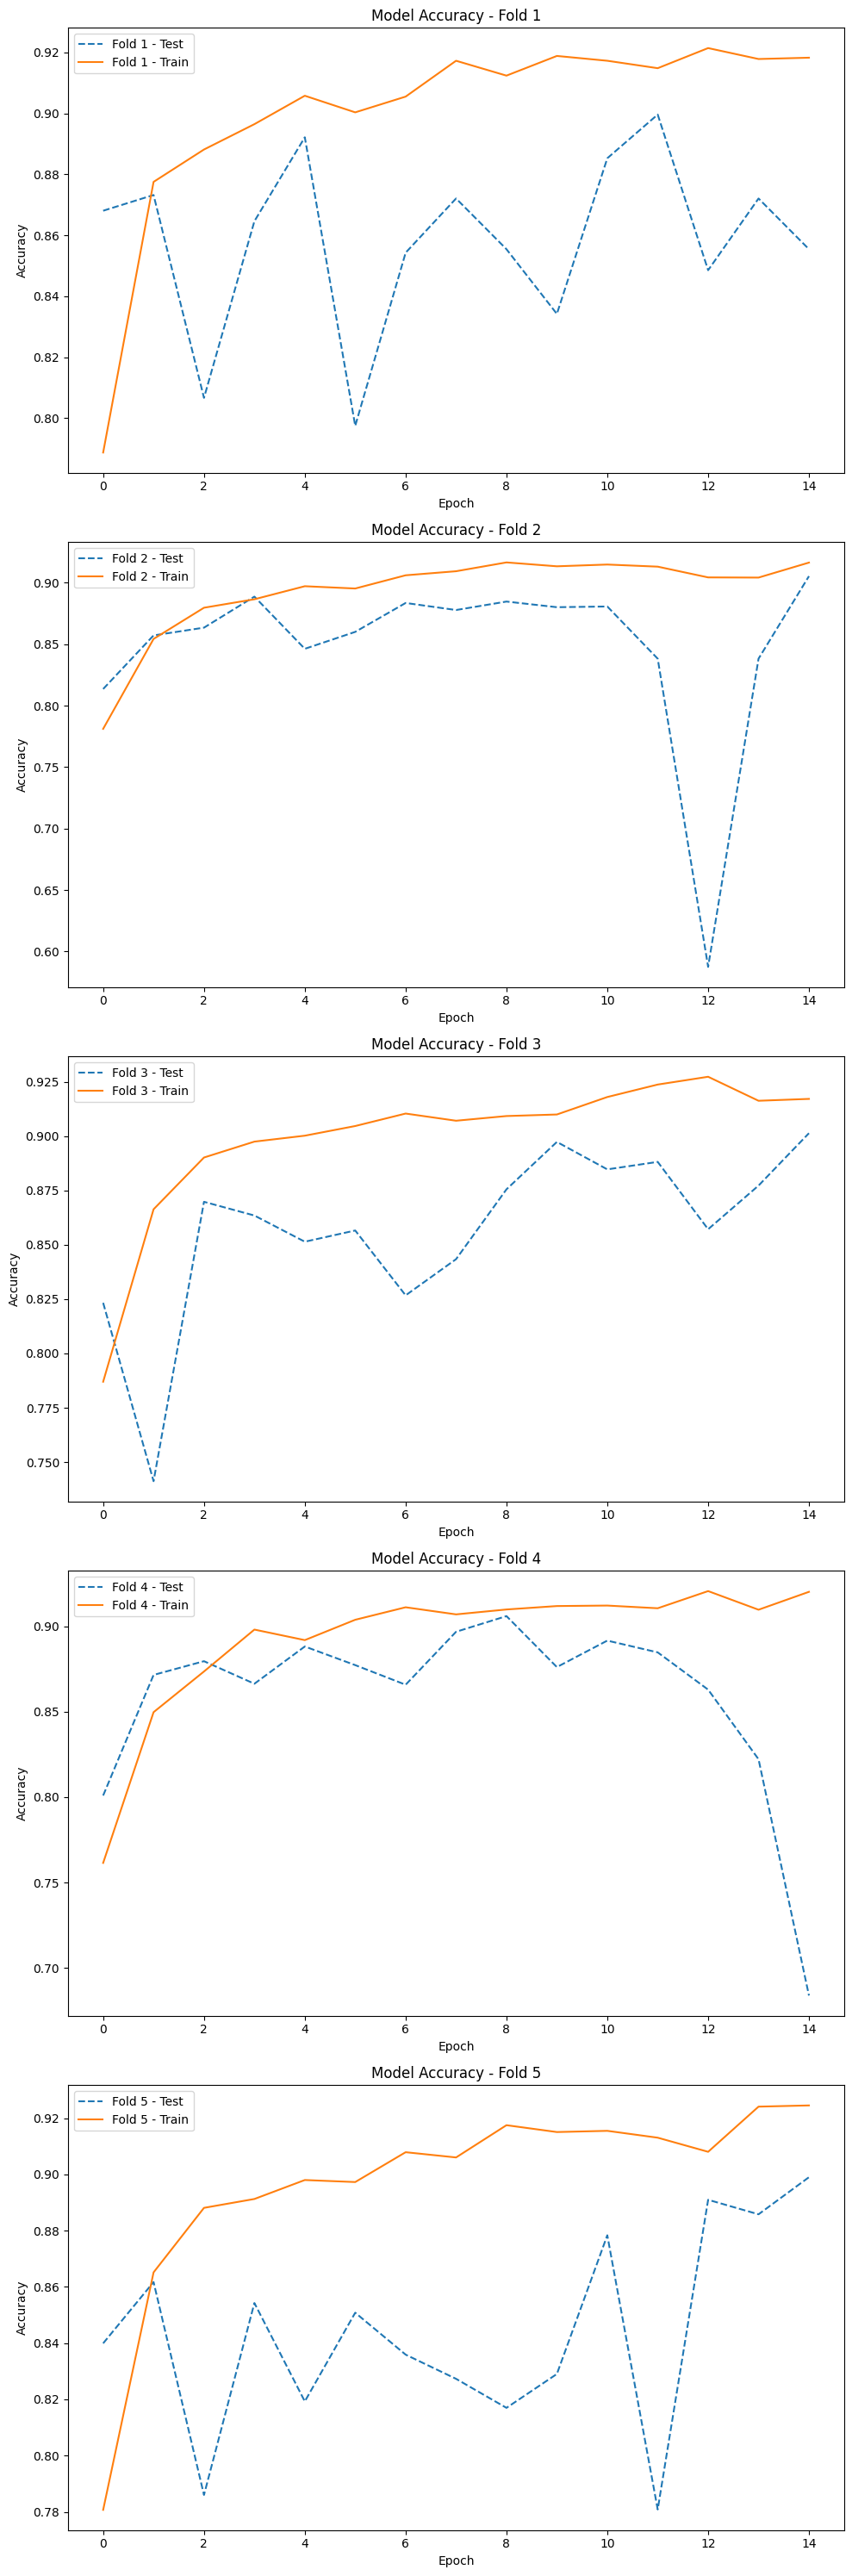

In [ ]:
fig, axs = plt.subplots(len(val_accuracies_xception), 1, figsize=(10, 6 * len(val_accuracies_xception)))  # İsteğe bağlı: Figür boyutunu ayarlayabilirsiniz

for i in range(len(val_accuracies_xception)):
    axs[i].plot(val_accuracies_xception[i], label=f'Fold {i+1} - Test', linestyle='--')
    axs[i].plot(train_accuracies_xception[i], label=f'Fold {i+1} - Train')

    axs[i].set_title(f'Model Accuracy - Fold {i+1}')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Epoch')
    axs[i].legend(loc='upper left')  # İsteğe bağlı: Konumu ayarlayabilirsiniz

plt.tight_layout()  # İsteğe bağlı: Alt grafikler arasındaki boşluğu ayarlar
plt.show()

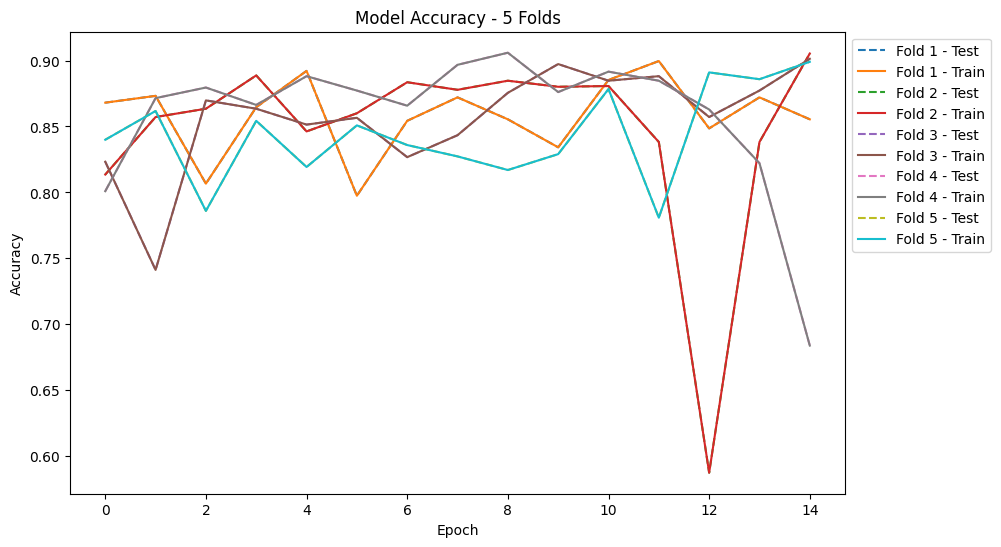

In [ ]:
# Her bir fold için grafiği tek bir figürde göstermek için
plt.figure(figsize=(10, 6))  # İsteğe bağlı: Figür boyutunu ayarlayabilirsiniz

for i in range(len(val_accuracies_xception)):
    plt.plot(val_accuracies_xception[i], label=f'Fold {i+1} - Test', linestyle='--')
    plt.plot(val_accuracies_xception[i], label=f'Fold {i+1} - Train')

plt.title('Model Accuracy - 5 Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # İsteğe bağlı: Konumu ayarlayabilirsiniz
plt.show()

## Precision, Recall and F1 Scores

In [ ]:
# Her bir k-fold iterasyonunun doğrulama doğruluğunu yazdırın
for i, precision in enumerate(fold_precisions, 1):
    print(f'Fold {i}: Precision = {precision}')

Fold 1: Precision = 0.7959903693294752
Fold 2: Precision = 0.8047829846757959
Fold 3: Precision = 0.752427701944948
Fold 4: Precision = 0.720613354554844
Fold 5: Precision = 0.7813146453460742


In [ ]:
# Her bir k-fold iterasyonunun doğrulama doğruluğunu yazdırın
for i, recall in enumerate(fold_recalls, 1):
    print(f'Fold {i}: Recall  = {recall}')

Fold 1: Recall  = 0.7928858290304074
Fold 2: Recall  = 0.7016637980493402
Fold 3: Recall  = 0.5920826161790017
Fold 4: Recall  = 0.6184738955823293
Fold 5: Recall  = 0.5220883534136547


In [ ]:
# Her bir k-fold iterasyonunun doğrulama doğruluğunu yazdırın
for i, f1_score in enumerate(fold_f1_scores, 1):
    print(f'Fold {i}: F1 Score = {f1_score}')

Fold 1: F1 Score = 0.7849830011022185
Fold 2: F1 Score = 0.6823999790106869
Fold 3: F1 Score = 0.5766511298768979
Fold 4: F1 Score = 0.5933059632391153
Fold 5: F1 Score = 0.5035596963742426


## Train Resnet Pretrained Model

In [ ]:
num_folds=5
# Veri setimizin indisleri
indices = np.arange(len(all_dataset_df))

val_losses_resnet=[]
val_accuracies_resnet=[]
train_accuracies_resnet=[]
train_losses_resnet=[]
# StratifiedKFold ile indisleri bölün
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for train_index, test_index in skf.split(indices, all_dataset_df['class']):
    train_data = all_dataset_df.iloc[train_index]
    test_data = all_dataset_df.iloc[test_index]

    # train_data ve test_data ile generatorları oluşturun
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        xcol='filename',
        ycol='class',
        batch_size=32,
        target_size=(150, 150),
        class_mode='categorical',
        color_mode='rgb'
    )

    valid_generator = datagen.flow_from_dataframe(
        dataframe=test_data,
        xcol='filename',
        ycol='class',
        batch_size=32,
        target_size=(150, 150),
        class_mode='categorical',
        color_mode='rgb'
    )

    # Created Model
    resnet_model = build_model_resnet()

    history=resnet_model.fit(train_generator, epochs=15, validation_data=valid_generator,batch_size=200)
    train_accuracy=history.history['accuracy'] # Tüm epochların değerini al
    train_loss=history.history['loss']
    val_accuracy = history.history['val_accuracy']  # Tüm epochların değerlerini al
    val_loss=history.history['val_loss']
    train_accuracies_resnet.append(train_accuracy)
    train_losses_resnet.append(train_loss)
    val_accuracies_resnet.append(val_accuracy)
    val_losses_resnet.append(val_loss)


Found 6972 validated image filenames belonging to 5 classes.
Found 1743 validated image filenames belonging to 5 classes.
94668760/94668760 [==============================] - 0s 0us/step


Epoch 1/15
218/218 [==============================] - 1932s 9s/step - loss: 1.0162 - accuracy: 0.6252 - val_loss: 8.4145 - val_accuracy: 0.5473
Epoch 2/15
218/218 [==============================] - 41s 185ms/step - loss: 0.5908 - accuracy: 0.7622 - val_loss: 0.6851 - val_accuracy: 0.7717
Epoch 3/15
218/218 [==============================] - 42s 191ms/step - loss: 0.4392 - accuracy: 0.8186 - val_loss: 1.1491 - val_accuracy: 0.7349
Epoch 4/15
218/218 [==============================] - 42s 194ms/step - loss: 0.3900 - accuracy: 0.8425 - val_loss: 0.6845 - val_accuracy: 0.7281
Epoch 5/15
218/218 [==============================] - 42s 193ms/step - loss: 0.3540 - accuracy: 0.8587 - val_loss: 0.8387 - val_accuracy: 0.7114
Epoch 6/15
218/218 [==============================] - 42s 194ms/step - loss: 0.3348 - accuracy: 0.8581 - val_loss: 1.7455 - val_accuracy: 0.4228
Epoch 7/15
218/218 [==============================] - 42s 193ms/step - loss: 0.3520 - accuracy: 0.8533 - val_loss: 0.6272 - val_acc

Epoch 1/15
218/218 [==============================] - 66s 199ms/step - loss: 0.8323 - accuracy: 0.6941 - val_loss: 1.2648 - val_accuracy: 0.6403
Epoch 2/15
218/218 [==============================] - 42s 191ms/step - loss: 0.4979 - accuracy: 0.7950 - val_loss: 1.5520 - val_accuracy: 0.6931
Epoch 3/15
218/218 [==============================] - 42s 192ms/step - loss: 0.3787 - accuracy: 0.8437 - val_loss: 2.6319 - val_accuracy: 0.4378
Epoch 4/15
218/218 [==============================] - 42s 193ms/step - loss: 0.3538 - accuracy: 0.8584 - val_loss: 2.3470 - val_accuracy: 0.4699
Epoch 5/15
218/218 [==============================] - 42s 192ms/step - loss: 0.3062 - accuracy: 0.8668 - val_loss: 6.6813 - val_accuracy: 0.2920
Epoch 6/15
218/218 [==============================] - 42s 192ms/step - loss: 0.3523 - accuracy: 0.8569 - val_loss: 2.0329 - val_accuracy: 0.4768
Epoch 7/15
218/218 [==============================] - 42s 192ms/step - loss: 0.2956 - accuracy: 0.8709 - val_loss: 0.5107 - val_ac

Epoch 1/15
218/218 [==============================] - 66s 203ms/step - loss: 0.8405 - accuracy: 0.6895 - val_loss: 2.5480 - val_accuracy: 0.4349
Epoch 2/15
218/218 [==============================] - 42s 193ms/step - loss: 0.5231 - accuracy: 0.7902 - val_loss: 1.0771 - val_accuracy: 0.6793
Epoch 3/15
218/218 [==============================] - 42s 194ms/step - loss: 0.5465 - accuracy: 0.7811 - val_loss: 0.8610 - val_accuracy: 0.7252
Epoch 4/15
218/218 [==============================] - 42s 193ms/step - loss: 0.3955 - accuracy: 0.8401 - val_loss: 0.8600 - val_accuracy: 0.7137
Epoch 5/15
218/218 [==============================] - 42s 193ms/step - loss: 0.3317 - accuracy: 0.8573 - val_loss: 0.5570 - val_accuracy: 0.7831
Epoch 6/15
218/218 [==============================] - 42s 194ms/step - loss: 0.3035 - accuracy: 0.8741 - val_loss: 0.6855 - val_accuracy: 0.7619
Epoch 7/15
218/218 [==============================] - 42s 194ms/step - loss: 0.2841 - accuracy: 0.8781 - val_loss: 0.9420 - val_ac

Epoch 1/15
218/218 [==============================] - 66s 200ms/step - loss: 0.8243 - accuracy: 0.6998 - val_loss: 1.3239 - val_accuracy: 0.6196
Epoch 2/15
218/218 [==============================] - 42s 194ms/step - loss: 0.4850 - accuracy: 0.8051 - val_loss: 0.5660 - val_accuracy: 0.7808
Epoch 3/15
218/218 [==============================] - 43s 196ms/step - loss: 0.4100 - accuracy: 0.8266 - val_loss: 2.4538 - val_accuracy: 0.4727
Epoch 4/15
218/218 [==============================] - 42s 194ms/step - loss: 0.3465 - accuracy: 0.8540 - val_loss: 1.2054 - val_accuracy: 0.6999
Epoch 5/15
218/218 [==============================] - 43s 195ms/step - loss: 0.3074 - accuracy: 0.8655 - val_loss: 0.8645 - val_accuracy: 0.7269
Epoch 6/15
218/218 [==============================] - 43s 196ms/step - loss: 0.3407 - accuracy: 0.8614 - val_loss: 158.5479 - val_accuracy: 0.2174
Epoch 7/15
218/218 [==============================] - 43s 196ms/step - loss: 0.3416 - accuracy: 0.8546 - val_loss: 1.0892 - val_

Epoch 1/15
218/218 [==============================] - 68s 200ms/step - loss: 0.9750 - accuracy: 0.6414 - val_loss: 1.5079 - val_accuracy: 0.4607
Epoch 2/15
218/218 [==============================] - 42s 192ms/step - loss: 0.5609 - accuracy: 0.7814 - val_loss: 1.1000 - val_accuracy: 0.5972
Epoch 3/15
218/218 [==============================] - 42s 194ms/step - loss: 0.4225 - accuracy: 0.8325 - val_loss: 0.9556 - val_accuracy: 0.6477
Epoch 4/15
218/218 [==============================] - 42s 193ms/step - loss: 0.3369 - accuracy: 0.8606 - val_loss: 0.6513 - val_accuracy: 0.7676
Epoch 5/15
218/218 [==============================] - 42s 193ms/step - loss: 0.2825 - accuracy: 0.8782 - val_loss: 0.5860 - val_accuracy: 0.7785
Epoch 6/15
218/218 [==============================] - 42s 193ms/step - loss: 0.2821 - accuracy: 0.8824 - val_loss: 0.4054 - val_accuracy: 0.8451
Epoch 7/15
218/218 [==============================] - 42s 193ms/step - loss: 0.2927 - accuracy: 0.8801 - val_loss: 1.1567 - val_ac

## Draw Loss and Accuracy Graphs For Resnet Network

In [ ]:
# Her bir k-fold iterasyonunun doğrulama doğruluğunu yazdırın
for i, acc in enumerate(val_accuracies_resnet, 1):
    print(f'Fold {i}: Validation Accuracy = {acc}')

# Ortalama doğrulama doğruluğunu hesaplayın
average_val_accuracy_resnet = np.mean(val_accuracies_resnet)
print(f'Average Validation Accuracy: {average_val_accuracy_resnet}')

Fold 1: Validation Accuracy = [0.5473321676254272, 0.7716580629348755, 0.7349397540092468, 0.7280550599098206, 0.7114170789718628, 0.422834187746048, 0.7940332889556885, 0.8227194547653198, 0.7423981428146362, 0.717154324054718, 0.7412506937980652, 0.4658634662628174, 0.6540447473526001, 0.7349397540092468, 0.828456699848175]
Fold 2: Validation Accuracy = [0.6402753591537476, 0.6930579543113708, 0.43775099515914917, 0.46987950801849365, 0.29202523827552795, 0.4767642021179199, 0.8129661679267883, 0.5960986614227295, 0.8336201906204224, 0.6896156072616577, 0.8445209264755249, 0.44463568925857544, 0.8129661679267883, 0.3339070677757263, 0.7986230850219727]
Fold 3: Validation Accuracy = [0.43488237261772156, 0.6792885661125183, 0.7251864671707153, 0.7137119770050049, 0.7831325531005859, 0.761904776096344, 0.7314974069595337, 0.4343086779117584, 0.7596098780632019, 0.7659208178520203, 0.7940332889556885, 0.38668960332870483, 0.6224899888038635, 0.782558798789978, 0.7596098780632019]
Fold 4

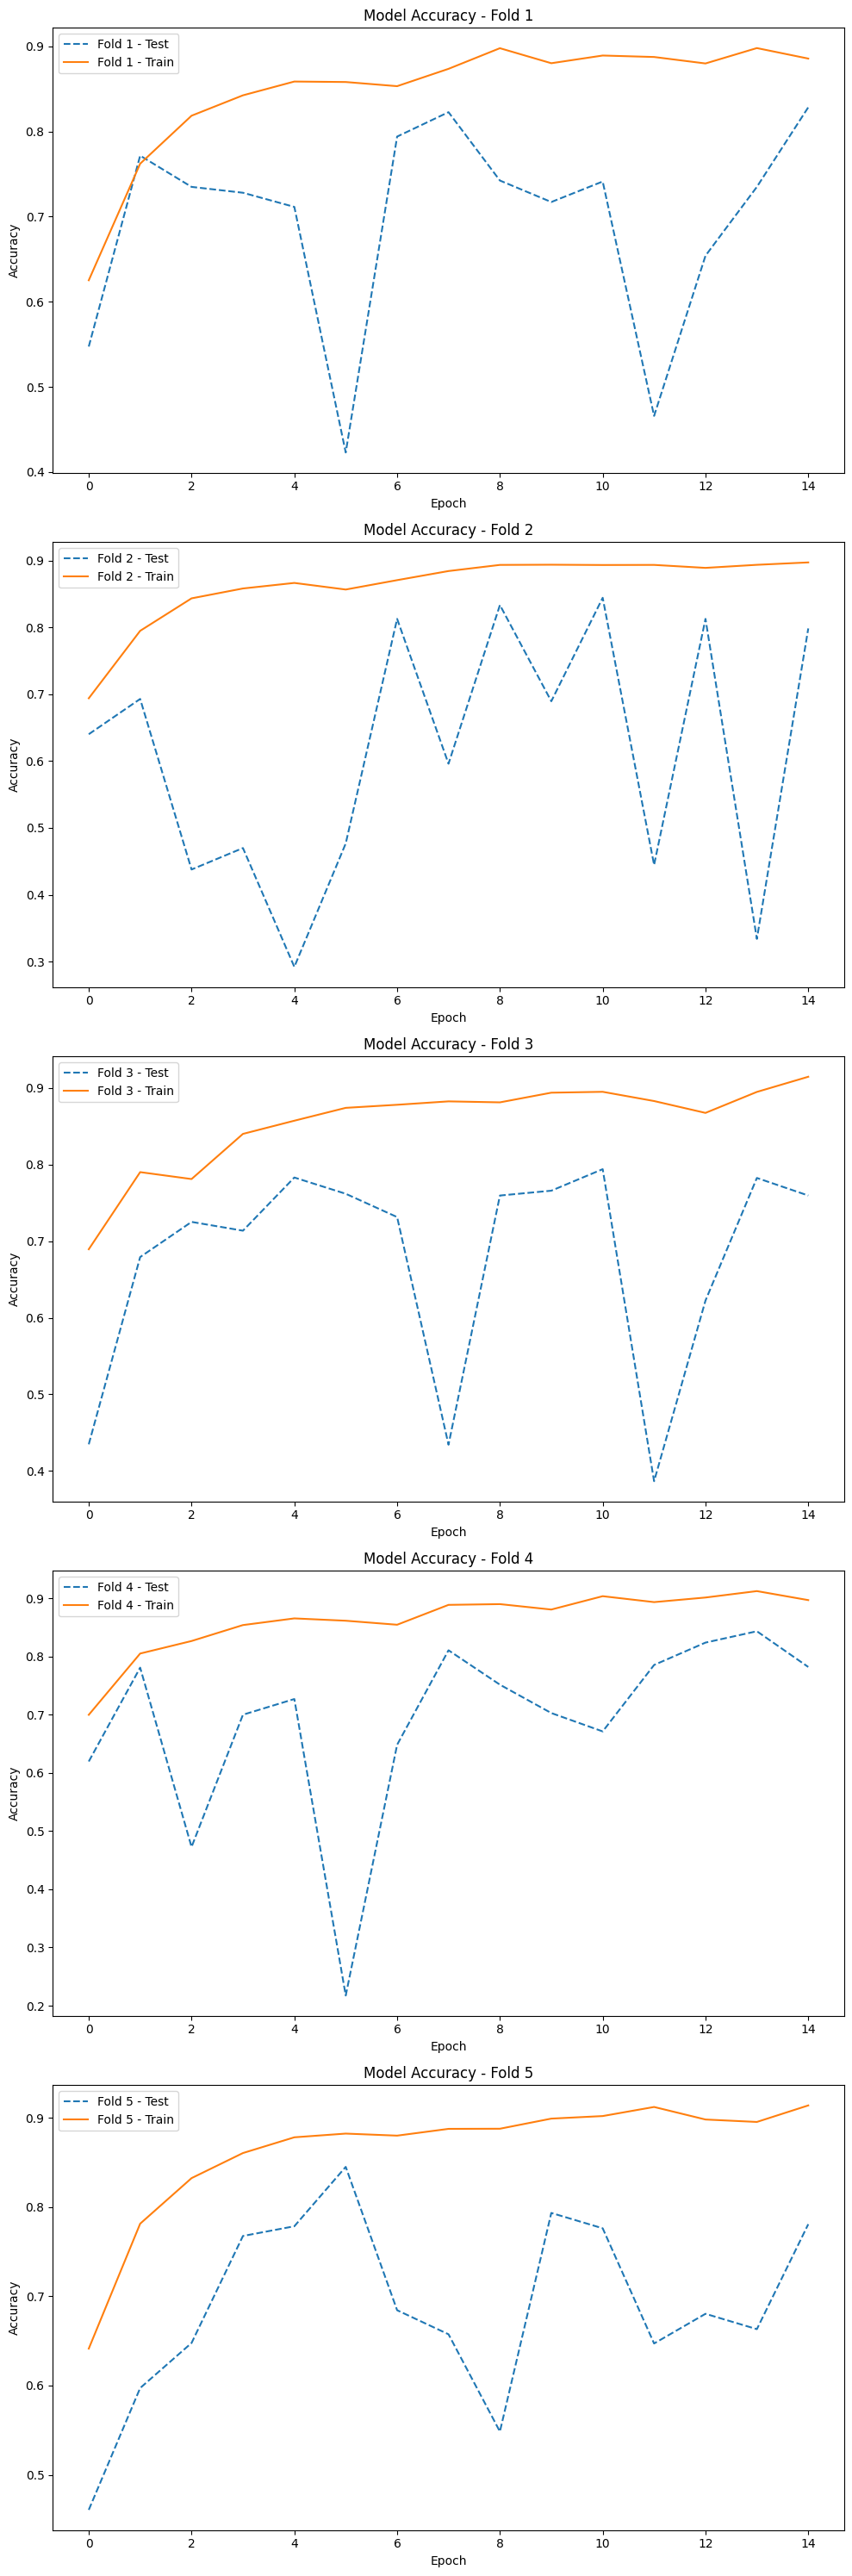

In [ ]:
fig, axs = plt.subplots(len(val_accuracies_resnet), 1, figsize=(10, 6 * len(val_accuracies_resnet)))  # İsteğe bağlı: Figür boyutunu ayarlayabilirsiniz

for i in range(len(val_accuracies_resnet)):
    axs[i].plot(val_accuracies_resnet[i], label=f'Fold {i+1} - Test', linestyle='--')
    axs[i].plot(train_accuracies_resnet[i], label=f'Fold {i+1} - Train')

    axs[i].set_title(f'Model Accuracy - Fold {i+1}')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Epoch')
    axs[i].legend(loc='upper left')  # İsteğe bağlı: Konumu ayarlayabilirsiniz

plt.tight_layout()  # İsteğe bağlı: Alt grafikler arasındaki boşluğu ayarlar
plt.show()

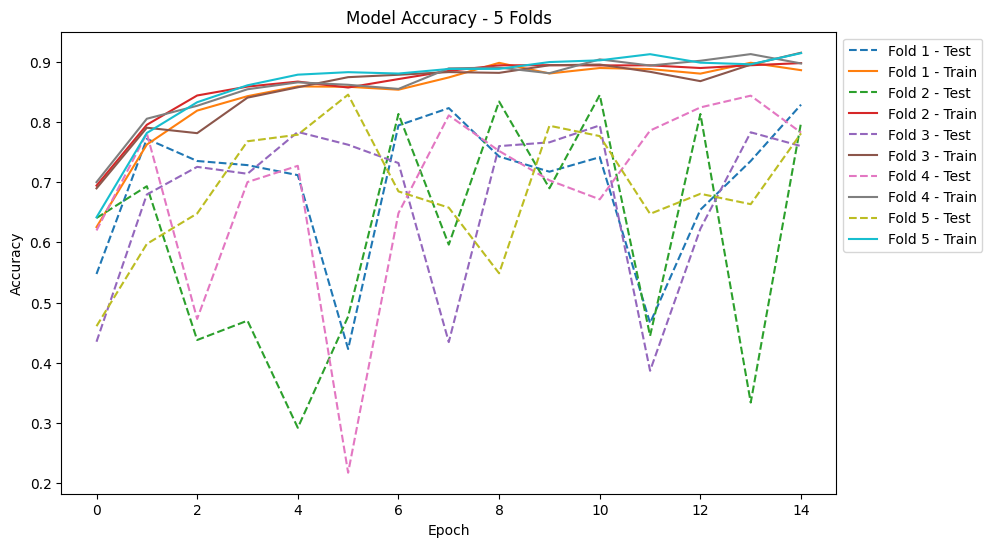

In [ ]:
# Her bir fold için grafiği tek bir figürde göstermek için
plt.figure(figsize=(10, 6))  # İsteğe bağlı: Figür boyutunu ayarlayabilirsiniz

for i in range(len(val_accuracies_resnet)):
    plt.plot(val_accuracies_resnet[i], label=f'Fold {i+1} - Test', linestyle='--')
    plt.plot(train_accuracies_resnet[i], label=f'Fold {i+1} - Train')

plt.title('Model Accuracy - 5 Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # İsteğe bağlı: Konumu ayarlayabilirsiniz
plt.show()

## Load Pretrained Model

In [ ]:
model_xception=tf.keras.models.load_model('/content/drive/MyDrive/oral_disease_models/cross_validated_model_last_xception_last_of_last.h5');

OSError: ignored

## Confusion Matrix

## Save Model

In [ ]:
model_xception.save('cross_validated_model_xception_last_of_all.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Download Model

In [ ]:
from google.colab import files
# Model dosyasının ismi
model_filename = '/content/cross_validated_model_xception_last_of_all.h5'

# Dosyayı indir
files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>